# Embedding analysis: 


In [88]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image,add_noise_torch, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
from synthetic_data_generators import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

In [90]:
# results_dir = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/results/'


## Load denoisers


In [91]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/22_representation_in_UNet_denoiser/denoisers/'

paths = { 'mixture-gray':'UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160/',           
            # 'conditional-gray':'UNet_conditional_mean_matching/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160/'
        }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
      

loading group  mixture-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name ovals
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160
optional_dir_label gray_5_classes
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 172
coarse True
num_kernels [16, 32, 64, 128, 256]
num_blocks 4
num_enc_conv [2, 2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  2530385
train mode: False
--- 0 seconds ---


In [92]:
denoisers.keys()

dict_keys(['mixture-gray'])

In [93]:
blocks = ['enc0','enc1', 'enc2','enc3','mid','dec3', 'dec2', 'dec1']

# denoisers['conditional-gray'].save_means

## Load datasets 

In [94]:
def make_oval_dataset(set_size, aspect_ratios ): 
    # train 
    N = int(set_size/len(aspect_ratios))

    all_data_train = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N, aspect_ratio=aspect_ratio, W=160, H=160)
        all_data_train.append(data)
    
    #test 
    all_data_test = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N = 100, aspect_ratio=aspect_ratio, W=160, H=160)
        all_data_test.append(data)
        
    return all_data_train, all_data_test

In [95]:
train_sets, test_sets = make_oval_dataset(100, [.2,.5,1,2,5])

In [96]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print('number of classes: ', len(train_sets))

number of images in each class: torch.Size([20, 1, 160, 160])
number of classes:  5


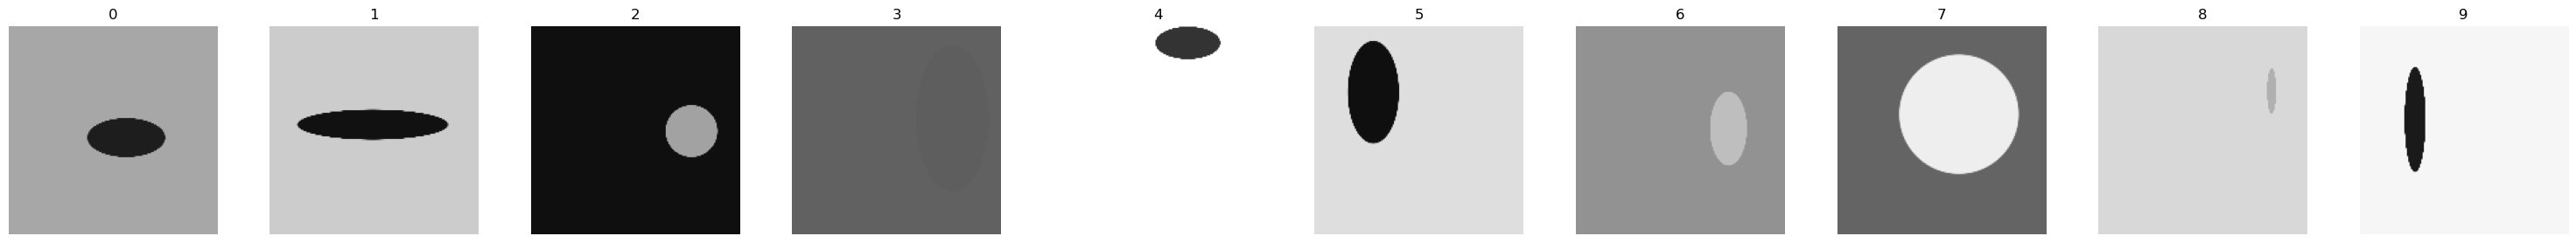

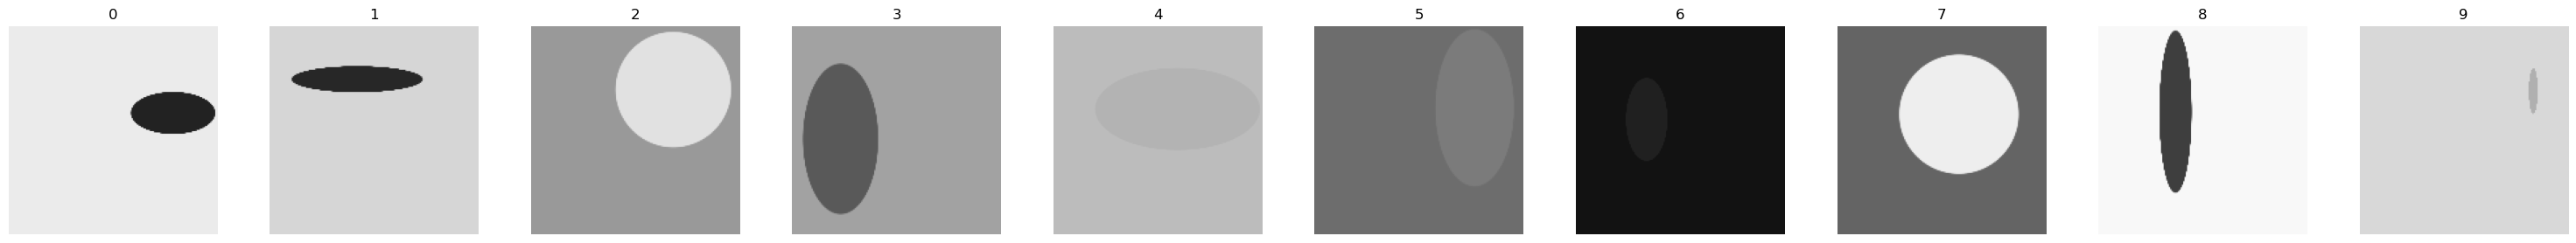

total number of train images: 100


In [97]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False, )    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(train['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of train images:',train['inp'].shape[0])


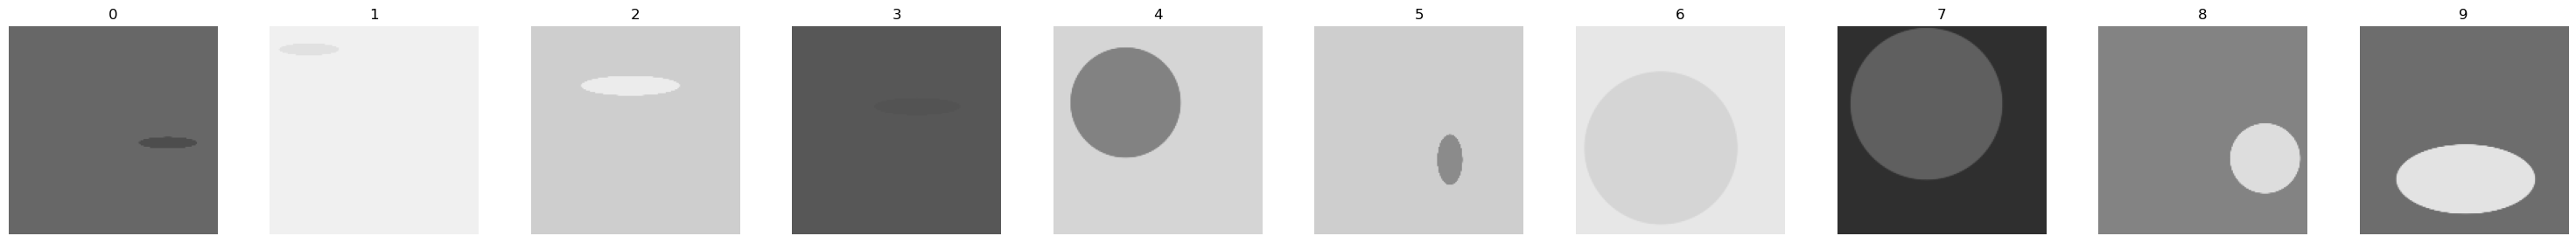

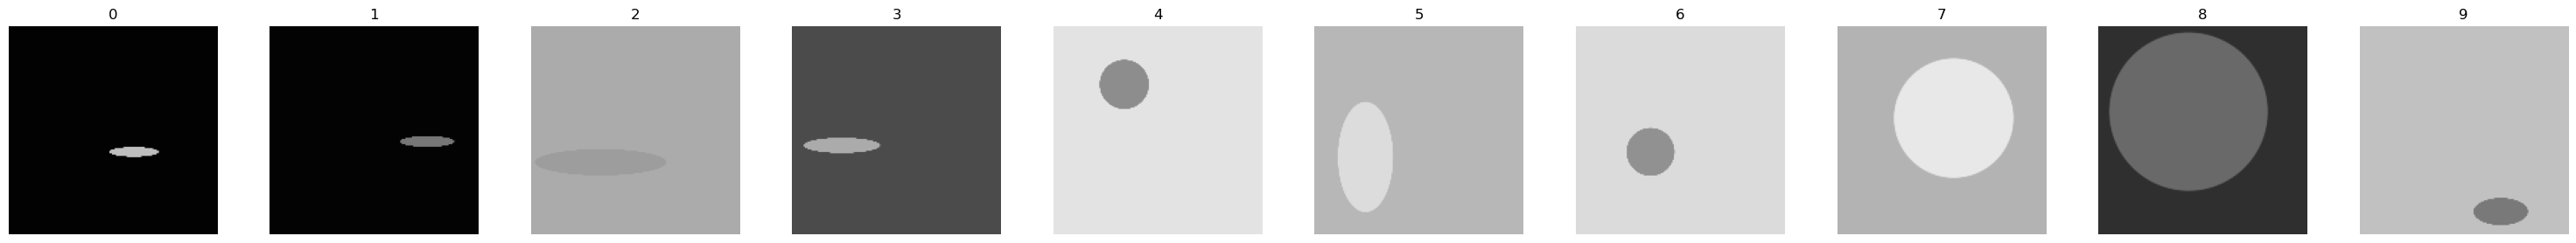

total number of test images: 500


In [98]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of test images:',test['inp'].shape[0])


In [99]:
test_sets_cat = torch.concatenate(test_sets)
test_sets_cat.shape

torch.Size([500, 1, 160, 160])

In [100]:
test['inp'].mean(dim=(1,2,3)).shape

torch.Size([500])

tensor(0.5045)


160

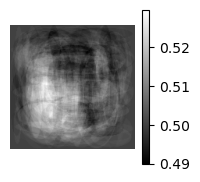

In [101]:
dist_mean = test['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

# auxilary functions 

In [102]:
similarity_matrix = lambda data : data/data.norm(dim = 1, keepdim=True) @(data/data.norm(dim = 1, keepdim=True)).T

degree_matrix = lambda sim_mat : torch.diag(sim_mat.sum(dim = 1))

participation_ratio = lambda v :  (v.norm(1)**2)/v.norm(2)**2/len(v)
participation_ratio_dataset = lambda data :  (data.norm(1, dim = 1)**2)/data.norm(2,dim = 1)**2/data.shape[1]


In [103]:

def get_channel_means(unet, x1, x2=None, average_phi=False, with_params=True, return_activations = False): 
    '''
    returns means of channels (phi) of a conditional or regular UNet
    if conditional unet: returns means of channels for either input or conditioner image, or both
    if unconditional unet: returns means of channels for input
    @noisy: of shape N,C,H,W
    @with_param: important: set to False if phi is computed to be given to the network (instead of x)
    '''    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # set network in saving mode
    unet.save_means = True    
    if return_activations: 
        unet.save_activations = True

    #compute the responses 
    with torch.no_grad():
        try: #for conditional model
            if x2 is None: #if only conditioner image is given 
                out = unet(x1.to(device), x1.to(device), average_phi)
            else: # if a noisy input is also given
                out = unet(x2.to(device), x1.to(device), average_phi)
                x_means = unet.stored_x_means
                
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            
        except TypeError: # for the unconditional model
            out = unet(x1.to(device))
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            if average_phi: 
                for i in range(len(x_c_means)): 
                    x_c_means[i] = x_c_means[i].mean(0,keepdim=True)
            
    
    unet.save_means = False
    unet.save_activations = False


    if with_params:   
        try:
            params = get_matching_params(unet)
            for i in range(len(params)): 
                x_c_means[i] = x_c_means[i] * params[i]
        except AttributeError: 
            pass

    if (x2 is None) & (return_activations is False): 
        return x_c_means
    elif (x2 is None) & (return_activations is True): 
        return x_c_means, x_c
    elif (x2 is not None) & (return_activations is False): 
        return x_c_means, x_means
    else: 
        return x_c_means, x_means, x_c

def get_matching_params(unet): 
    params = []
    for l in range(len(unet.encoder_matching_params)):
        params.append(unet.encoder_matching_params[str(l)].detach().to(device))
    params.append(unet.mid_matching_params.detach().to(device))
    for l in range(len(unet.decoder_matching_params)-1, 0,-1):
        params.append(unet.decoder_matching_params[str(l)].detach().to(device))
    return params

tensor([4])


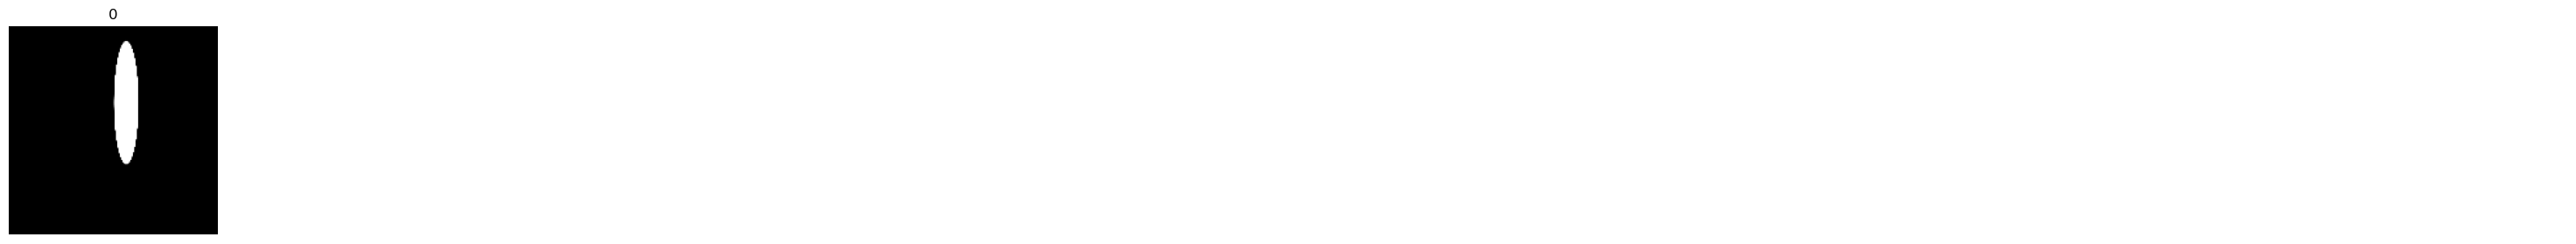

In [104]:
ids = torch.randint(0,len(test_sets), (1,))
print(ids)
sigmas =np.linspace(0, 250, 5).astype(int)
inp_ims = test_sets[ids[0]][0:1]


if 'gray' in group.split('-'): 
    show_im_set(inp_ims.mean(dim = 1, keepdim = True)[0:1],  n_columns=10)
else: 
    show_im_set(inp_ims[0:1],  n_columns=10)
    
inp_ims = torch.tile(inp_ims, (30,1,1,1))


if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)


all_phis  = {}
noise = torch.randn_like(inp_ims)

for sig in sigmas: 
    
    noisy_inp_ims = inp_ims + noise * sig/255
    # phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              # average_phi=False,with_params=False , return_activations=False)
    phi_xc = get_activation_means_unconditional(denoisers[group], noisy_inp_ims, noGrad=True)
    all_phis[sig] = phi_xc
    

0 participation ratio:  0.19035716354846954 , norm zero:  226.0
62 participation ratio:  0.11488823592662811 , norm zero:  253.0
125 participation ratio:  0.09028460830450058 , norm zero:  248.0
187 participation ratio:  0.08571315556764603 , norm zero:  248.0
250 participation ratio:  0.08409806340932846 , norm zero:  247.0


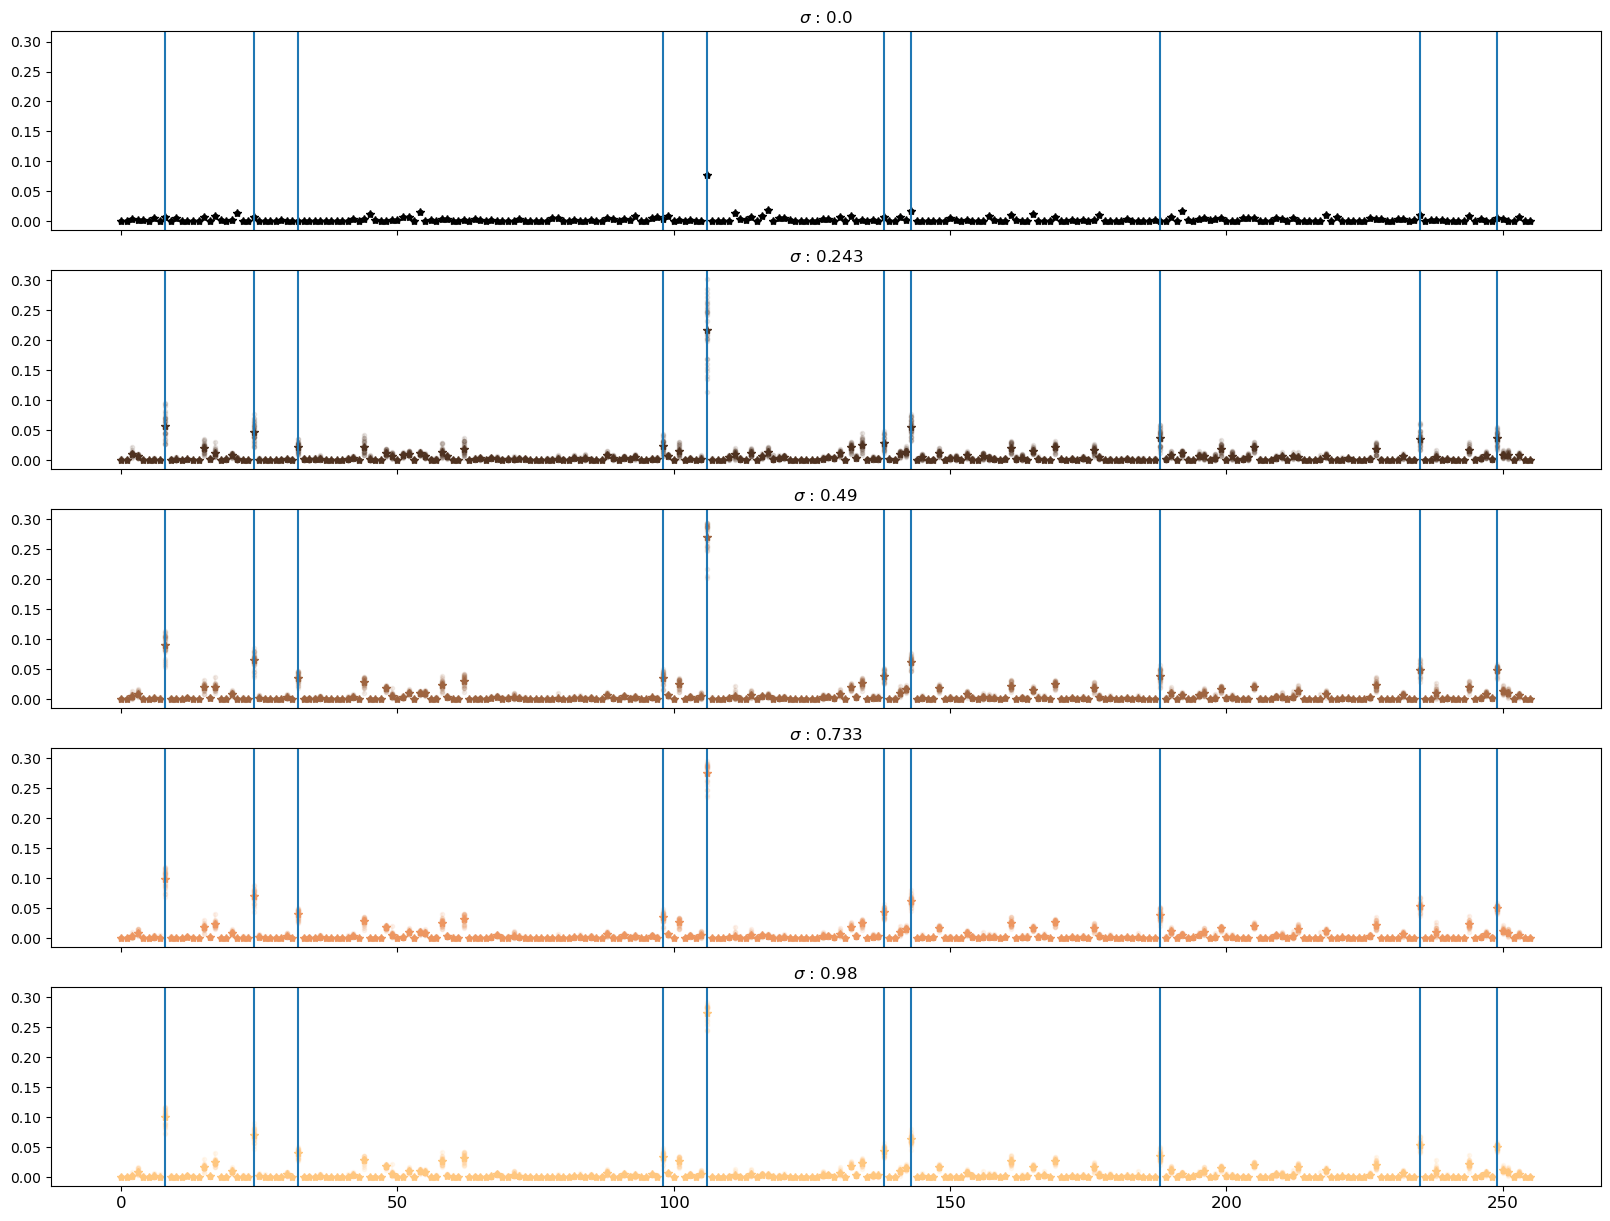

In [105]:
# sigmas =np.linspace(5, 250, 5).astype(int)

f , axs = plt.subplots(len(sigmas),1 ,figsize=(20, len(sigmas)* 3), sharex = True, sharey=True)
colormap = plt.cm.copper 
plot_colors = [colormap(i) for i in np.linspace(0, 1,len(sigmas))]
for j in range(len(sigmas)):
    sig = sigmas[j]
    for i in range(all_phis[sig][4].shape[1]):
        axs[j].plot( torch.ones(all_phis[sig][4].shape[0]) *i , all_phis[sig][4][:, i].cpu().flatten(),  '.-', alpha = .1 , color= plot_colors[j] )
        axs[j].plot( i , all_phis[sig][4][:, i].mean().cpu(),  '*-', alpha = 1, color= plot_colors[j]  )
        axs[j].set_title( '$\sigma$ : ' + str(np.round(sig/255  ,3)))
    for m in range(10):
        axs[j].axvline( all_phis[sigmas[-1]][4].mean(dim = (0)).argsort(descending=True).cpu()[m]  )    
    participation_ratio = (all_phis[sig][4].mean(dim = (0)).norm(1)**2 / all_phis[sig][4].mean(dim = (0)).norm(2)**2 )/all_phis[sig][4].shape[1]
    print(sig , 'participation ratio: ', participation_ratio.item(), ', norm zero: ',all_phis[sig][4].mean(dim = (0)).norm(0).item() )


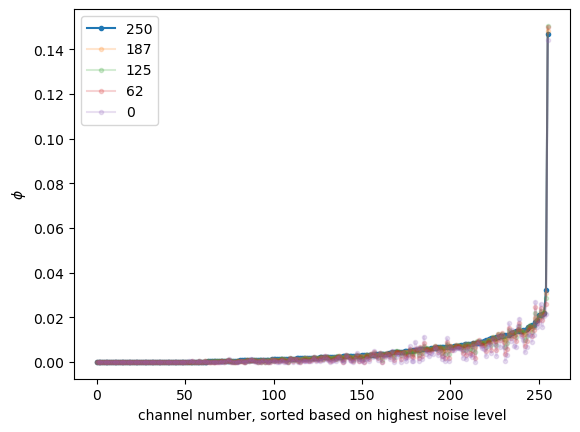

In [23]:
plt.plot(all_phis[sigmas[4]][4].mean(dim = (0)).cpu().sort()[0], '.-',label=sigmas[4])
plt.plot(all_phis[sigmas[3]][4].mean(dim = (0)).cpu()[all_phis[sigmas[4]][4].mean(dim = (0)).cpu().sort()[1]], '.-', alpha = .2,label=sigmas[3])
plt.plot(all_phis[sigmas[2]][4].mean(dim = (0)).cpu()[all_phis[sigmas[4]][4].mean(dim = (0)).cpu().sort()[1]], '.-', alpha = .2,label=sigmas[2])
plt.plot(all_phis[sigmas[1]][4].mean(dim = (0)).cpu()[all_phis[sigmas[4]][4].mean(dim = (0)).cpu().sort()[1]], '.-', alpha = .2,label=sigmas[1])
plt.plot(all_phis[sigmas[0]][4].mean(dim = (0)).cpu()[all_phis[sigmas[4]][4].mean(dim = (0)).cpu().sort()[1]], '.-', alpha = .2,label=sigmas[0])
plt.xlabel('channel number, sorted based on highest noise level')
plt.ylabel(r'$\phi$')
plt.legend()

In [25]:

sigmas =np.linspace(5, 250, 5).astype(int)


all_counts = {}
all_counts_ab = {}
all_counts_ba ={}

for i in range(len(sigmas)-1): 
    all_counts[i] = []
    all_counts_ab[i] = []
    all_counts_ba[i] = []
    
for _ in range(500): 
    
    ids = torch.randint(0,len(test_sets), (1,))
    inp_ims = torch.tile(test_sets[ids[0]][0:1], (30,1,1,1))
    
    noise = torch.randn_like(inp_ims)
    
    all_phis  = {}    
    all_sets =[]
    for sig in sigmas: 
        
        noisy_inp_ims = inp_ims + noise * sig/255
        # phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                                  # average_phi=False,with_params=False , return_activations=False)
        phi_xc = get_activation_means_unconditional(denoisers[group], noisy_inp_ims, noGrad=True)    
        all_phis[sig] = phi_xc
    
    
        stop_id = int(all_phis[sig][4].mean(dim = (0)).norm(1)**2 / all_phis[sig][4].mean(dim = (0)).norm(2)**2 )
        all_sets.append(set((all_phis[sig][4].mean(dim = (0)).argsort(descending=True).cpu()[0:stop_id ]).tolist()))
    
    for i in range(len(all_sets)-1 ): 
        den = (len(all_sets[i]) + len(all_sets[i+1]) )        
        count = len(all_sets[i].symmetric_difference(all_sets[i+1]))
        count_ab=  len(all_sets[i+1] - all_sets[i])
        count_ba = len(all_sets[i] - all_sets[i+1])
        all_counts[i].append(round(100* count / den ))    
        all_counts_ab[i].append(round(100* count_ab / den ))
        all_counts_ba[i].append(round(100* count_ba / den ))


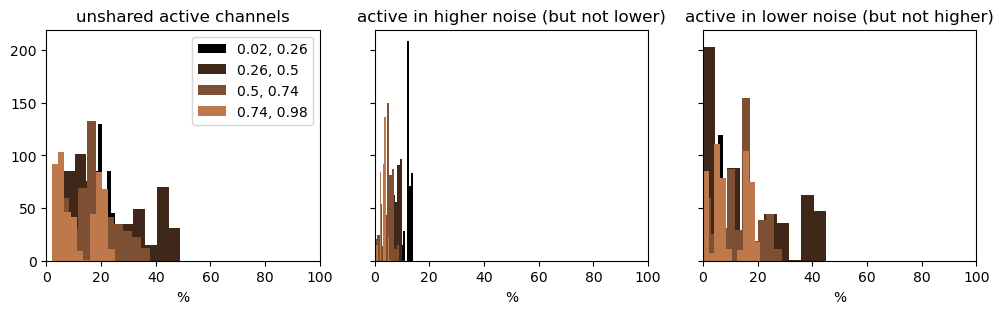

In [26]:
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1, 6)]

f , axs= plt.subplots(1,3, figsize = (12, 3), sharex=True, sharey=True)
for k,v in all_counts.items():
    axs[0].hist(v, color=plot_colors[k], bins=10, alpha = 1, label= f"{round(sigmas[k]/255 ,2)}, {round(sigmas[k+1]/255, 2)}"  )
    axs[0].set_xlim(0,100)
    axs[0].set_title('unshared active channels')
    axs[0].legend()
    axs[0].set_xlabel('%')    
for k,v in all_counts_ab.items():
    axs[1].hist(v, color=plot_colors[k], bins=10, alpha = 1)
    axs[1].set_title('active in higher noise (but not lower)')
    axs[1].set_xlabel('%')
for k,v in all_counts_ba.items():
    axs[2].hist(v, color=plot_colors[k], bins=10, alpha = 1)
    axs[2].set_title('active in lower noise (but not higher)')
    axs[2].set_xlabel('%')

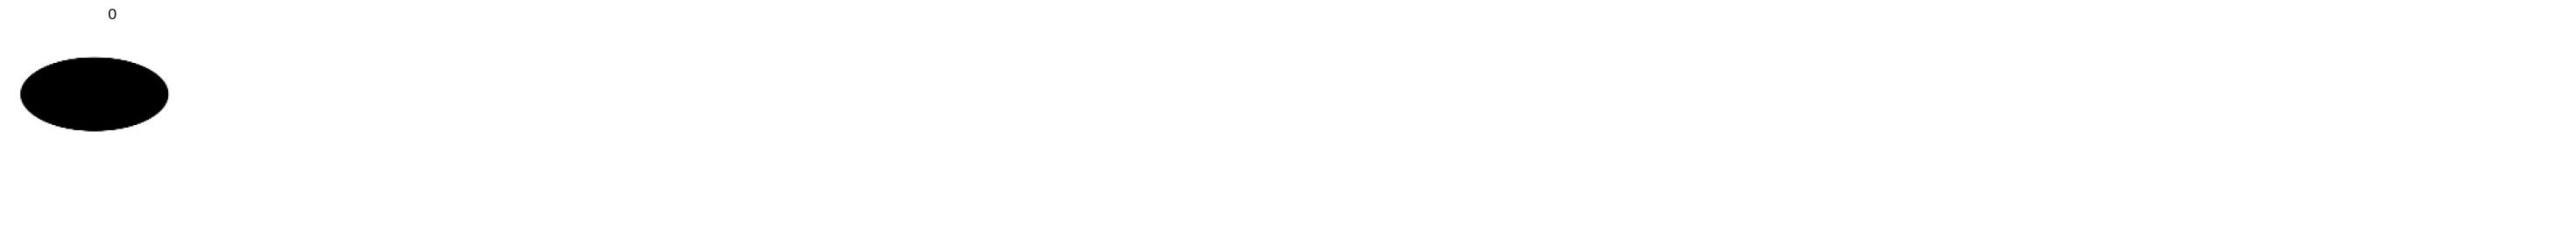

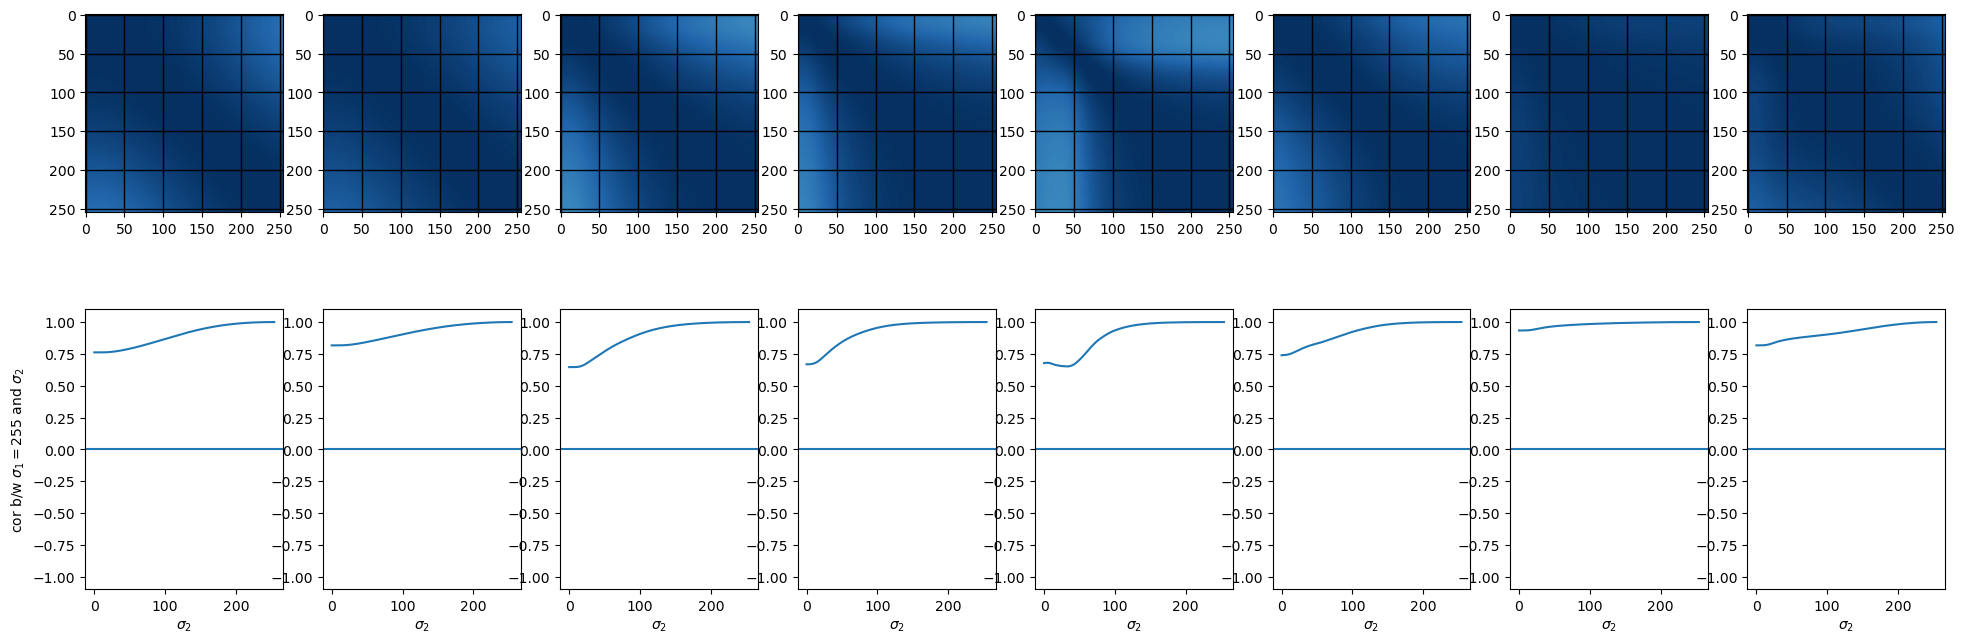

In [27]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = torch.randint(0,len(test_sets), (1,))
inp_ims = test_sets[ids[0]][0:1]



if 'gray' in group.split('-'): 
    show_im_set(inp_ims.mean(dim = 1, keepdim = True),  n_columns=10)
else: 
    show_im_set(inp_ims,  n_columns=10)
    
# inp_ims = train['inp'][0:200]
# inp_ims = train_sets[1]

# inp_ims = torch.tile(inp_ims, (20,1,1,1))

if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)

sigmas= range(0,255)
# sigmas= torch.logspace(.01,2.4,255)

all_phis  = {}
noise = torch.randn_like(inp_ims)

for sig in sigmas: 
    
    noisy_inp_ims = inp_ims + noise * sig/255
    # phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              # average_phi=True,with_params=False , return_activations=False)
    
    phi_xc = get_activation_means_unconditional(denoisers[group], noisy_inp_ims, noGrad=True)
    all_phis[sig] = phi_xc

### plot
f, axs = plt.subplots(2,len(all_phis[sig]), figsize = (24,8))

for b in range( len(all_phis[sig] )):
    temp = torch.corrcoef(torch.stack([all_phis[sig][b].flatten() for sig in sigmas]))

    axs[0,b].imshow(temp.cpu(), 'RdBu',vmin=-1 ,vmax = 1)
    # (all_phis[10][3].flatten() == 0).sum()
    # axs.tick_params(bottom=False,top = False, right = False, left=False)    
    axs[0,b].set_xticks(sigmas[0::50])  ;
    axs[0,b].set_yticks(sigmas[0::50]);
    axs[0,b].grid(color='k', linestyle='-', linewidth=1)
    axs[1,b].plot(temp[-1,:].cpu())
    # axs[1,b].plot(temp[torch.triu(torch.tril(temp, diagonal=1) , diagonal=1) !=0].cpu())    
    axs[1,b].set_ylim(-1.1,1.1)
    axs[1,b].axhline(0)    
    axs[1,b].set_xlabel('$\sigma_2$')    
axs[1,0].set_ylabel('cor b/w $\sigma_1=255$ and $\sigma_2$');    


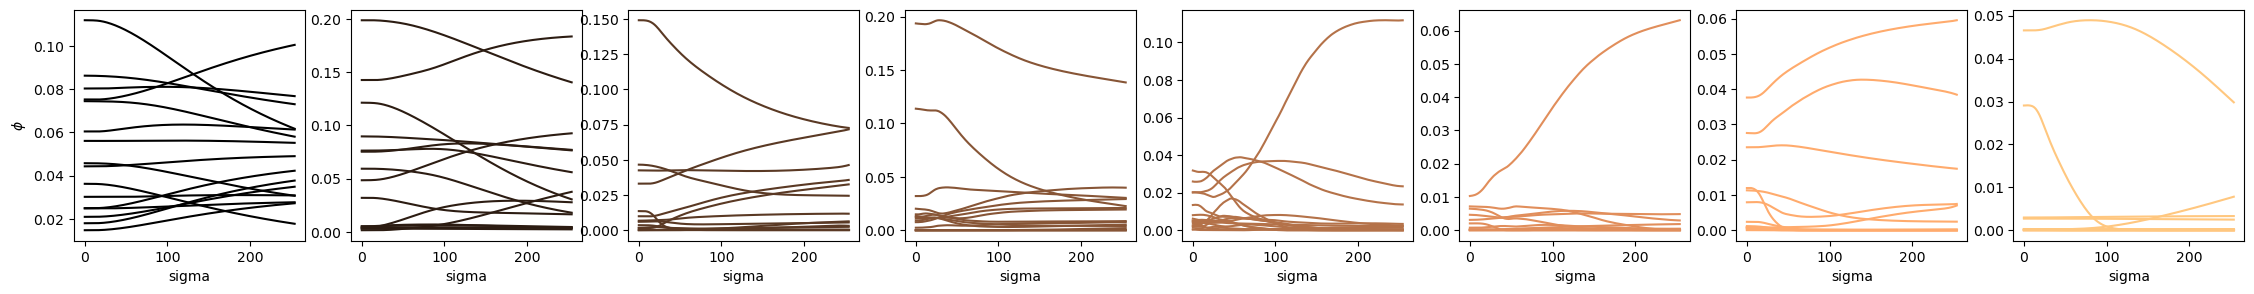

In [29]:
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1, 8)]

f, axs = plt.subplots(1,len(phi_xc), figsize=(len(phi_xc)*3.5, 3 ) )
for b in range(len(phi_xc)):
    for i in range(0, phi_xc[0].shape[1] ): 
        axs[b].plot(sigmas, torch.tensor([all_phis[sig][b].mean(dim = 0).squeeze()[i]  for sig in sigmas] ),
                    alpha = 1 , color = plot_colors[b])

    axs[b].set_xlabel('sigma')
    axs[0].set_ylabel('$\phi$')


In [30]:
## for many images 
# noise = torch.randn(1,3,64,64)

ids = torch.randint(0,len(test_sets_cat), (100,))
inp_ims = test_sets_cat[ids]

if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)

sigmas= range(1,256, 1)

all_phis  = {}

for sig in sigmas: 
    sigs = (sig/255) * torch.ones(inp_ims.shape[0],1,1,1)
    phi_xc = phi_c_noise_averaged(denoisers[group], x_c=inp_ims, sigs=sigs, n_noise=5 ) 

    # phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, average_phi=False)    
    all_phis[sig] = phi_xc


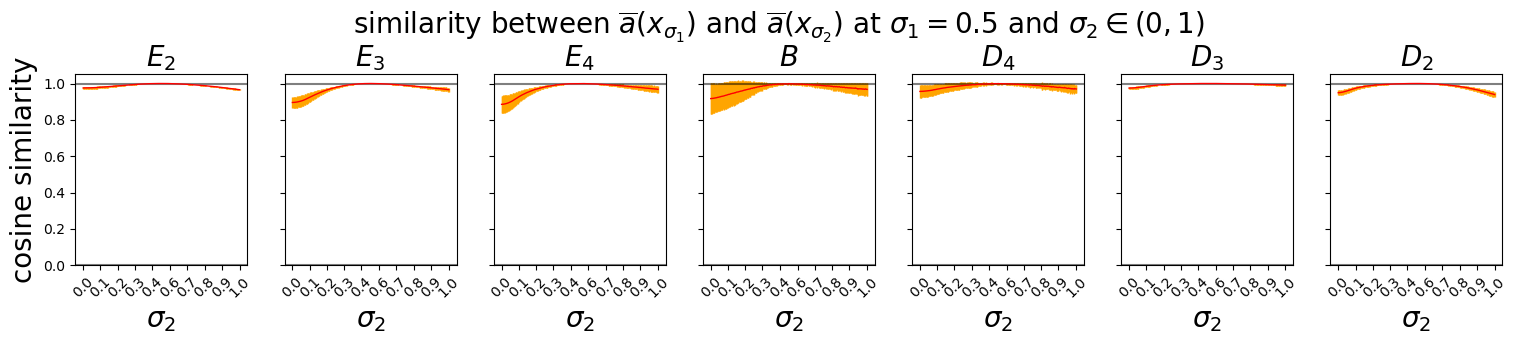

In [37]:
block_names = ['$E_2$', 
          '$E_3$', 
         '$E_4$', 
          '$B$', 
          '$D_4$',
          '$D_3$', 
              '$D_2$', ]

all_corrs = {}
for b in range(1,8):
    temp = torch.stack([all_phis[sig][b].squeeze() for sig in sigmas])
    
    all_corrs[b] = []
    for i in range(len(inp_ims)): 
        # all_corrs[b].append(torch.corrcoef(temp[:,i,:]))
        all_corrs[b].append(similarity_matrix(temp[:,i,:]))
    all_corrs[b] = torch.stack(all_corrs[b])

### plot 
f, axs = plt.subplots(1,len(all_phis[sig])-1, figsize = (15,3), sharey=True, sharex=True)
f.suptitle('similarity between $\overline{a}(x_{\sigma_1})$ and $\overline{a}(x_{\sigma_2})$ at $\sigma_1=0.5$ and $\sigma_2 \in (0,1)$', fontsize = 20)
# 
plt.tight_layout()

for b in range(1,8):
    axs[b-1].errorbar(range(1,256) ,all_corrs[b][:, 127, :].mean(dim = 0).cpu() , yerr=all_corrs[b][:, 127, :].std(dim = 0).cpu() ,lw=1 ,
                    elinewidth = 1, color='red', ecolor = 'orange' )
    axs[b-1].set_ylim(0,1.05)
    axs[b-1].axhline(0, color='black', alpha = .5)    
    axs[b-1].axhline(1, color='black', alpha = .5)        
    axs[b-1].set_xlabel('$\sigma_2$', fontsize = 20)    
    axs[b-1].set_title(block_names[b-1],fontsize = 20)
    axs[b-1].set_xticks(ticks=(torch.linspace(1,255, 10)).int(), labels= np.round(np.linspace(1,255, 10)/255, 1), rotation=45  );
    
axs[0].set_ylabel('cosine similarity', fontsize = 20);   
# plt.savefig('../results/unet_phi_sigma_dependence_row.pdf',bbox_inches='tight')    


In [43]:
all_participation_ratio= {}

for sig in [1,10,50,150,255]: 
    all_participation_ratio[sig] = []
    for b in range(8):
        all_participation_ratio[sig].append(participation_ratio_dataset(all_phis[sig][b]))


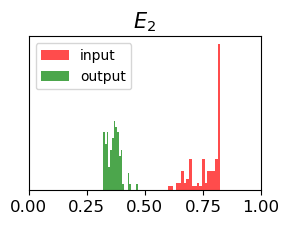

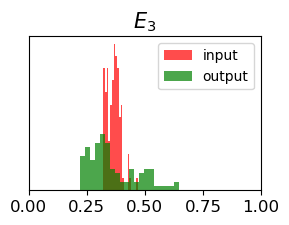

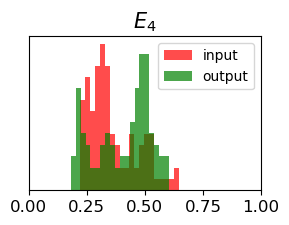

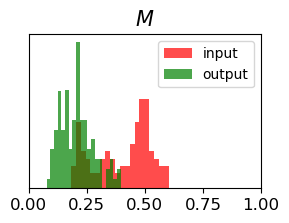

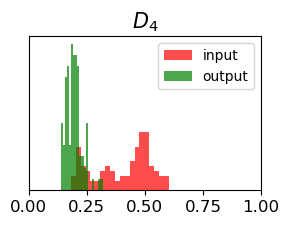

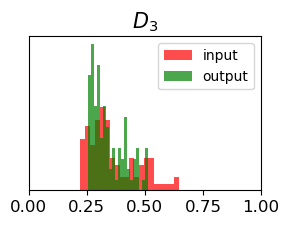

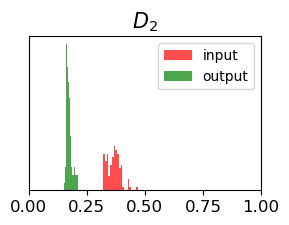

In [45]:
blocks = {'$E_2$': (0,1) , 
          '$E_3$': (1,2), 
          '$E_4$': (2,3), 
          '$M$': (3,4),
          '$D_4$': (3,5),
          '$D_3$': (2,6),
          '$D_2$':(1,7)}
plt.rc('xtick', labelsize=12)       
sig = 50
for b, pairs in blocks.items():
    f, ax = plt.subplots(1,1, figsize = (3,2))
    ax.hist( all_participation_ratio[sig][pairs[0]].cpu() ,alpha = .7, color='red', label = 'input', density=True, bins=20)
    ax.hist( all_participation_ratio[sig][pairs[1]].cpu() ,alpha = .7, color='green', label = 'output', density=True, bins=20 )
    ax.set_title(b, fontsize=15 );
    # ax.set_xlabel('participation ratio', fontsize=15 );
    ax.set_xlim(0,1)
    ax.set_yticks([])
    ax.set_yticks([])    
    ax.legend();
    # plt.savefig('../results/participation_ratios_unet_hist_'+b.split('$')[1]+'_.pdf',bbox_inches='tight')    
    

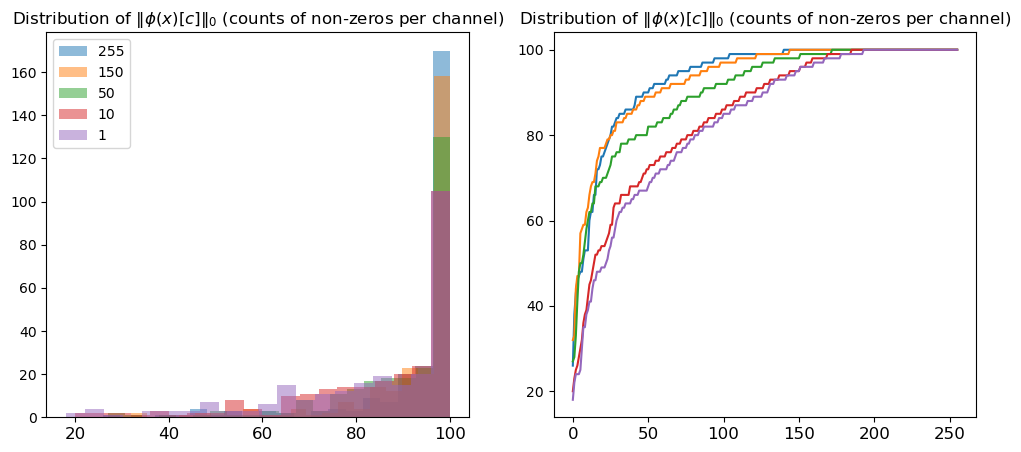

In [48]:
f, axs = plt.subplots(1,2, figsize = (12,5))

for sig in [255, 150, 50, 10, 1]:
    axs[0].hist((all_phis[sig][4]).norm(0, dim = 0).cpu(), alpha = .5, label = sig, bins = 20);
    axs[1].plot((all_phis[sig][4]).norm(0, dim = 0).cpu().sort()[0], label = sig);    
    axs[0].legend()
axs[0].set_title('Distribution of $\Vert \phi(x)[c] \Vert_0$ (counts of non-zeros per channel)')   ;
axs[1].set_title('Distribution of $\Vert \phi(x)[c] \Vert_0$ (counts of non-zeros per channel)')   ;
    

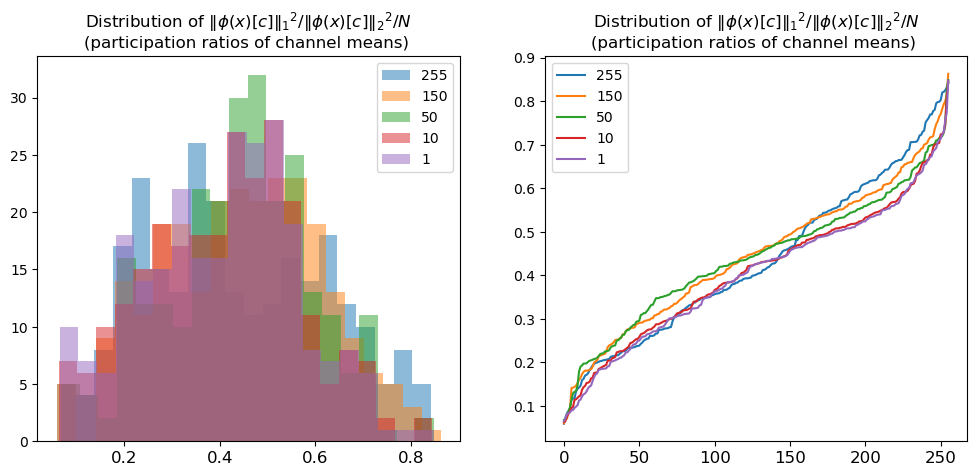

In [50]:
ch_selectivity = {}
f, axs = plt.subplots(1,2, figsize = (12,5))
for sig in [255, 150, 50, 10, 1]:
    # pr=torch.cat(phis[sig]).norm(1, dim = 0).cpu()**2 / torch.cat(phis[sig]).norm(2, dim = 0).cpu()**2/torch.cat(phis[sig]).shape[0]
    ch_selectivity[sig] = participation_ratio_dataset(all_phis[sig][4].T.cpu())
    axs[0].hist(ch_selectivity[sig], alpha = .5, label = sig, bins = 20);   
    axs[1].plot(ch_selectivity[sig].sort()[0], label = sig);    
    
axs[0].legend()
axs[1].legend()
axs[0].set_title('Distribution of ${\Vert \phi(x)[c] \Vert_1}^2/{\Vert \phi(x)[c] \Vert_2}^2/N$ \n(participation ratios of channel means) ')   ;
axs[1].set_title('Distribution of ${\Vert \phi(x)[c] \Vert_1}^2/{\Vert \phi(x)[c] \Vert_2}^2/N$ \n(participation ratios of channel means) ')   ;




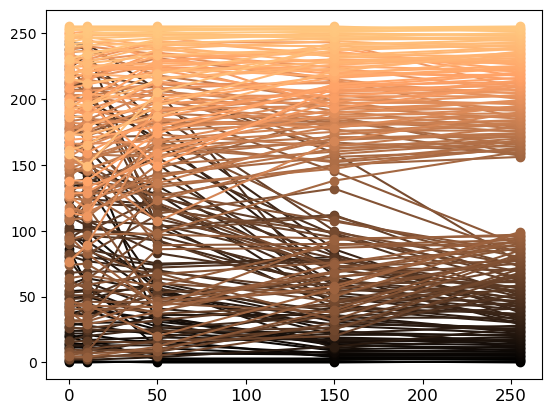

In [85]:
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1,200)]
i = 0
for id in ids_selectivity_sorted[255][0:100]:
    temp = torch.cat([torch.nonzero(ids_selectivity_sorted[sig] == id, as_tuple=False) for sig in [ 1, 10, 50,150,255] ])
    plt.plot([ 0, 10, 50,150,255], temp, '-o', color = plot_colors[i] )
    i += 1
for id in ids_selectivity_sorted[255][-100:]:
    temp = torch.cat([torch.nonzero(ids_selectivity_sorted[sig] == id, as_tuple=False) for sig in [ 1, 10, 50,150,255] ])
    plt.plot([ 0, 10, 50,150,255], temp, '-o', color = plot_colors[i] )
    i += 1
    

In [55]:
# compare distribution of phi for common and specialized channels 
# ch_selectivity=torch.cat(phis[sig]).norm(1, dim = 0).cpu()**2 / torch.cat(phis[sig]).norm(2, dim = 0).cpu()**2/torch.cat(phis[sig]).shape[0]
ch_selectivity = {}
ids_selectivity_sorted = {}
for sig in [255, 150, 50, 10, 1]:
    
    ch_selectivity[sig] = participation_ratio_dataset(all_phis[sig][4].T.cpu())
    ids_selectivity_sorted[sig] = ch_selectivity[sig].sort(descending =True)[1]
    


In [83]:
sig = 50
clean_inp = torch.cat([test_sets[k][0:1] for k in range(len(test_sets)) ]) 
noisy_inp =clean_inp + torch.randn_like(clean_inp) * sig/255
# _ , acts = get_channel_means(denoisers[group], noisy_inp, return_activations=True )
acts = get_activations_unconditional(denoisers[group], noisy_inp, noGrad=True)
acts[4].shape

torch.Size([5, 256, 10, 10])

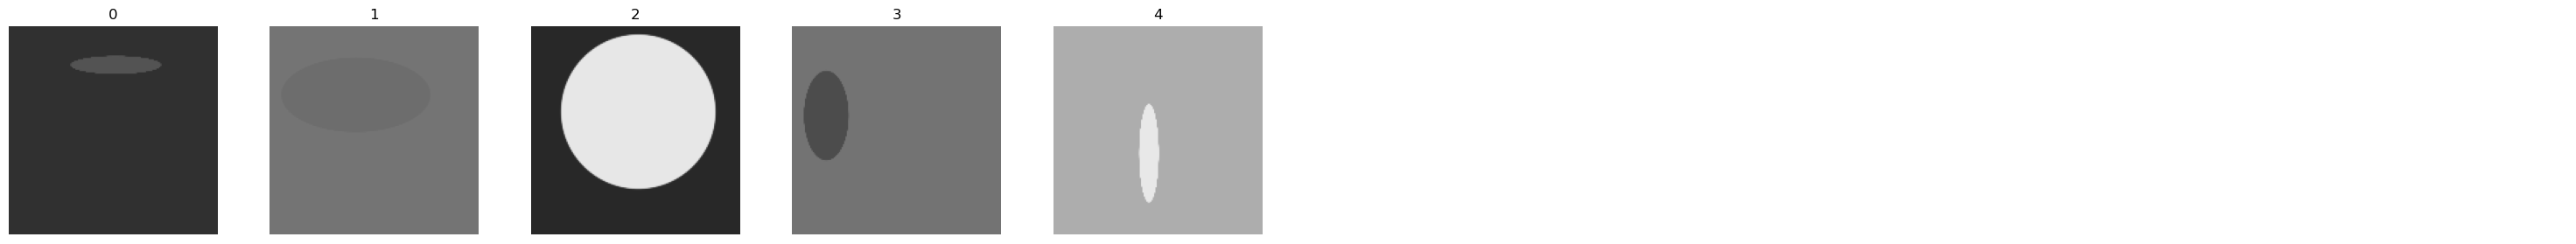

In [62]:
show_im_set(clean_inp, vmin=0, vmax = 1)

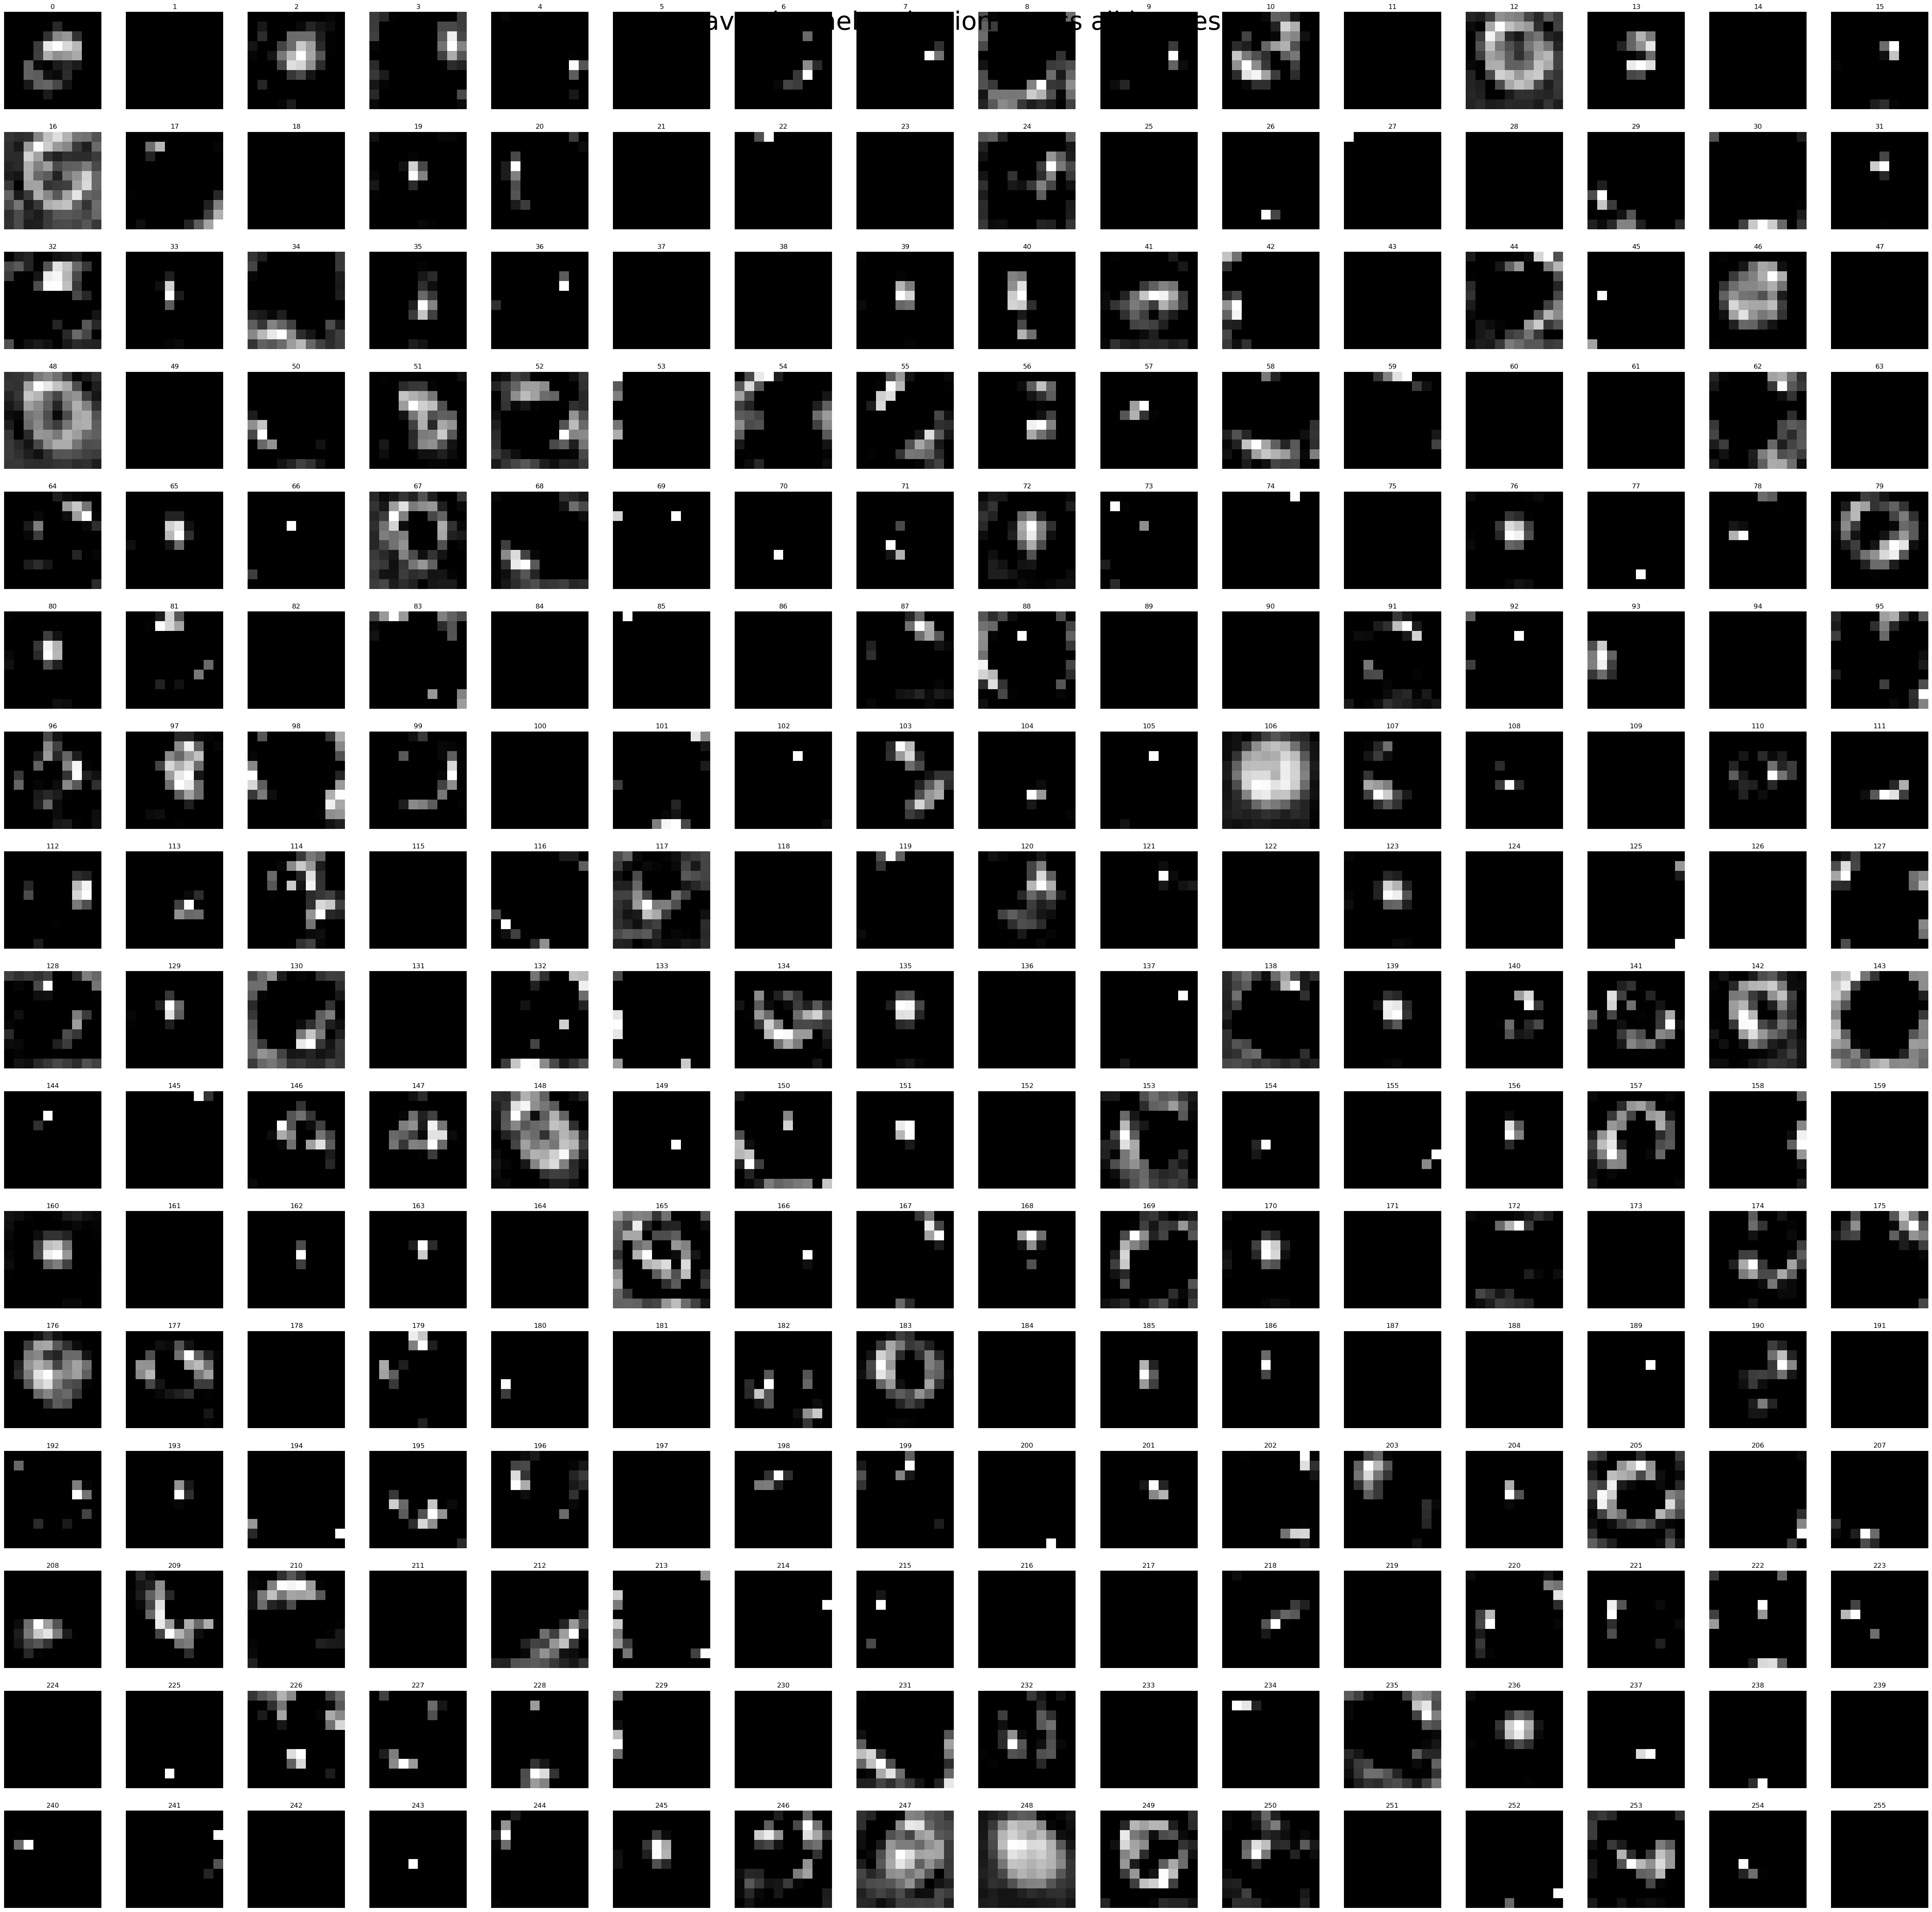

In [84]:
show_im_set(acts[4][2].unsqueeze(1).cpu(), n_columns=16 , 
             label= 'ave channel activation across all images', font_size=30)


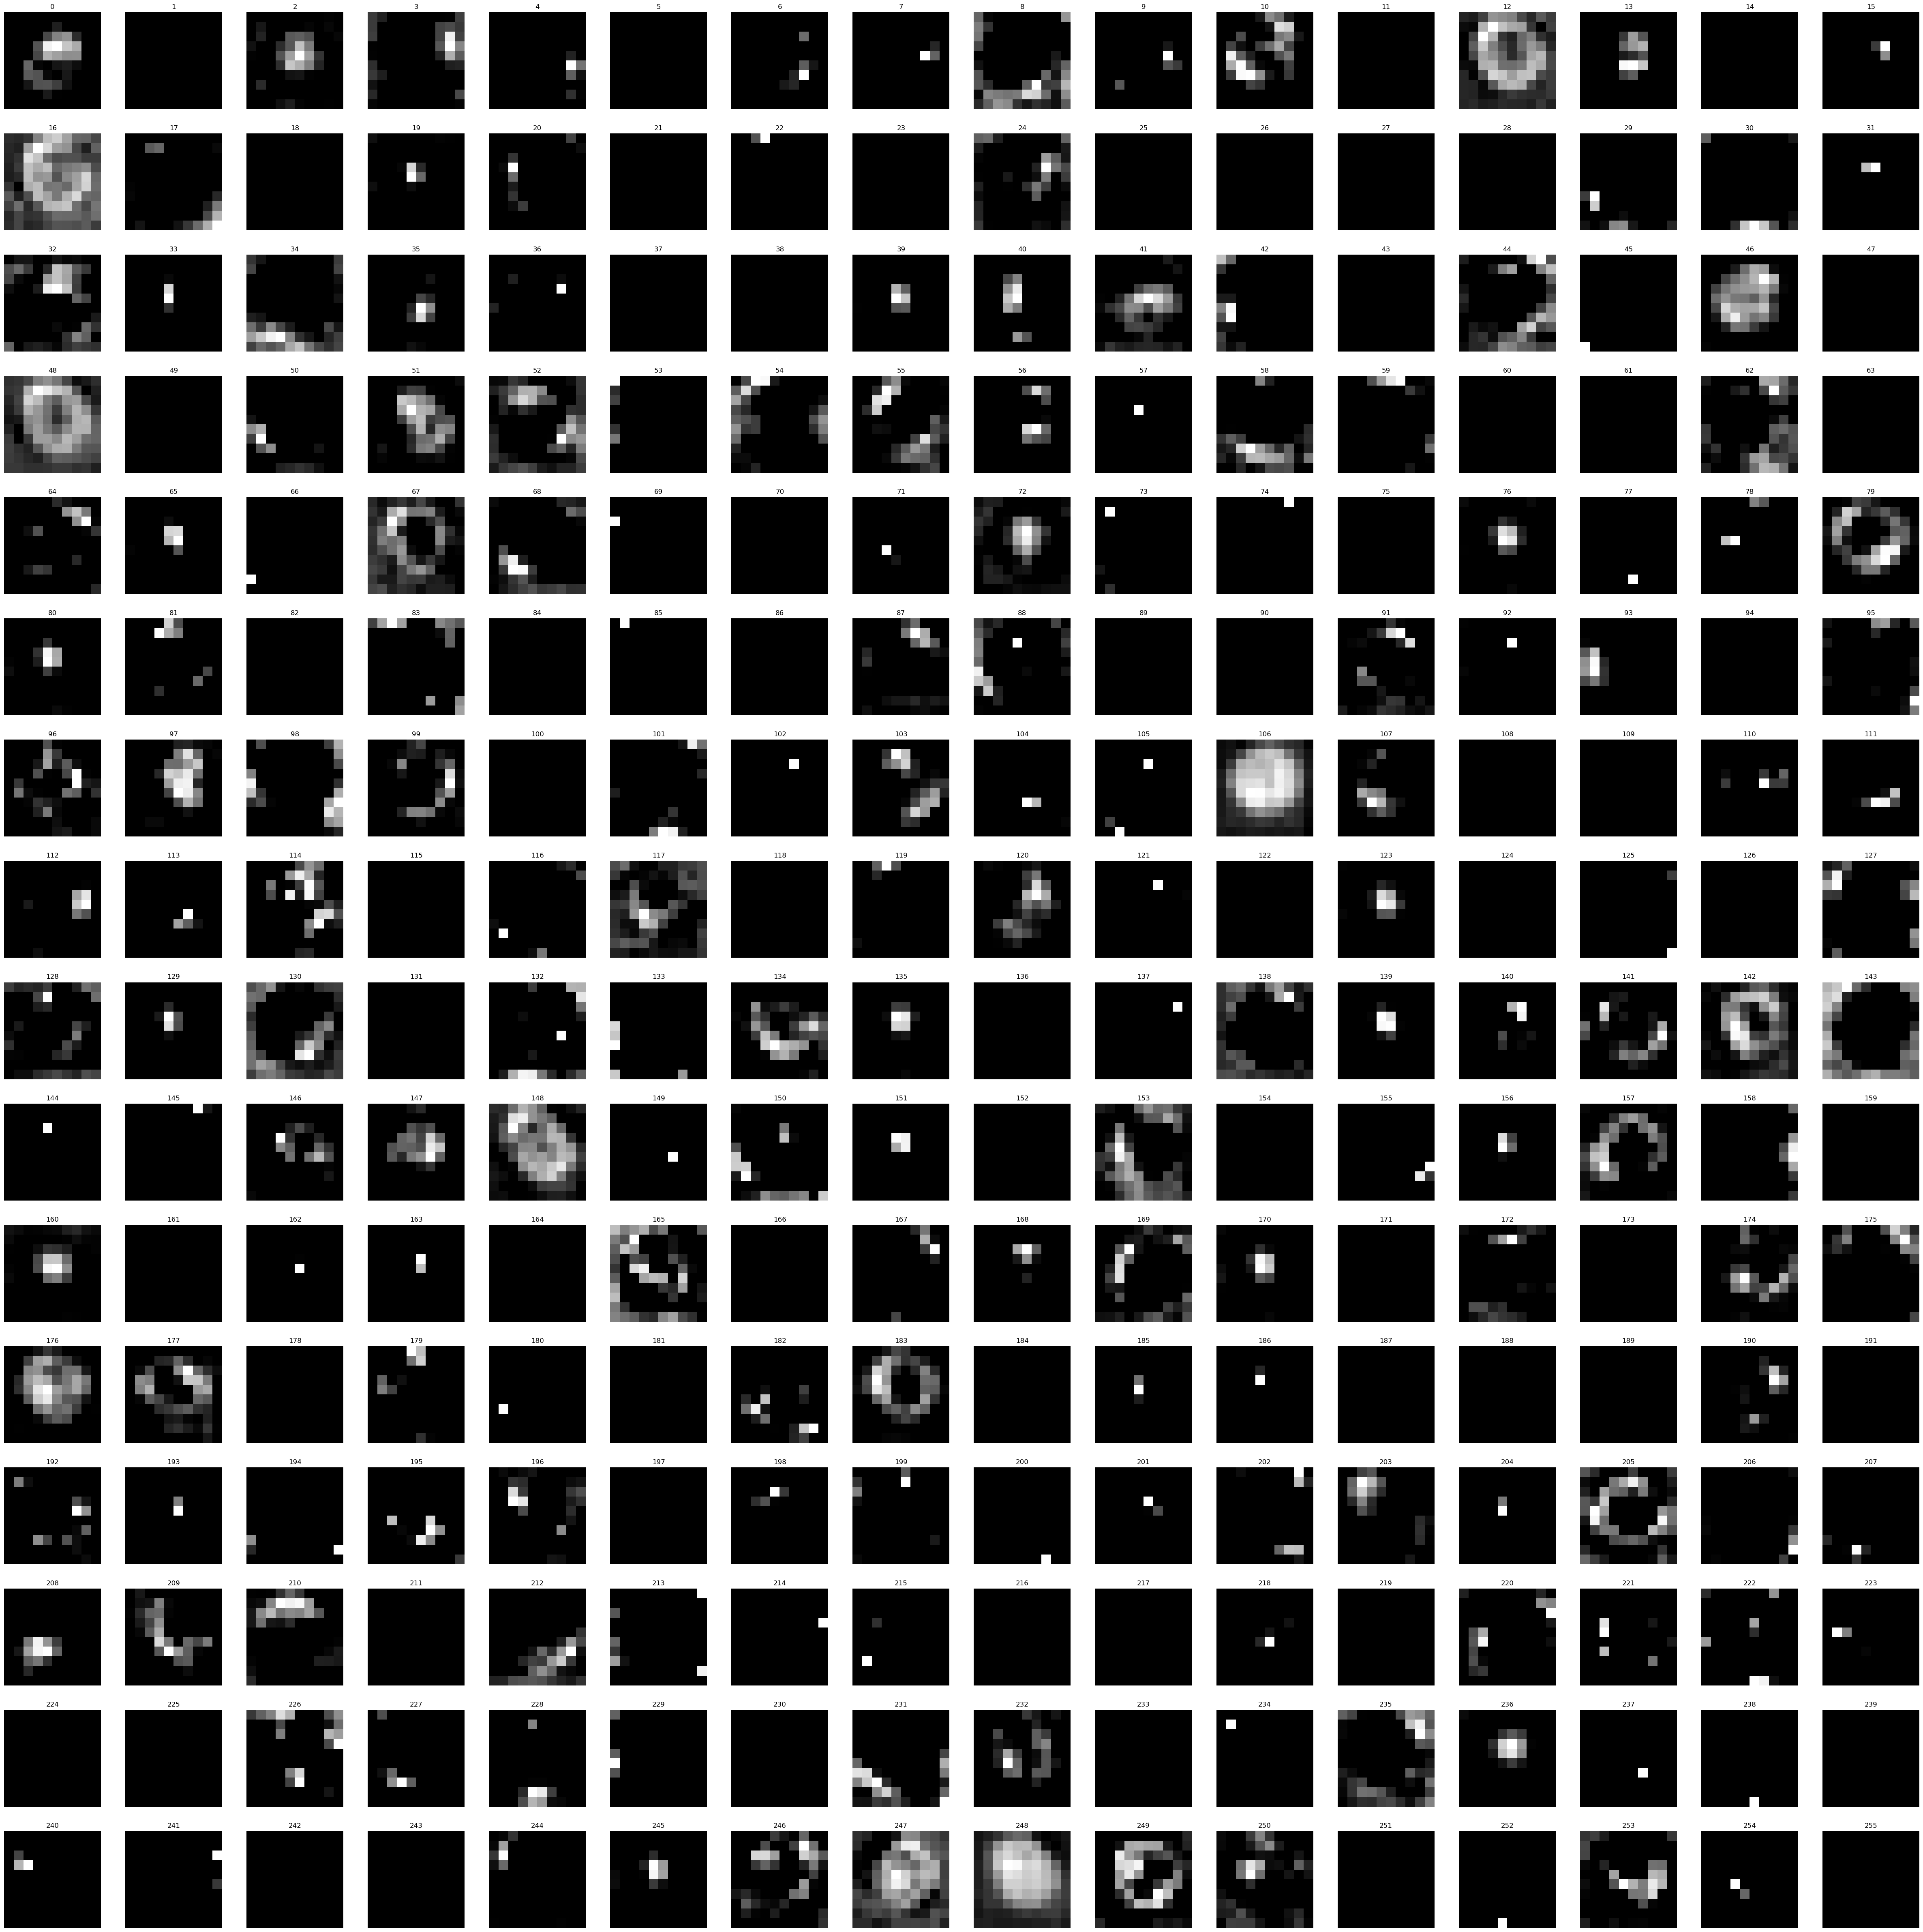

In [77]:
show_im_set(acts[4][2].unsqueeze(1).cpu(), n_columns=16 , font_size=30)


# Sparsity and correlation of $\phi$

## 1. $\phi$ is sparse in mixture and conditional models

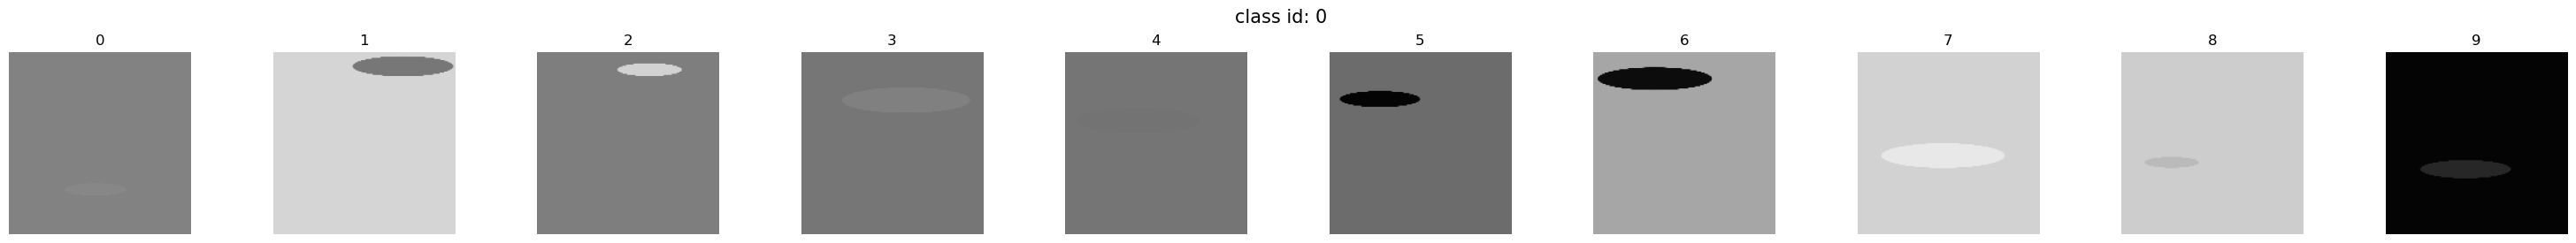

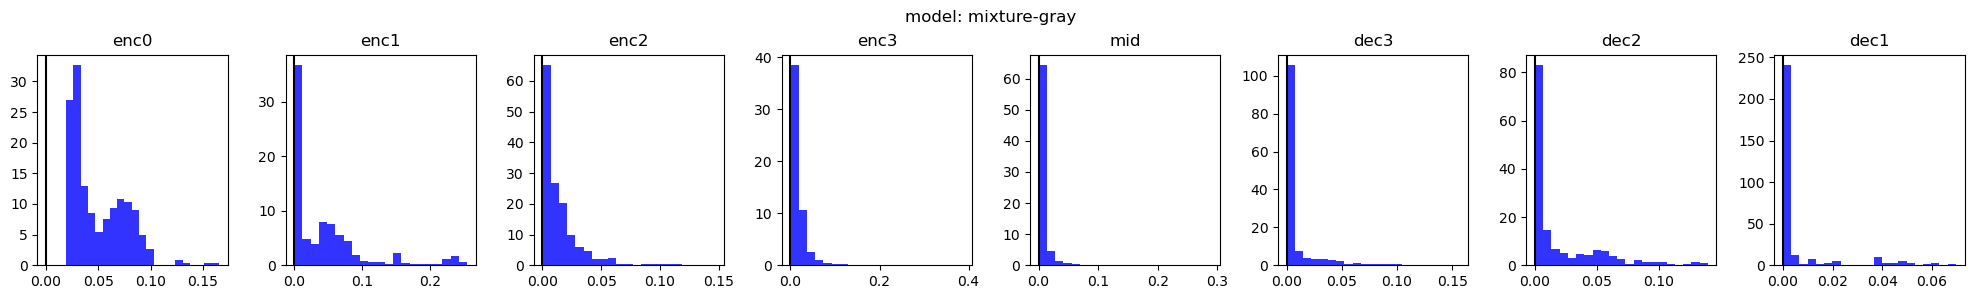

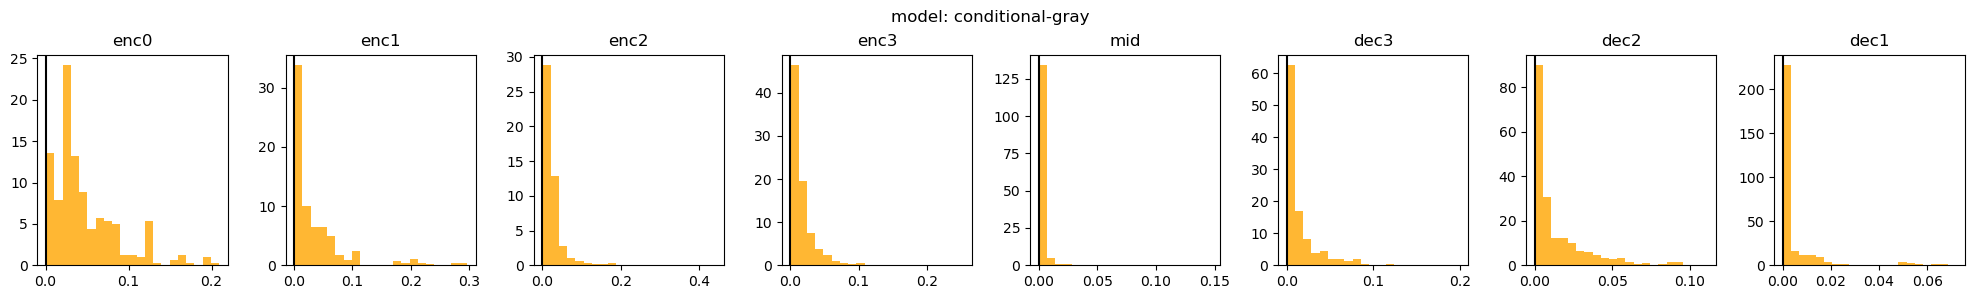

In [25]:
c = 0
im_cond = train_sets[c]
show_im_set(im_cond[0:10],  n_columns=10, label = 'class id: ' + str(c), vmin=0, vmax = 1)

sig = 100 #sigma used for mixture model input
colors = ['blue', 'orange']
for j,group in zip(range(2),['mixture-gray', 'conditional-gray']): 
    im_cond = train_sets[c]

    f , axs = plt.subplots(1,len(blocks), figsize=(20,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)    
    plt.tight_layout()    
    if 'gray' in group:
        im_cond = im_cond.mean(dim = 1, keepdim=True)
    if 'mixture' in group: 
        im_cond = add_noise_torch(im_cond, sig)[0]
    else: 
        im_cond = im_cond
        
    phi = get_channel_means(denoisers[group], im_cond ,average_phi=False, with_params=True)
        
    for i in range(len(blocks)): 
        axs[i].hist( (phi[i].flatten()).cpu().abs() , bins=21, density=True, label = group, alpha = .8, color = colors[j] )
        axs[i].set_title(blocks[i])
        axs[i].axvline(0, color='k')
        


## Pairwise class comparions: in deep layers $\phi$ are correlated for mixture model, but de-correlated for conditional model:

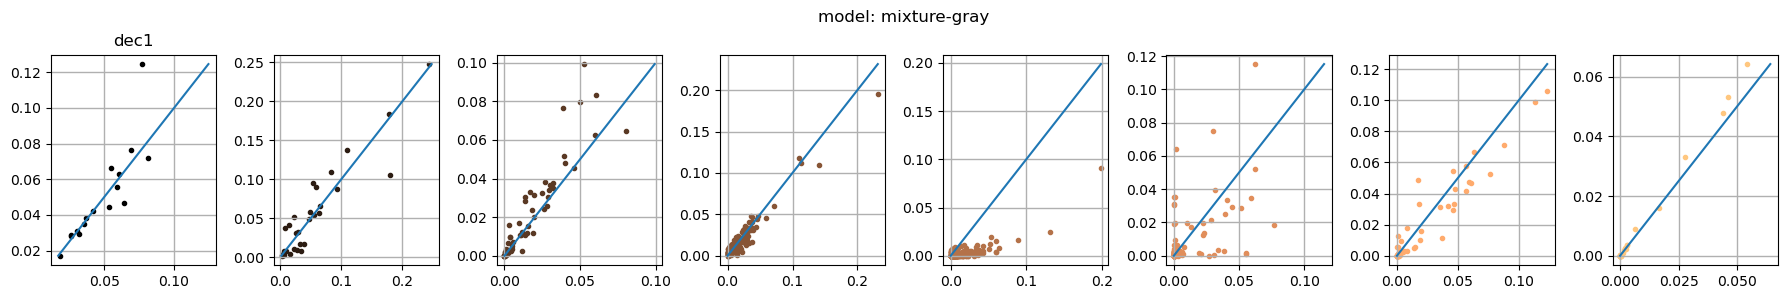

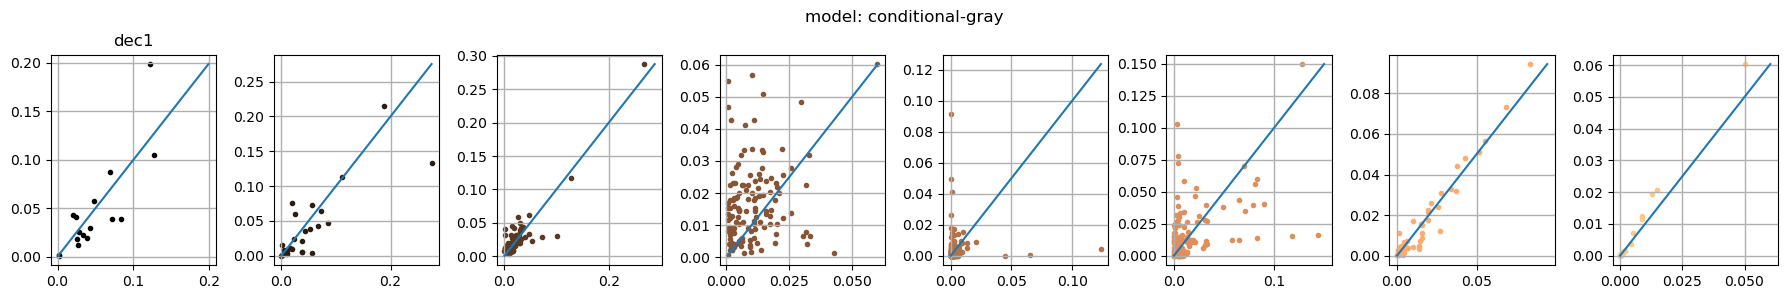

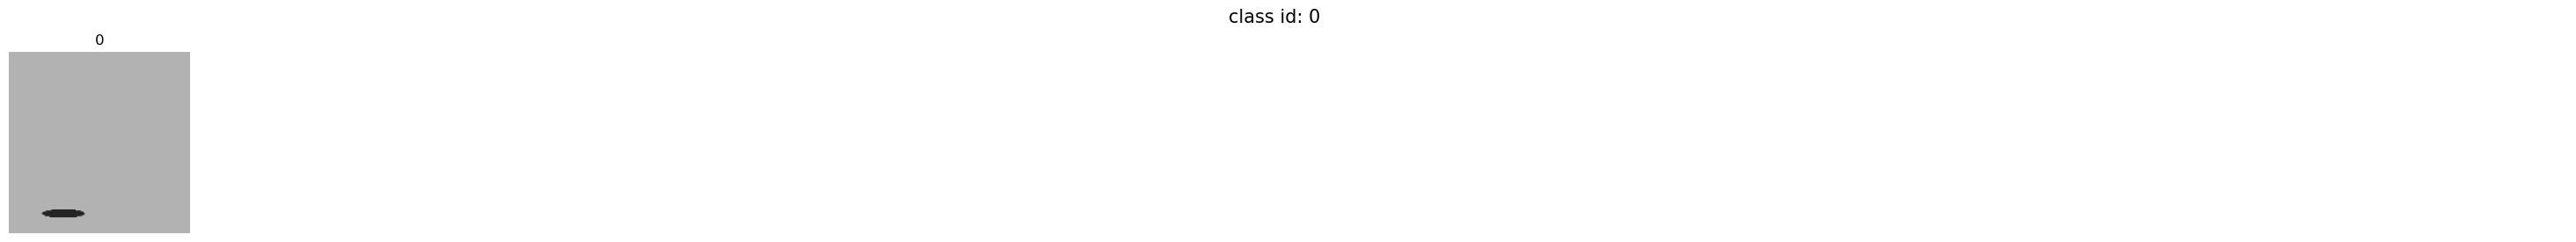

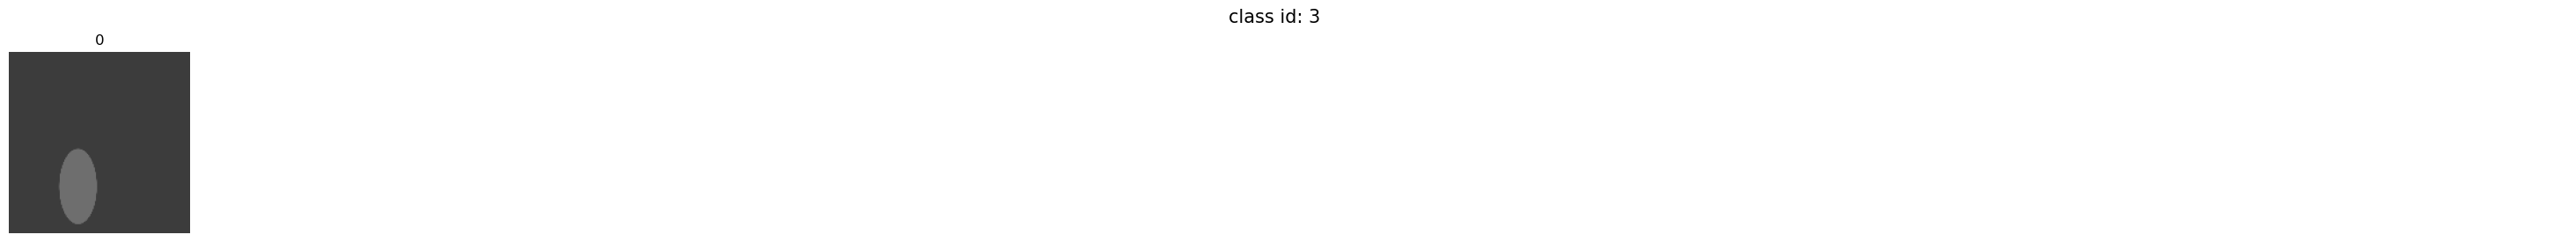

In [18]:
### compare two classes against each other ####
c1 = 0
c2 = 3
sig = 250

for group in ['mixture-gray', 'conditional-gray']:    
    im1_cond = train_sets[c1][1:2]
    im2_cond = train_sets[c2][0:1]    
    if 'gray' in group: 
        im1_cond = im1_cond.mean(dim =1,keepdim=True )
        im2_cond = im2_cond.mean(dim =1, keepdim=True )

    if 'mixture' in group:
        phi_xc, x_c1 = get_channel_means(denoisers[group], add_noise_torch(im1_cond, sig)[0],average_phi=True,with_params=True , return_activations=True)
        phi_2, x_c2 = get_channel_means(denoisers[group], add_noise_torch(im2_cond, sig)[0] ,average_phi=True, with_params=True , return_activations=True)
    else: 
        phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=True,with_params=True , return_activations=True)
        phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=True, with_params=True , return_activations=True)
        
    f , axs = plt.subplots(1,len(blocks), figsize=(18,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)
    plt.tight_layout()
    axs = axs.ravel()
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]
    for i in range(len(blocks)): 
        axs[i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[0].set_title(blocks[i])
        axs[i].grid(  linewidth=1);
        axs[i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])

show_im_set(im1_cond[0:10],  n_columns=10, label = 'class id: ' + str(c1), vmin=0, vmax = 1)
show_im_set(im2_cond[0:10], n_columns=10,  label = 'class id: ' + str(c2),vmin=0, vmax = 1)


## visualization of non-zero channels

### conditional model: 

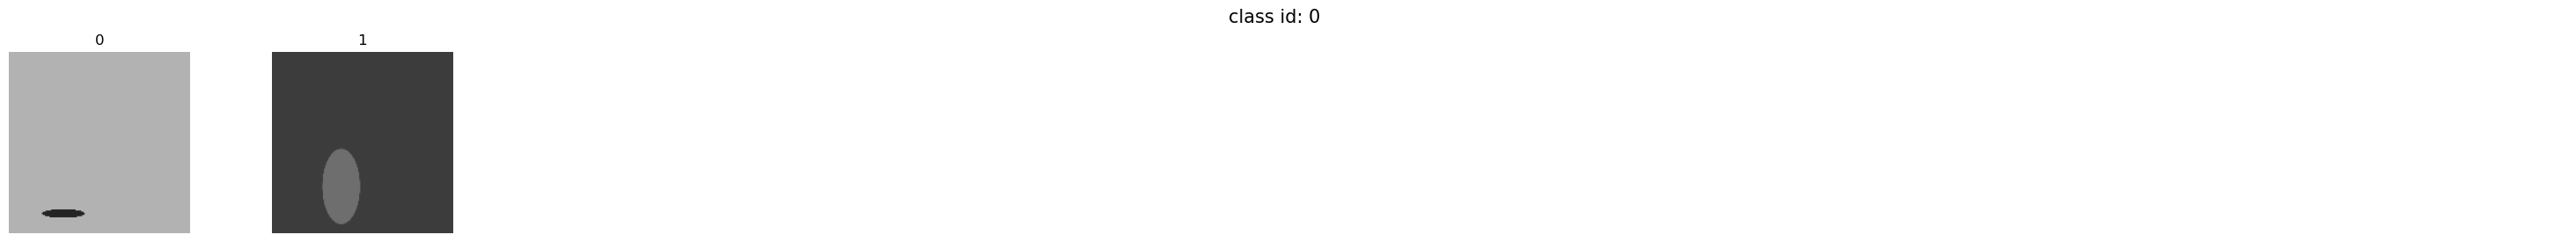

[ 42 149 109  59 117 106 250 196 182 251  49 153 218 148 255 137 130 167
  48 242]
[161  91  23 138  11 206 250 134 137 252  39 251 120  59  36 196 117 243
 203 193]


In [20]:
### for the conditional model 
group = 'conditional-gray'
    
show_im_set( torch.vstack([im1_cond, im2_cond]),  n_columns=10, label = 'class id: ' + str(c1), vmin=0, vmax = 1)
        
phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)

block = 4
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

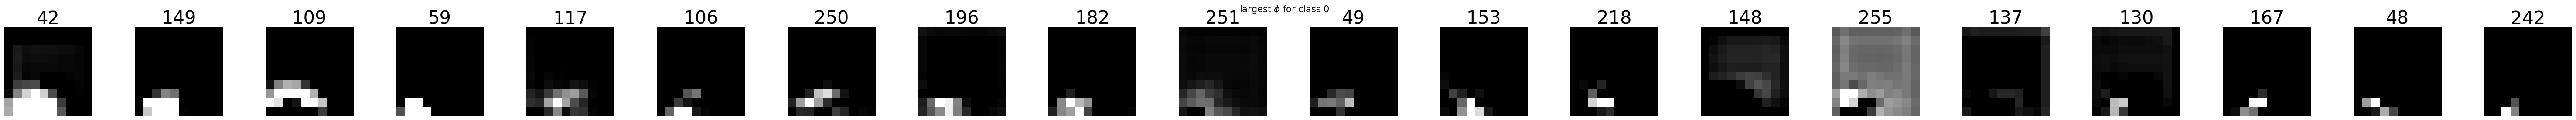

largest $\phi$ for class 0


In [21]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

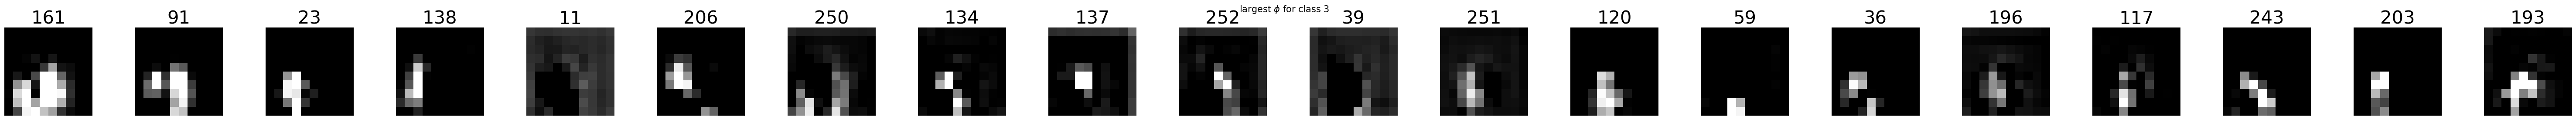

largest $\phi$ for class 3


In [22]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

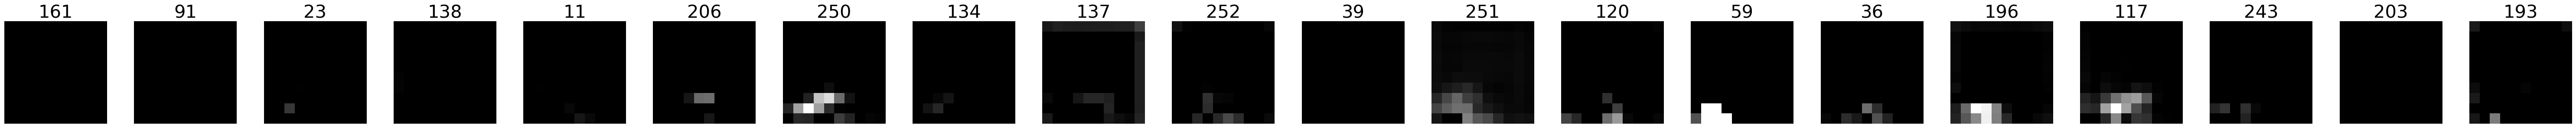

channels of image 0 for largert $\phi$ of image 3


In [23]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

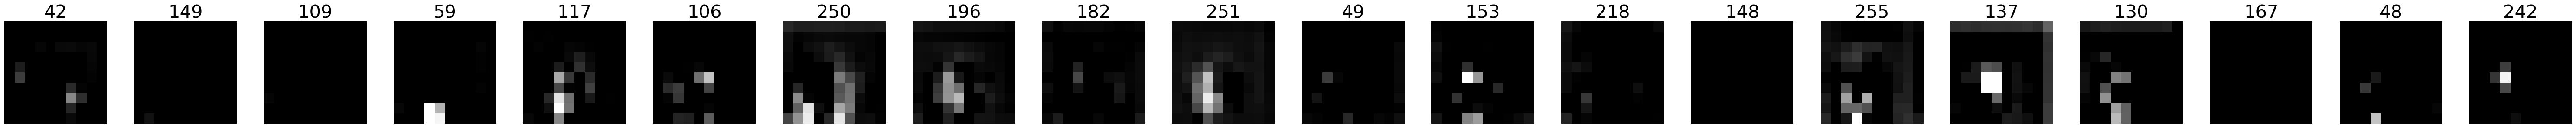

channels of image 3 for largert $\phi$ of image 0


In [24]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+ ' for largert $\phi$ of image ' + str(c1) )

### mixture model: 

In [25]:
### for the mixture model 
group = 'mixture-gray'
sig = 100
phi_xc, x_c1 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im1_cond,noise_level=sig)[0],
                                average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im2_cond,noise_level=sig)[0],
                                average_phi=False, with_params=True , return_activations=True)

block = 4
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

[106 143  24 133  52 253 130   3  50 155 138  36 165  88   5 235  97 247
  83 128]
[106 143  54 161  79  24 179   8 177   6  35 235 205 244   3 192 138  99
  59  93]


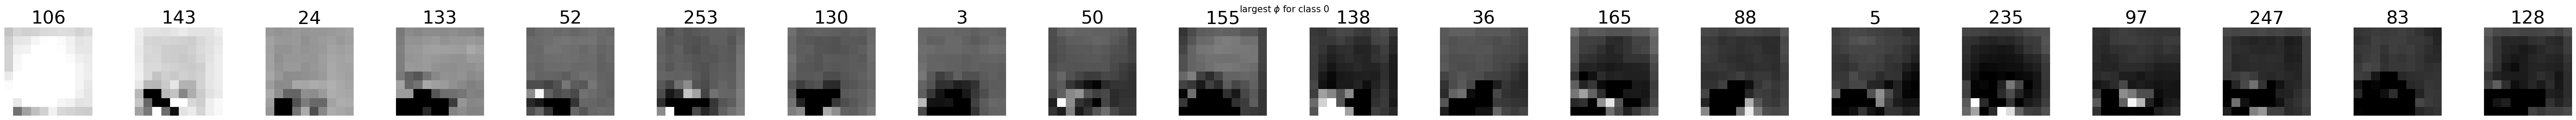

largest $\phi$ for class 0


In [26]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

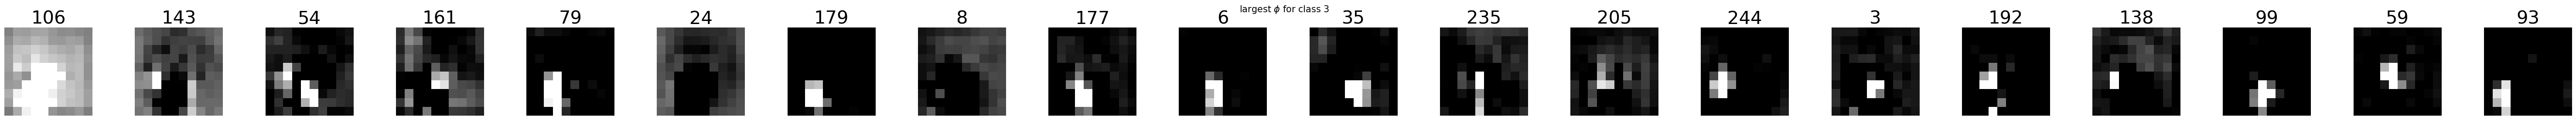

largest $\phi$ for class 3


In [27]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

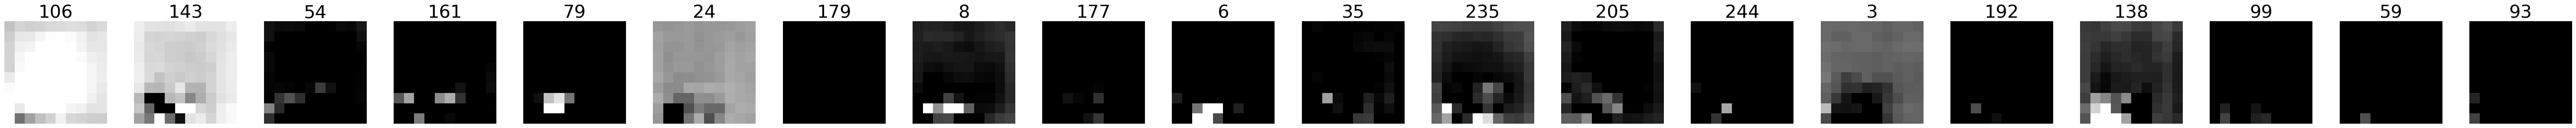

channels of image 0 for largert $\phi$ of image 3


In [28]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

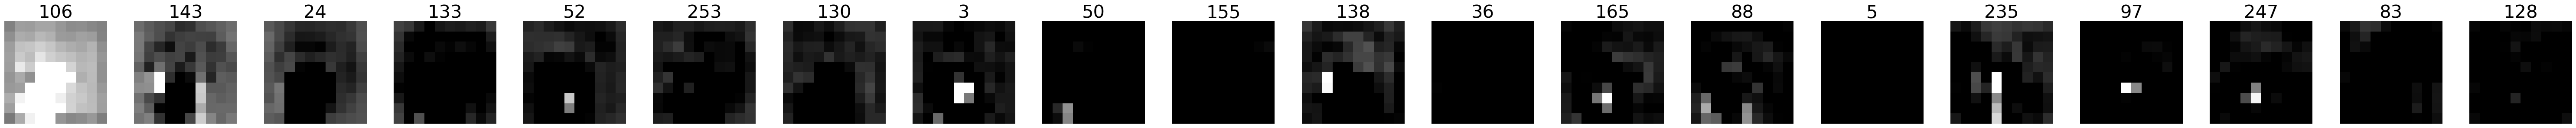

channels of image 3 for largert $\phi$ of image 0


In [29]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+' for largert $\phi$ of image ' + str(c1) )

## 3. Sparsity of many classes: Soft measure of dimensionality
## Participation ratio 

${||\phi_c||_1^2}/{||\phi_c||_2^2} / N$

In [78]:
### compute phi's for a bunch of images from diffrent classes 

start_time_total = time.time()        

all_phi_x  = {}
all_phi_c = {}

for group in groups: 
    all_phi = []
    ### compute phi_x and phi_c for all classes 
    for c in range(0,len(train_sets) ):     
        if 'color' in group.split('-'):
            im_cond = train_sets[c]    
        else: 
            im_cond = train_sets[c].mean(dim = 1, keepdim = True)    
            
        phi, x_c = get_channel_means(denoisers[group], im_cond, average_phi=False, with_params=True, return_activations=True)
        
        all_phi.append(torch.hstack(phi).squeeze())
        if c%100 == 0:
            print('class id#:',c, "--- %s seconds ---" % (time.time() - start_time_total))
        
    all_phi_x[group] = torch.stack(all_phi).cpu()
    all_phi_c[group] = all_phi_x[group].mean(dim=1,keepdim=True)
    
    print(all_phi_x[group].shape)


class id#: 0 --- 0.006243228912353516 seconds ---
torch.Size([5, 20, 720])
class id#: 0 --- 0.05660605430603027 seconds ---
torch.Size([5, 20, 720])


--------- model:  mixture-gray
average participation ratio for $\phi(x)$ :  0.2056436538696289
--------- model:  conditional-gray
average participation ratio for $\phi(x)$ :  0.23645079135894775
--------- model:  mixture-gray
average participation ratio for $\phi_c$ :  0.24517738819122314
--------- model:  conditional-gray
average participation ratio for $\phi_c$ :  0.26498761773109436


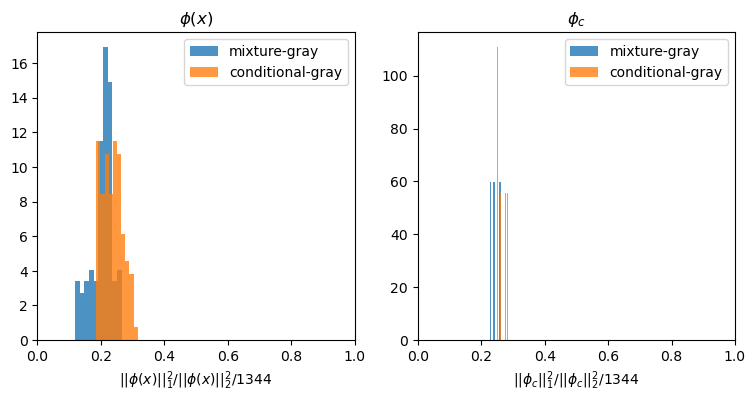

In [81]:
f, axs = plt.subplots(1,2, figsize = (9,4) )
for group in ['mixture-gray', 'conditional-gray']: 
    print('--------- model: ', group)
    participation_ratio = (all_phi_x[group].norm(1,dim = 2).squeeze()**2 /all_phi_x[group].norm(2,dim = 2, keepdim=True).squeeze()**2)/all_phi_x[group].shape[2]
    axs[0].hist(participation_ratio.flatten(), density=True, label = group, alpha = .8)
    print(r'average participation ratio for $\phi(x)$ : ', participation_ratio.mean().item())
    axs[0].set_xlim(0,1);
    axs[0].set_xlabel('$||\phi(x)||_1^2 / ||\phi(x)||_2^2 / 1344$');
    axs[0].set_title(r'$\phi(x)$')
    axs[0].legend();
for group in ['mixture-gray', 'conditional-gray']: 
    print('--------- model: ', group)
    participation_ratio = (all_phi_c[group].norm(1,dim = 2).squeeze()**2 /all_phi_c[group].norm(2,dim = 2, keepdim=True).squeeze()**2)/all_phi_c[group].shape[2]
    axs[1].hist(participation_ratio.flatten(), density=True, label = group, alpha = .8)
    print(r'average participation ratio for $\phi_c$ : ', participation_ratio.mean().item())
    axs[1].set_xlim(0,1);
    axs[1].set_xlabel('$||\phi_c||_1^2 / ||\phi_c||_2^2 / 1344$');
    axs[1].set_title(r'$\phi_c$')
    axs[1].legend();    

In [84]:
all_phi_x['mixture-gray'].shape

torch.Size([5, 20, 720])

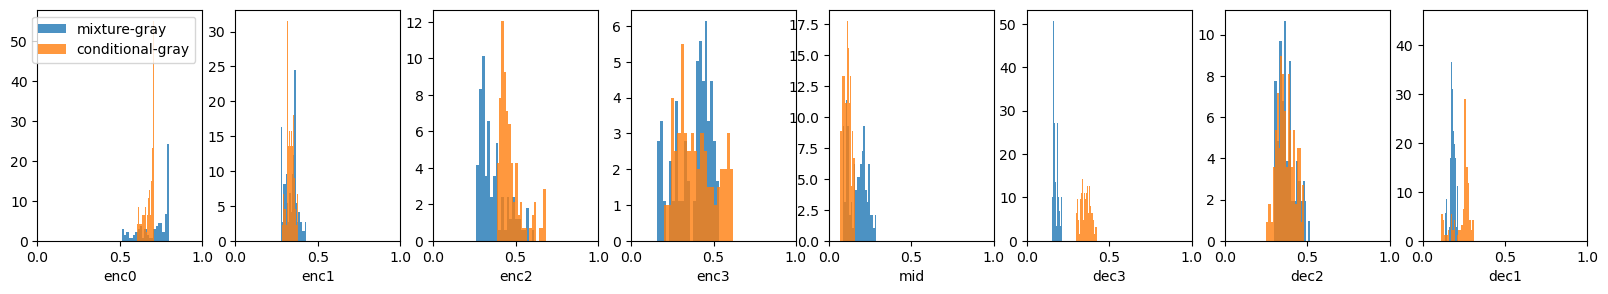

In [86]:
# participatino ratio per block 

f, axs = plt.subplots(1,len(blocks), figsize = (20,3) )

for  group in['mixture-gray', 'conditional-gray']: 
    k1 = 0
    
    for i, l in zip(range(len(blocks)), [16, 32,64,128, 256, 128, 64, 32]): 
        participation_ratio = (all_phi_x[group][:,:,k1:k1 + l].norm(1,dim = 2).squeeze()**2 /all_phi_x[group][:,:,k1:k1 + l].norm(2,dim = 2, keepdim=True).squeeze()**2 ) /l
        axs[i].hist(participation_ratio.flatten(), bins = 21, alpha = .8, density=True, label = group)
        axs[i].set_xlim(0,1);
        axs[i].set_xlabel(blocks[i]  )
        axs[0].legend()
        k1 += l 



## 4. correlation of $\phi$ as a function of change in manifold variables

In [15]:

def interpolated_conditioner(var,n=21): 
    width = 60
    height = 60
    fg_intensity = .7
    bg_intensity = .2
    c1 = 0 
    c2 = 0
    ovalsH = []


    if var == 'width': 
        height = 100        
        ws = torch.linspace(height ,height * .5,n)  
        for i in range(n): 
            width =  ws[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    if var == 'height': 
        width = 100
        hs = torch.linspace(width ,width * .2,n)    
        for i in range(n): 
            height = hs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    if var == 'aspect_ratio': 
        ws = torch.linspace(10,100,n)
        hs = ws.flip(dims = (0,))        
        
        for i in range(n): 
            width =  ws[i]
            height = hs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)


    elif var == 'bg_intensity':     
        bgs = torch.linspace(0,fg_intensity-.05,n)  
        for i in range(n): 
            bg_intensity = bgs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'fg_intensity':     
        fgs = torch.linspace(bg_intensity+.05,1,n)  
        for i in range(n): 
            fg_intensity = fgs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
    
    elif var == 'fg_bg_intensities': 
        fgs = torch.linspace(0,1,n)  
        bgs = fgs.flip(dims = (0,))         
        for i in range(n): 
            fg_intensity = fgs[i]
            bg_intensity = bgs[i]            
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    elif var == 'h_translation':        
        c1s = torch.linspace(-  (160 - 60)/160 , (160 - 60)/160 ,n) 
        for i in range(n): 
            c1 = c1s[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'v_translation': 
        c2s = torch.linspace(-  (160 - 60)/160 , (160 - 60)/160 ,n) 
        for i in range(n): 
            c2 = c2s[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'oval_size': 
        ss = torch.linspace(.1, 2, n)
        for i in range(n): 
            s = ss[i]
            oval_tensor = generate_oval(width=width*s, height=height*s, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    return torch.stack(ovalsH).unsqueeze(1)
    #### plot

def plot_phi_corr(im_cond, sig=0): 
    for group in ['mixture-gray','conditional-gray' ]:
        if 'gray' in group.split('-'): 
            im_cond = im_cond.mean(dim = 1, keepdim = True)
        if 'mixture' in group: 
            phi_xc = get_channel_means(denoisers[group], add_noise_torch(im_cond, sig)[0],average_phi=False,with_params=True , return_activations=False)
        else: 
            phi_xc = get_channel_means(denoisers[group], im_cond,average_phi=False,with_params=True , return_activations=False)

        
        f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
        plt.suptitle(group)
        for block in range(len(blocks)): 
            axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
            axs[block].tick_params(bottom=False,top = False, right = False, left=False)
            axs[block].set_xticks([])  
            axs[block].set_yticks([])      
            axs[block].set_title(blocks[block])
        plt.tight_layout()
        
    show_im_set(im_cond, n_columns=len(im_cond), vmin=0, vmax = 1)


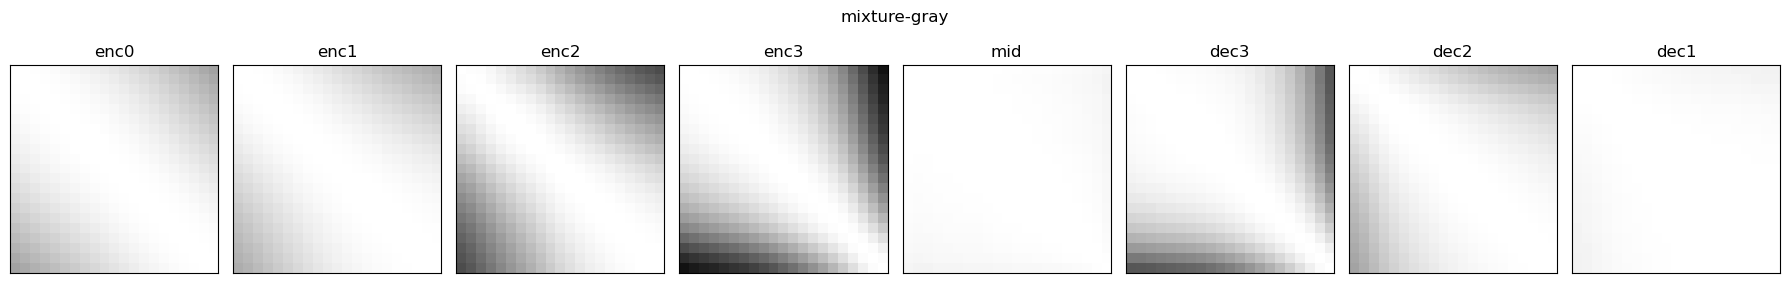

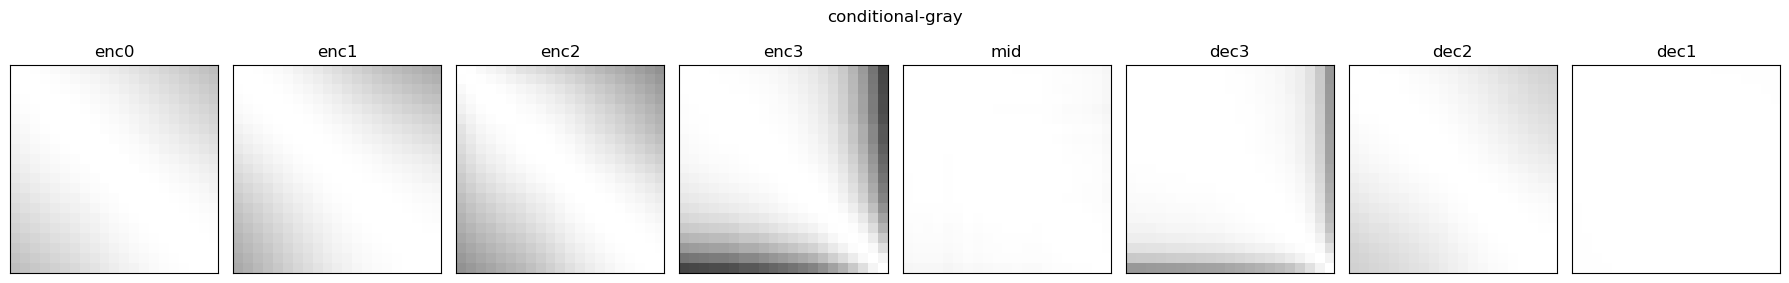

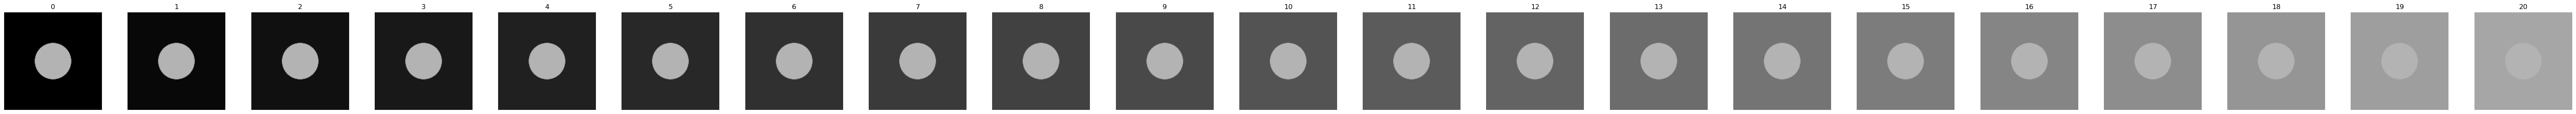

In [31]:
plot_phi_corr(interpolated_conditioner('bg_intensity', n= 21 ) )

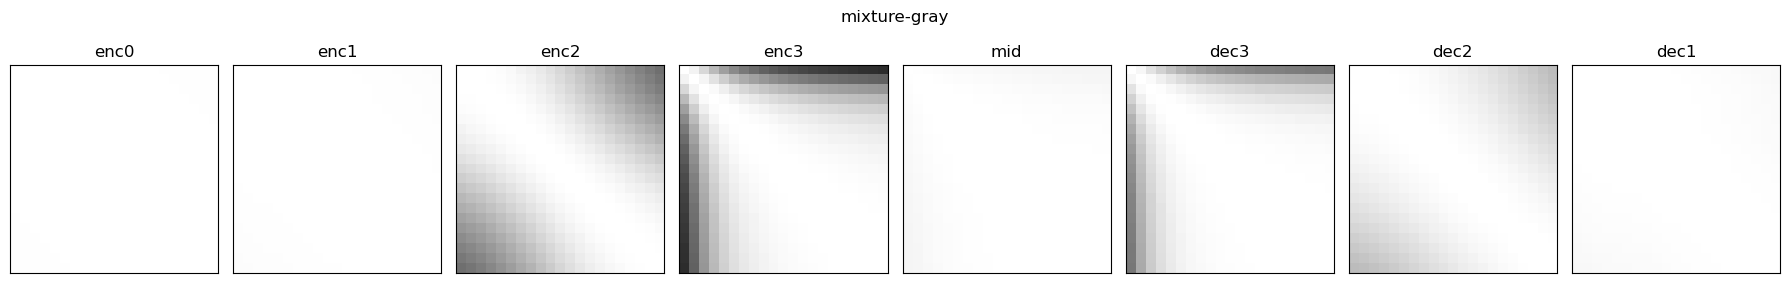

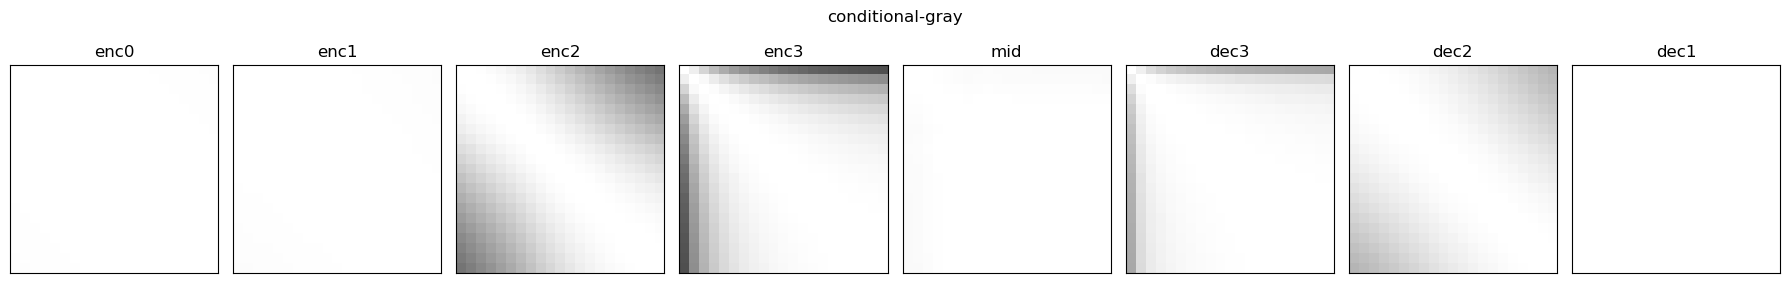

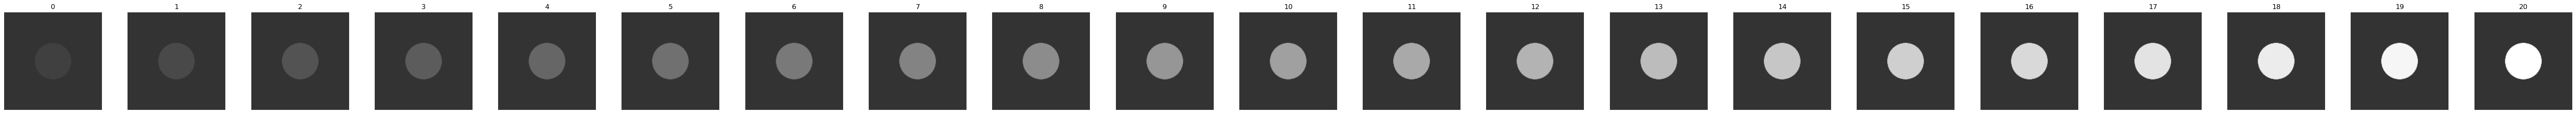

In [32]:
plot_phi_corr(interpolated_conditioner('fg_intensity', n= 21 ) )

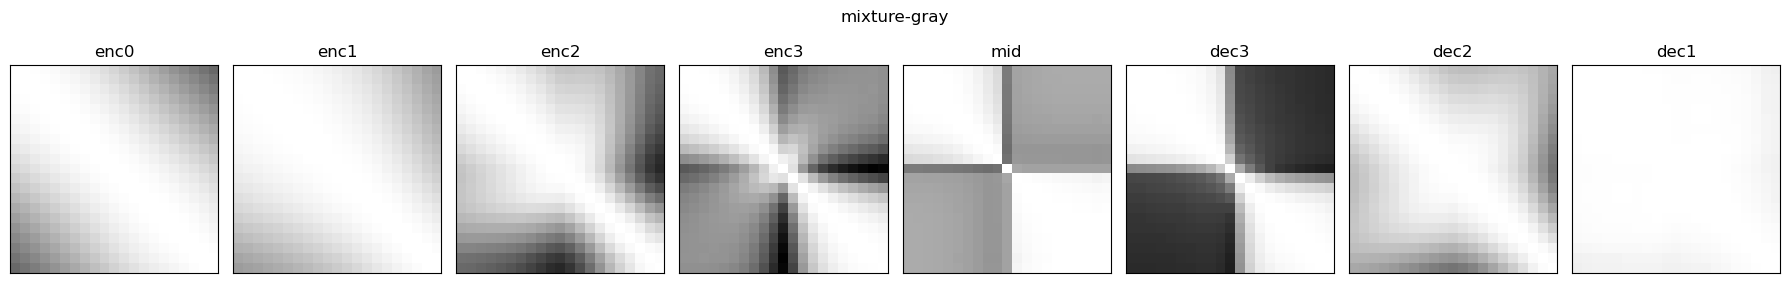

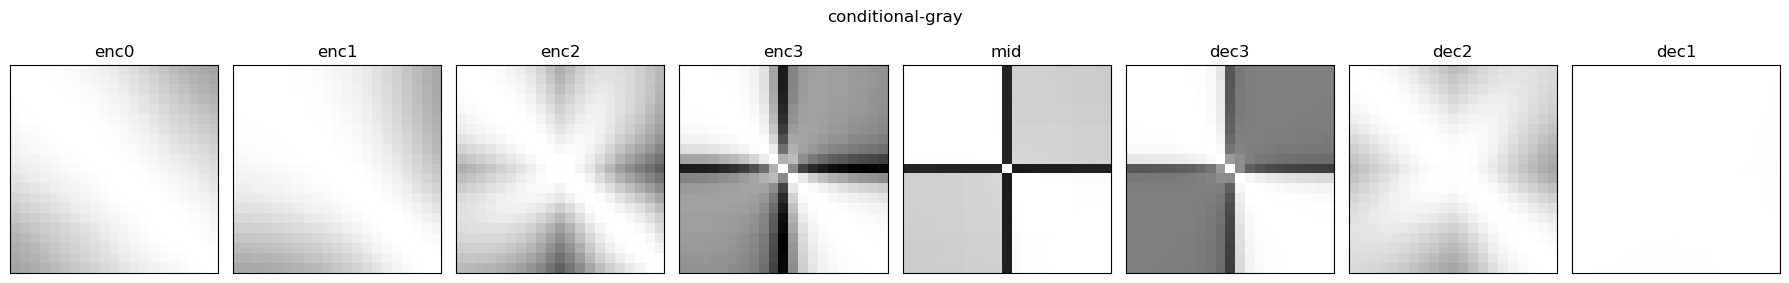

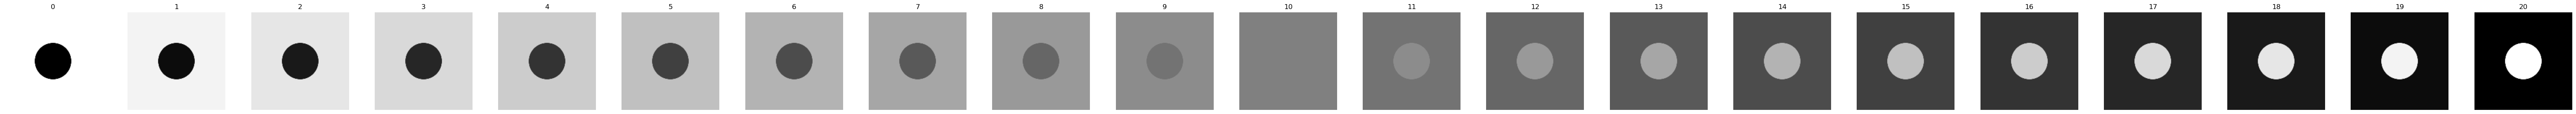

In [33]:
plot_phi_corr(interpolated_conditioner('fg_bg_intensities', n= 21 ) )

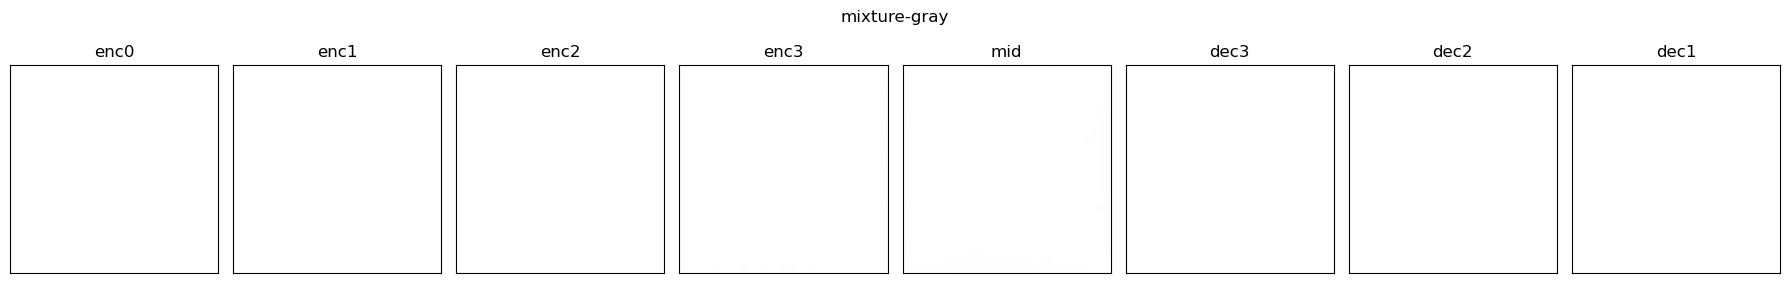

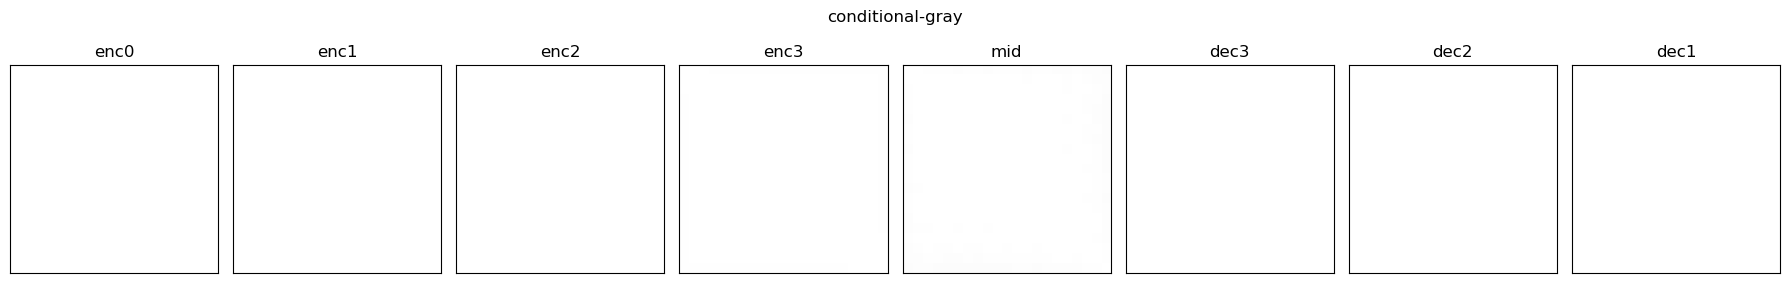

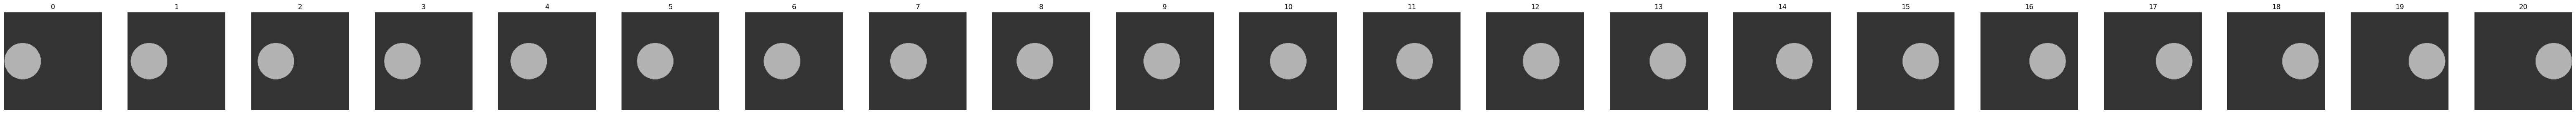

In [34]:
plot_phi_corr(interpolated_conditioner('h_translation', n= 21 ) )

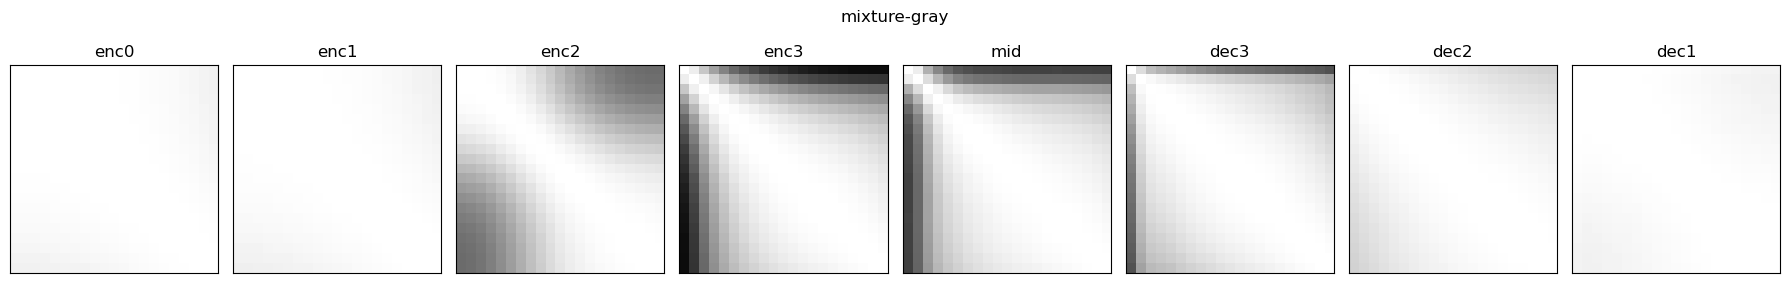

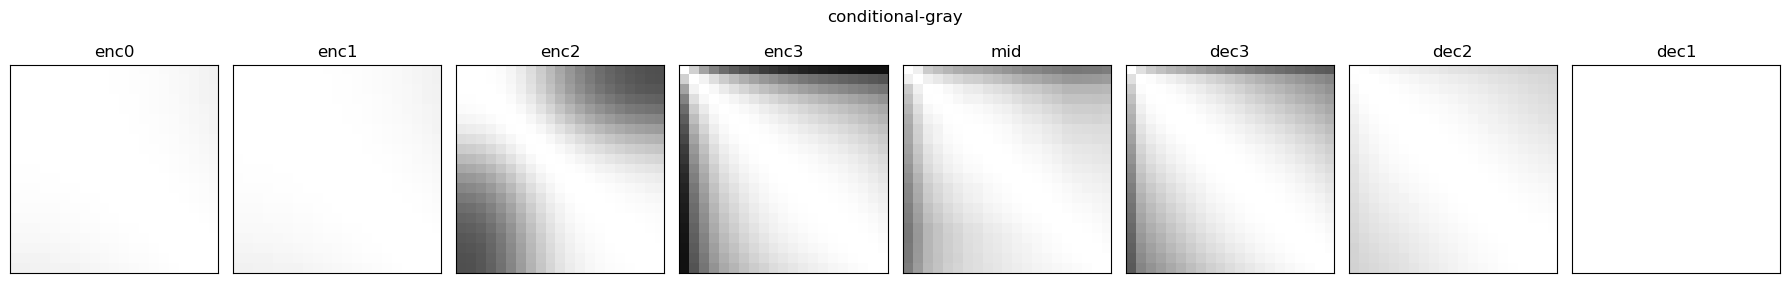

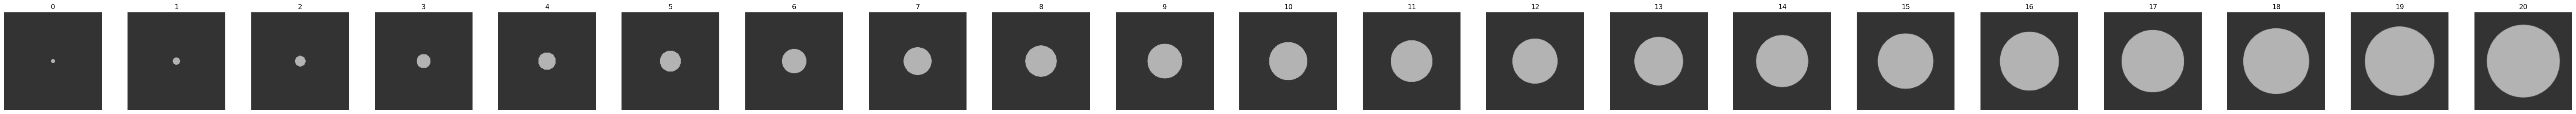

In [35]:
plot_phi_corr(interpolated_conditioner('oval_size', n= 21 ) , sig=0)

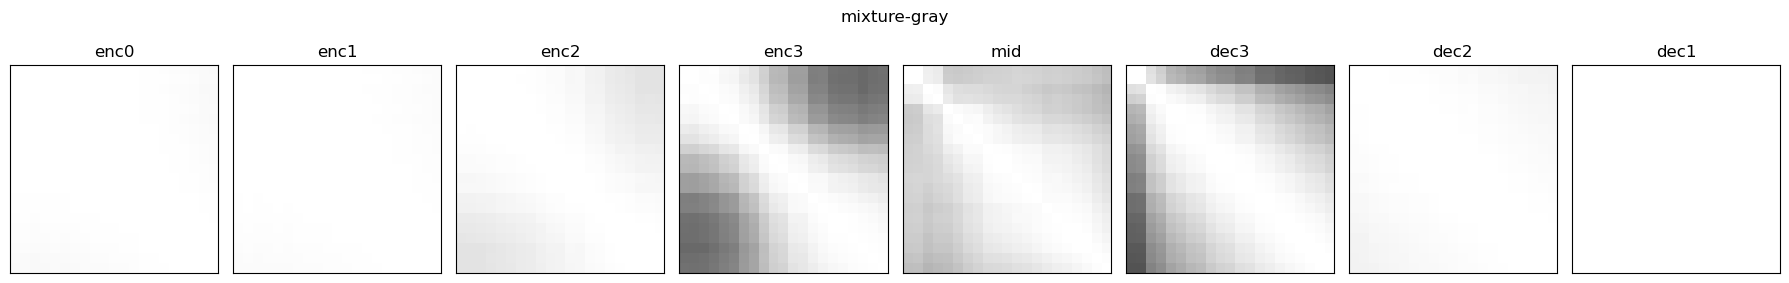

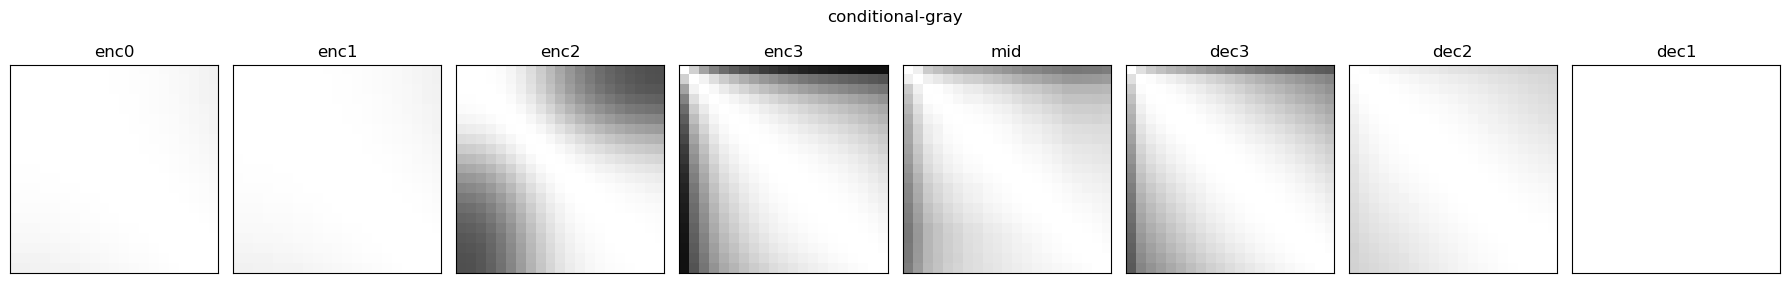

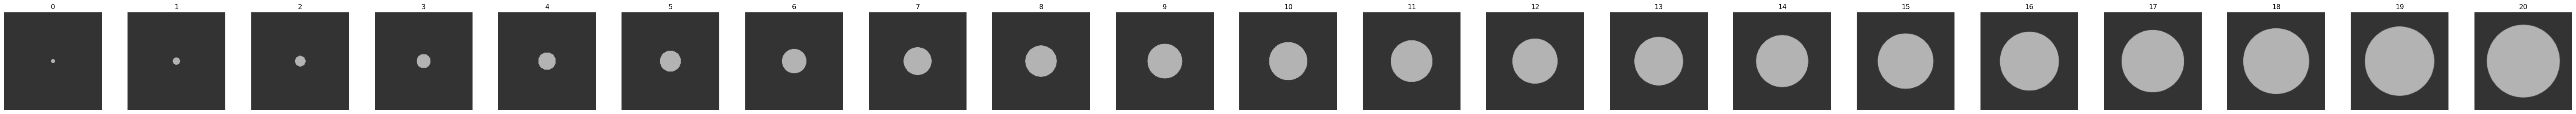

In [36]:
plot_phi_corr(interpolated_conditioner('oval_size', n= 21 ) , sig=250)

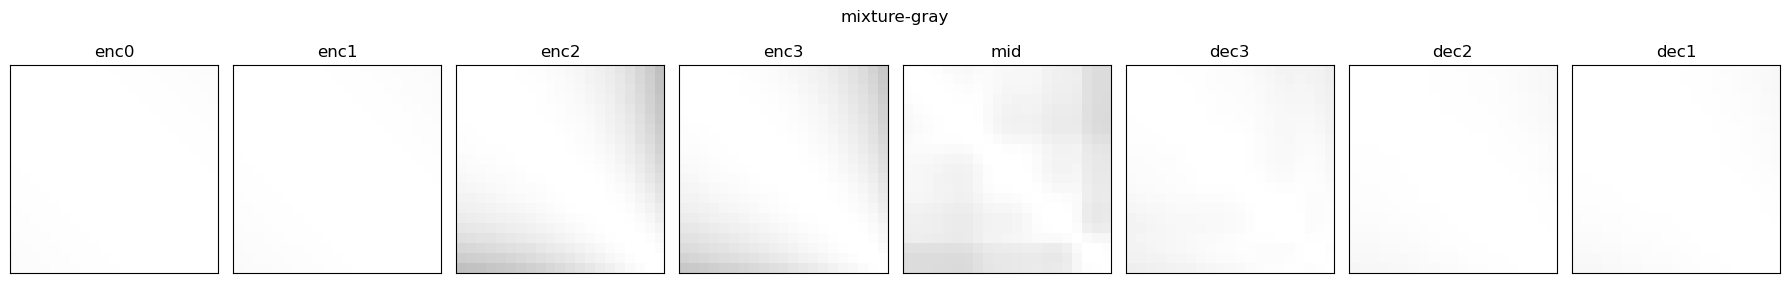

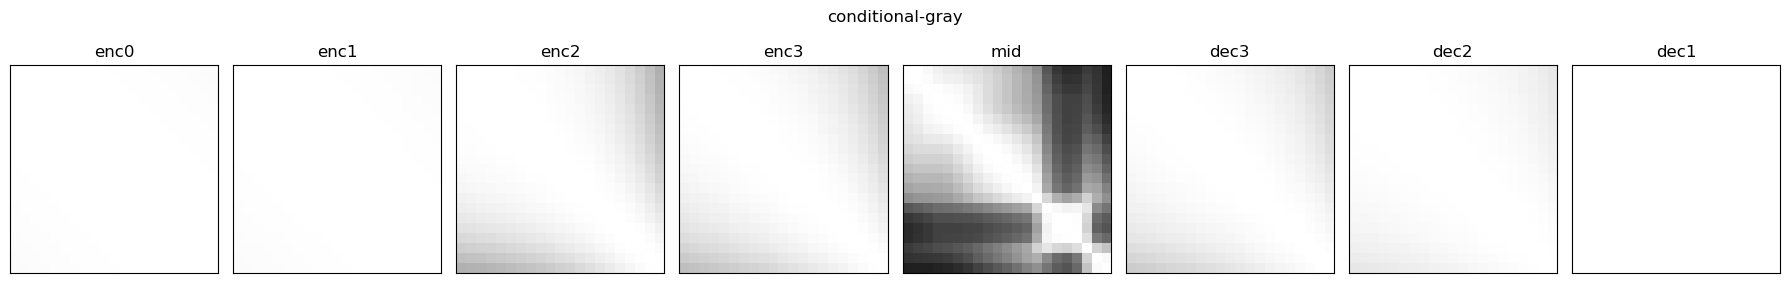

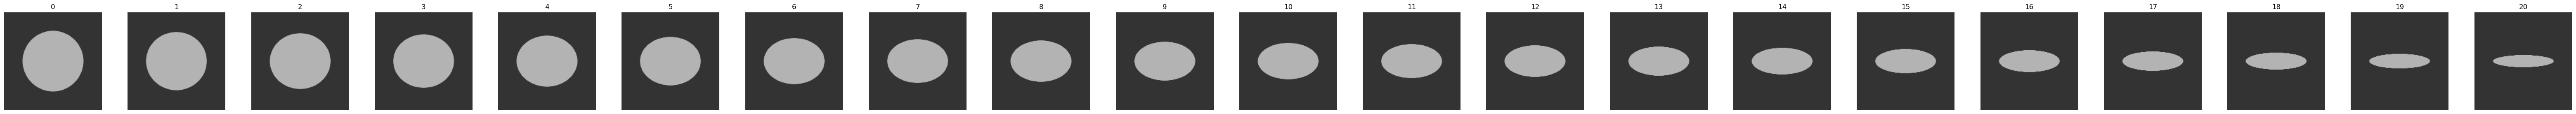

In [37]:
plot_phi_corr(interpolated_conditioner('height', n= 21 ) )

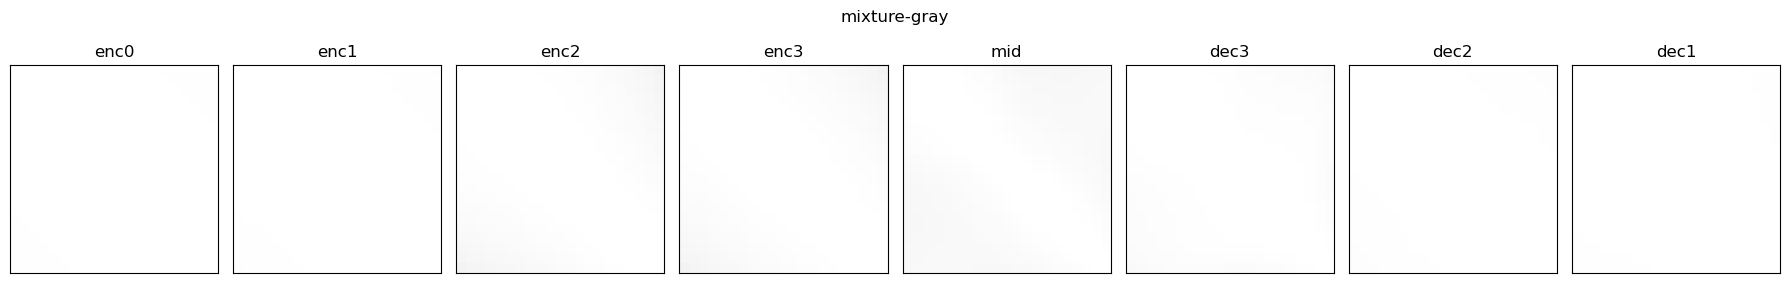

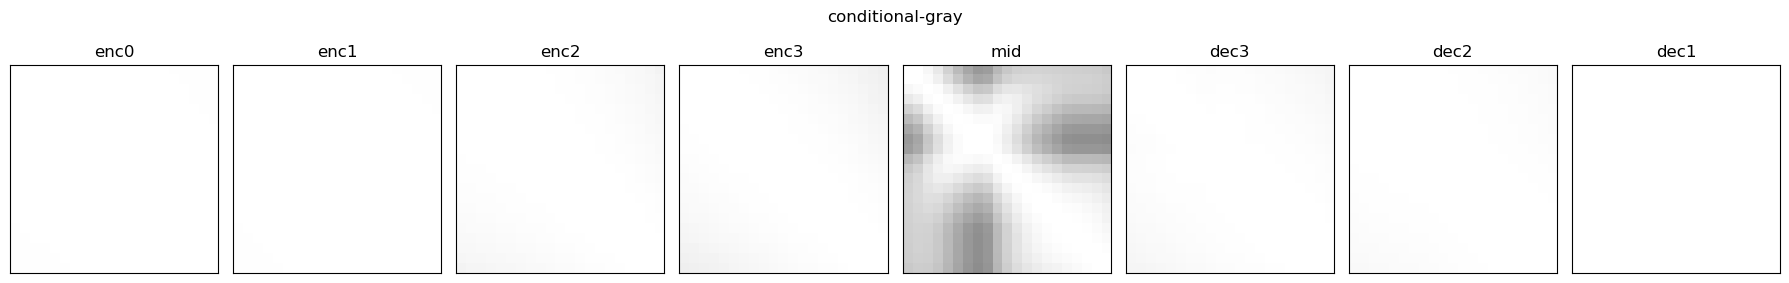

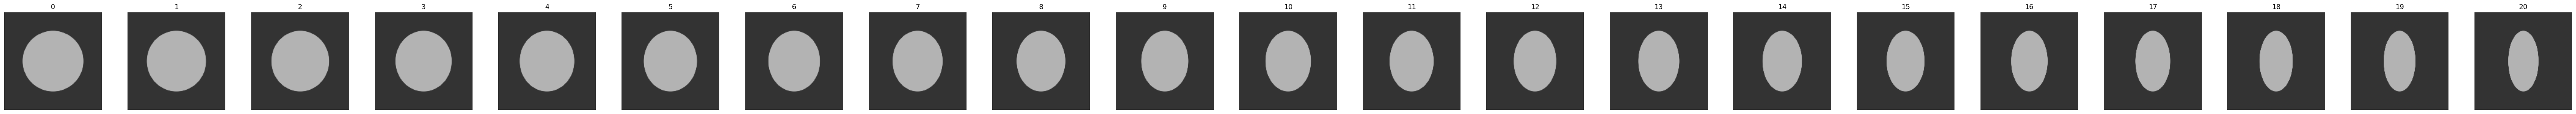

In [450]:
plot_phi_corr(interpolated_conditioner('width', n= 21 ) )

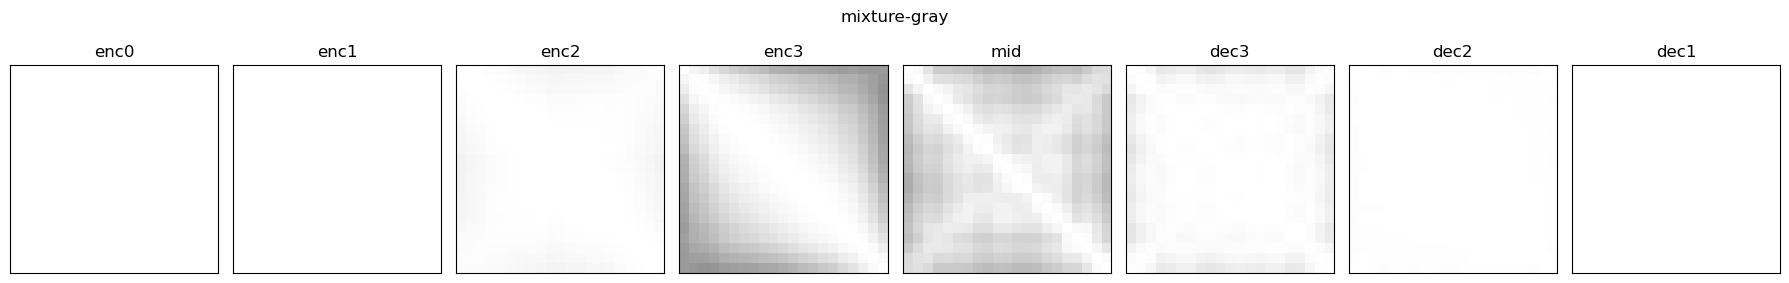

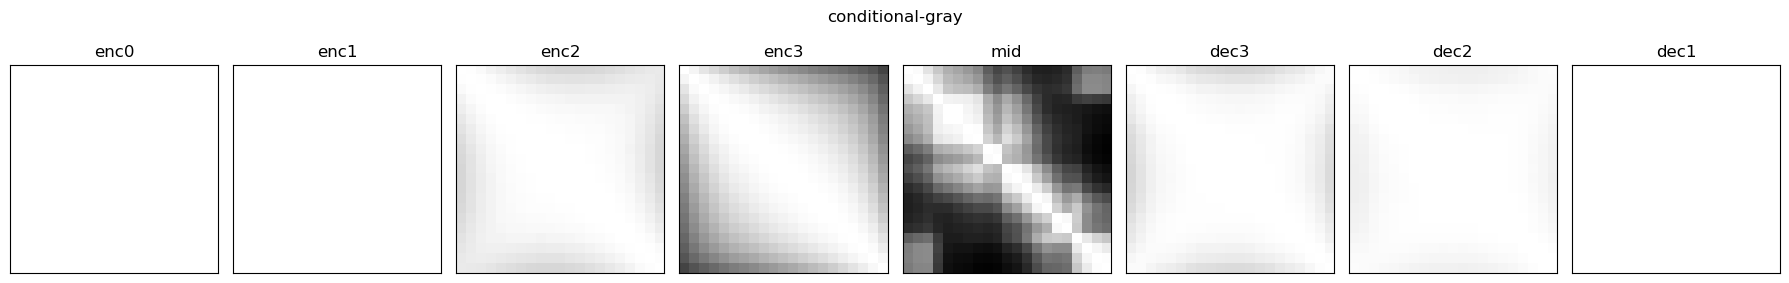

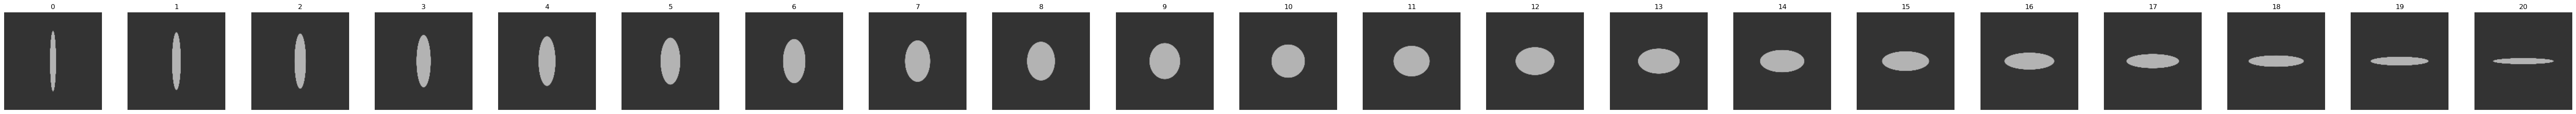

In [18]:
plot_phi_corr(interpolated_conditioner('aspect_ratio', n= 21 ) , sig=100)

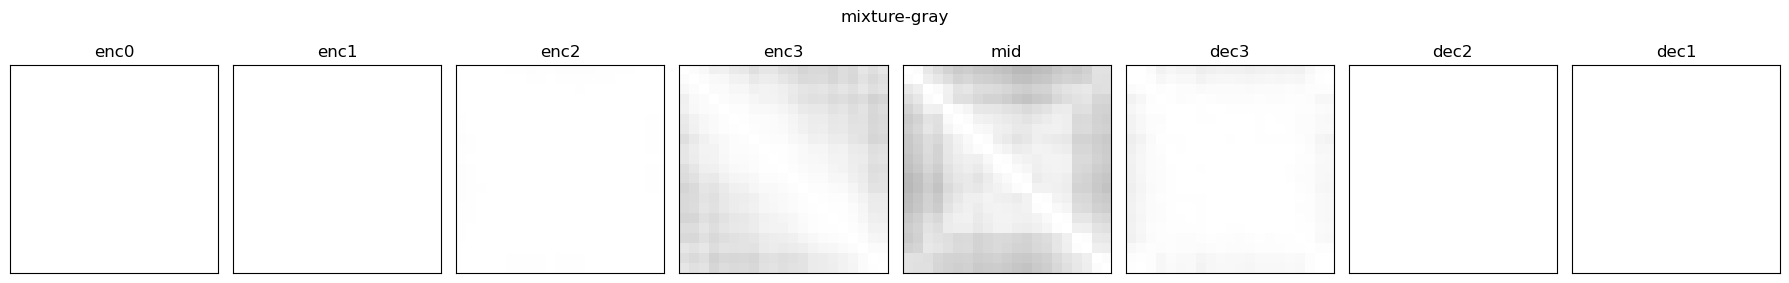

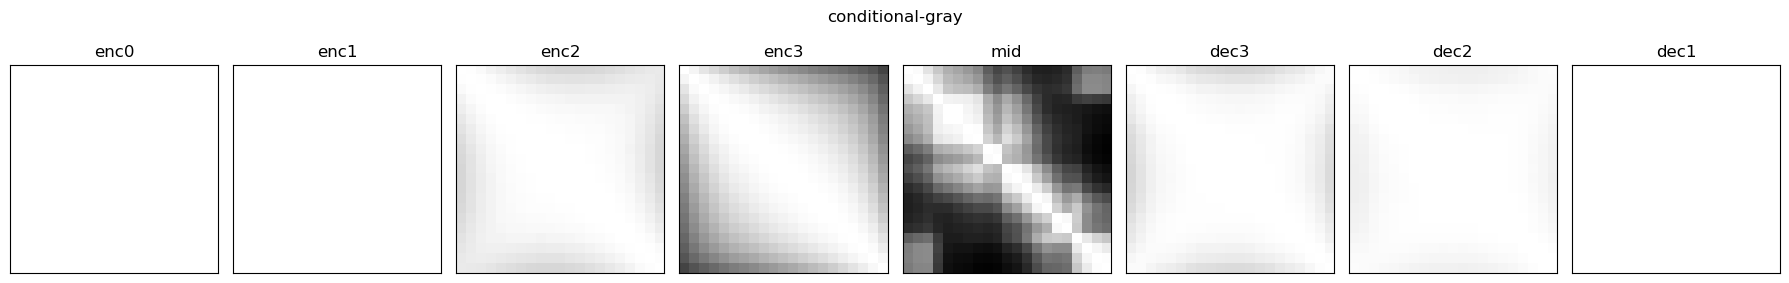

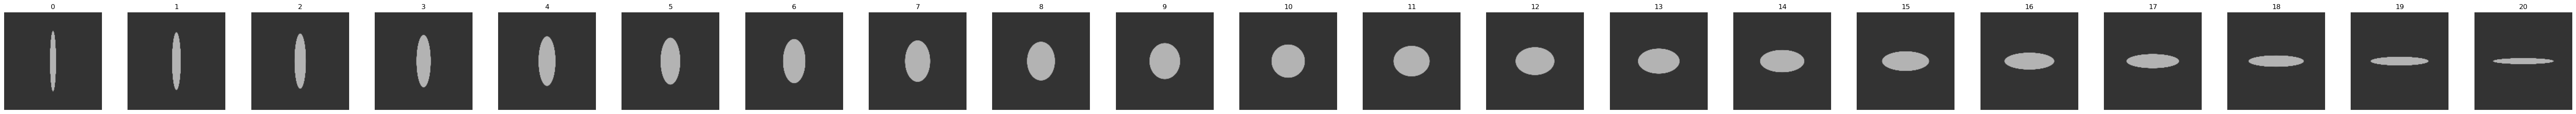

In [16]:
plot_phi_corr(interpolated_conditioner('aspect_ratio', n= 21 ) , sig=250)

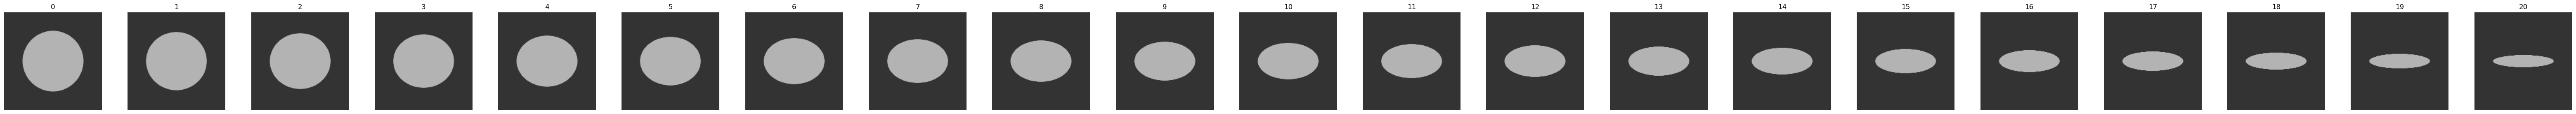

In [38]:
im_cond = interpolated_conditioner('height', n= 21 ) 
show_im_set(im_cond,  vmin=0, vmax = 1, n_columns=21)
sig = 100
group = 'conditional-gray'

if 'mixture' in group: 
    phi_xc = get_channel_means(denoisers[group], add_noise_torch(im_cond, sig)[0],average_phi=False,with_params=True , return_activations=False)
else: 
    phi_xc = get_channel_means(denoisers[group], im_cond,average_phi=False,with_params=True , return_activations=False)




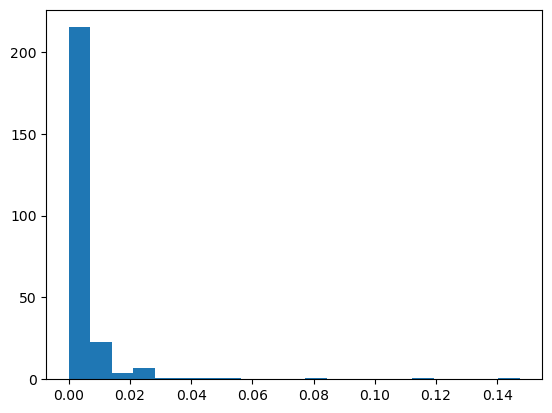

In [40]:
b = 4
max_diff = phi_xc[b].max( dim=0)[0]- phi_xc[b].min( dim=0)[0]

v, idx=max_diff.sort(dim =0, descending=True)

plt.hist(max_diff.flatten().cpu(), bins=21);


# Connection between noisy $\phi$ and clean $\phi$

### change in sparsity of $\phi$ as a function of noise

In [98]:
group = 'mixture-gray'

start_time_total = time.time()        

all_phi_x  = {}
all_phi_c = {}

for sig in [0,30,100,200,250]: 
    all_phi = []
    ### compute phi_x and phi_c for all classes 
    for c in range(0,len(train_sets) ):     
        if 'color' in group.split('-'):
            im_cond = train_sets[c]    
        else: 
            im_cond = train_sets[c].mean(dim = 1, keepdim = True)    
            
        phi, x_c = get_channel_means(denoisers[group], 
                                     add_noise_torch(im_cond.to(device), sig, device=device)[0], 
                                      average_phi=False, with_params=True, return_activations=True)
        
        all_phi.append(torch.hstack(phi).squeeze())
        if c%100 == 0:
            print('class id#:',c, "--- %s seconds ---" % (time.time() - start_time_total))
        
    all_phi_x[sig] = torch.stack(all_phi).cpu()
    all_phi_c[sig] = all_phi_x[sig].mean(dim=1,keepdim=True)
    
    print(all_phi_x[sig].shape)


class id#: 0 --- 0.006146430969238281 seconds ---
torch.Size([5, 20, 720])
class id#: 0 --- 0.052164316177368164 seconds ---
torch.Size([5, 20, 720])
class id#: 0 --- 0.09869050979614258 seconds ---
torch.Size([5, 20, 720])
class id#: 0 --- 0.14519500732421875 seconds ---
torch.Size([5, 20, 720])
class id#: 0 --- 0.19165658950805664 seconds ---
torch.Size([5, 20, 720])


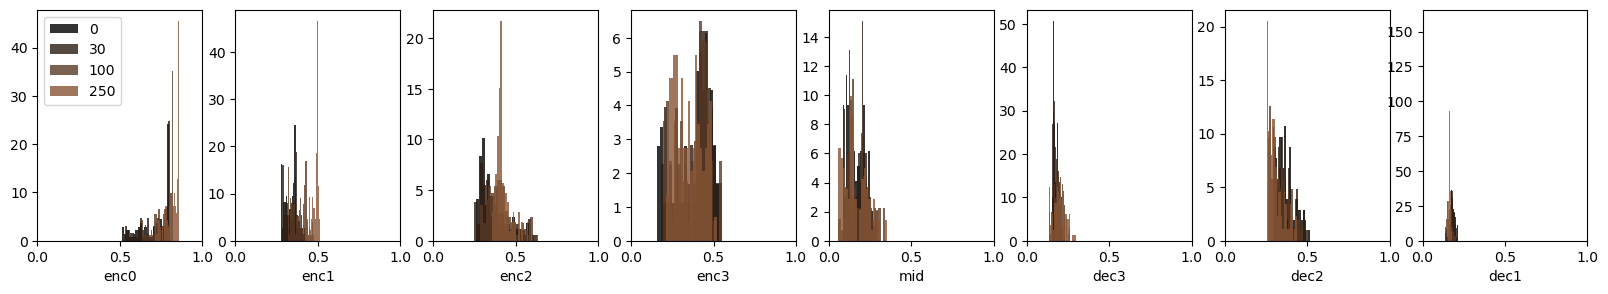

In [108]:
# participatino ratio per block 
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(ii) for ii in np.linspace(0, 1, len(blocks))]

f, axs = plt.subplots(1,len(blocks), figsize = (20,3) )

for  j,sig in  zip( range(len(plot_colors)),[0,30,100,250]): 
    
    k1 = 0
    
    for i, l in zip(range(len(plot_colors)), [16, 32,64,128, 256, 128, 64, 32]): 
        # print(k1, k1 + l)
        participation_ratio = (all_phi_x[sig][:,:,k1:k1 + l].norm(1,dim = 2).squeeze()**2 /all_phi_x[sig][:,:,k1:k1 + l].norm(2,dim = 2, keepdim=True).squeeze()**2 ) /l
        axs[i].hist(participation_ratio.flatten(), bins = 21, alpha = .8, density=True, label = sig, color=plot_colors[j])
        axs[i].set_xlim(0,1);
        axs[i].set_xlabel(blocks[i]  )
        axs[0].legend()
        k1 += l 


     

### change in pairwise correlations as a function of noise

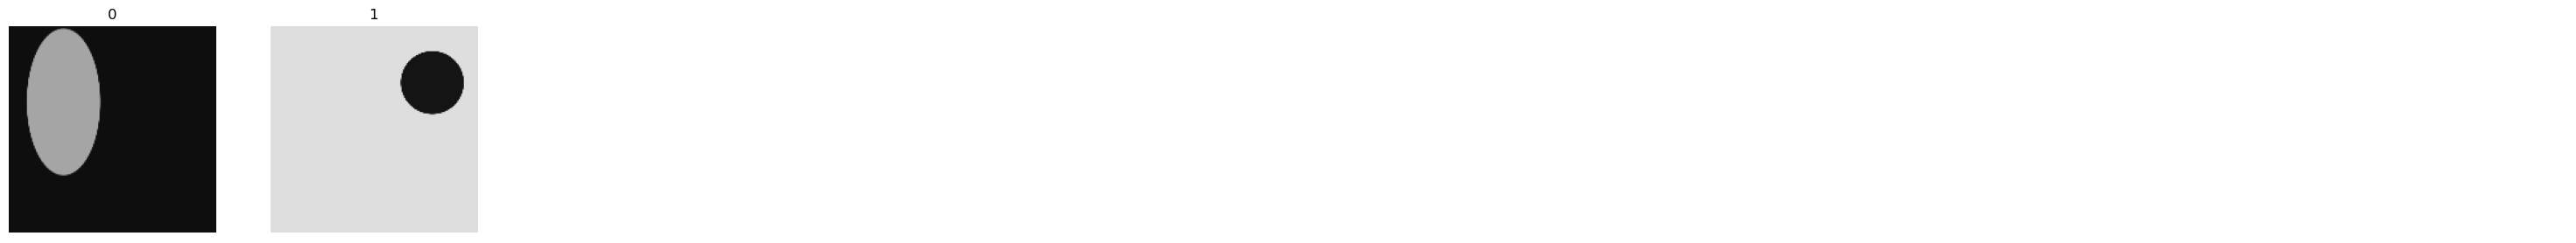

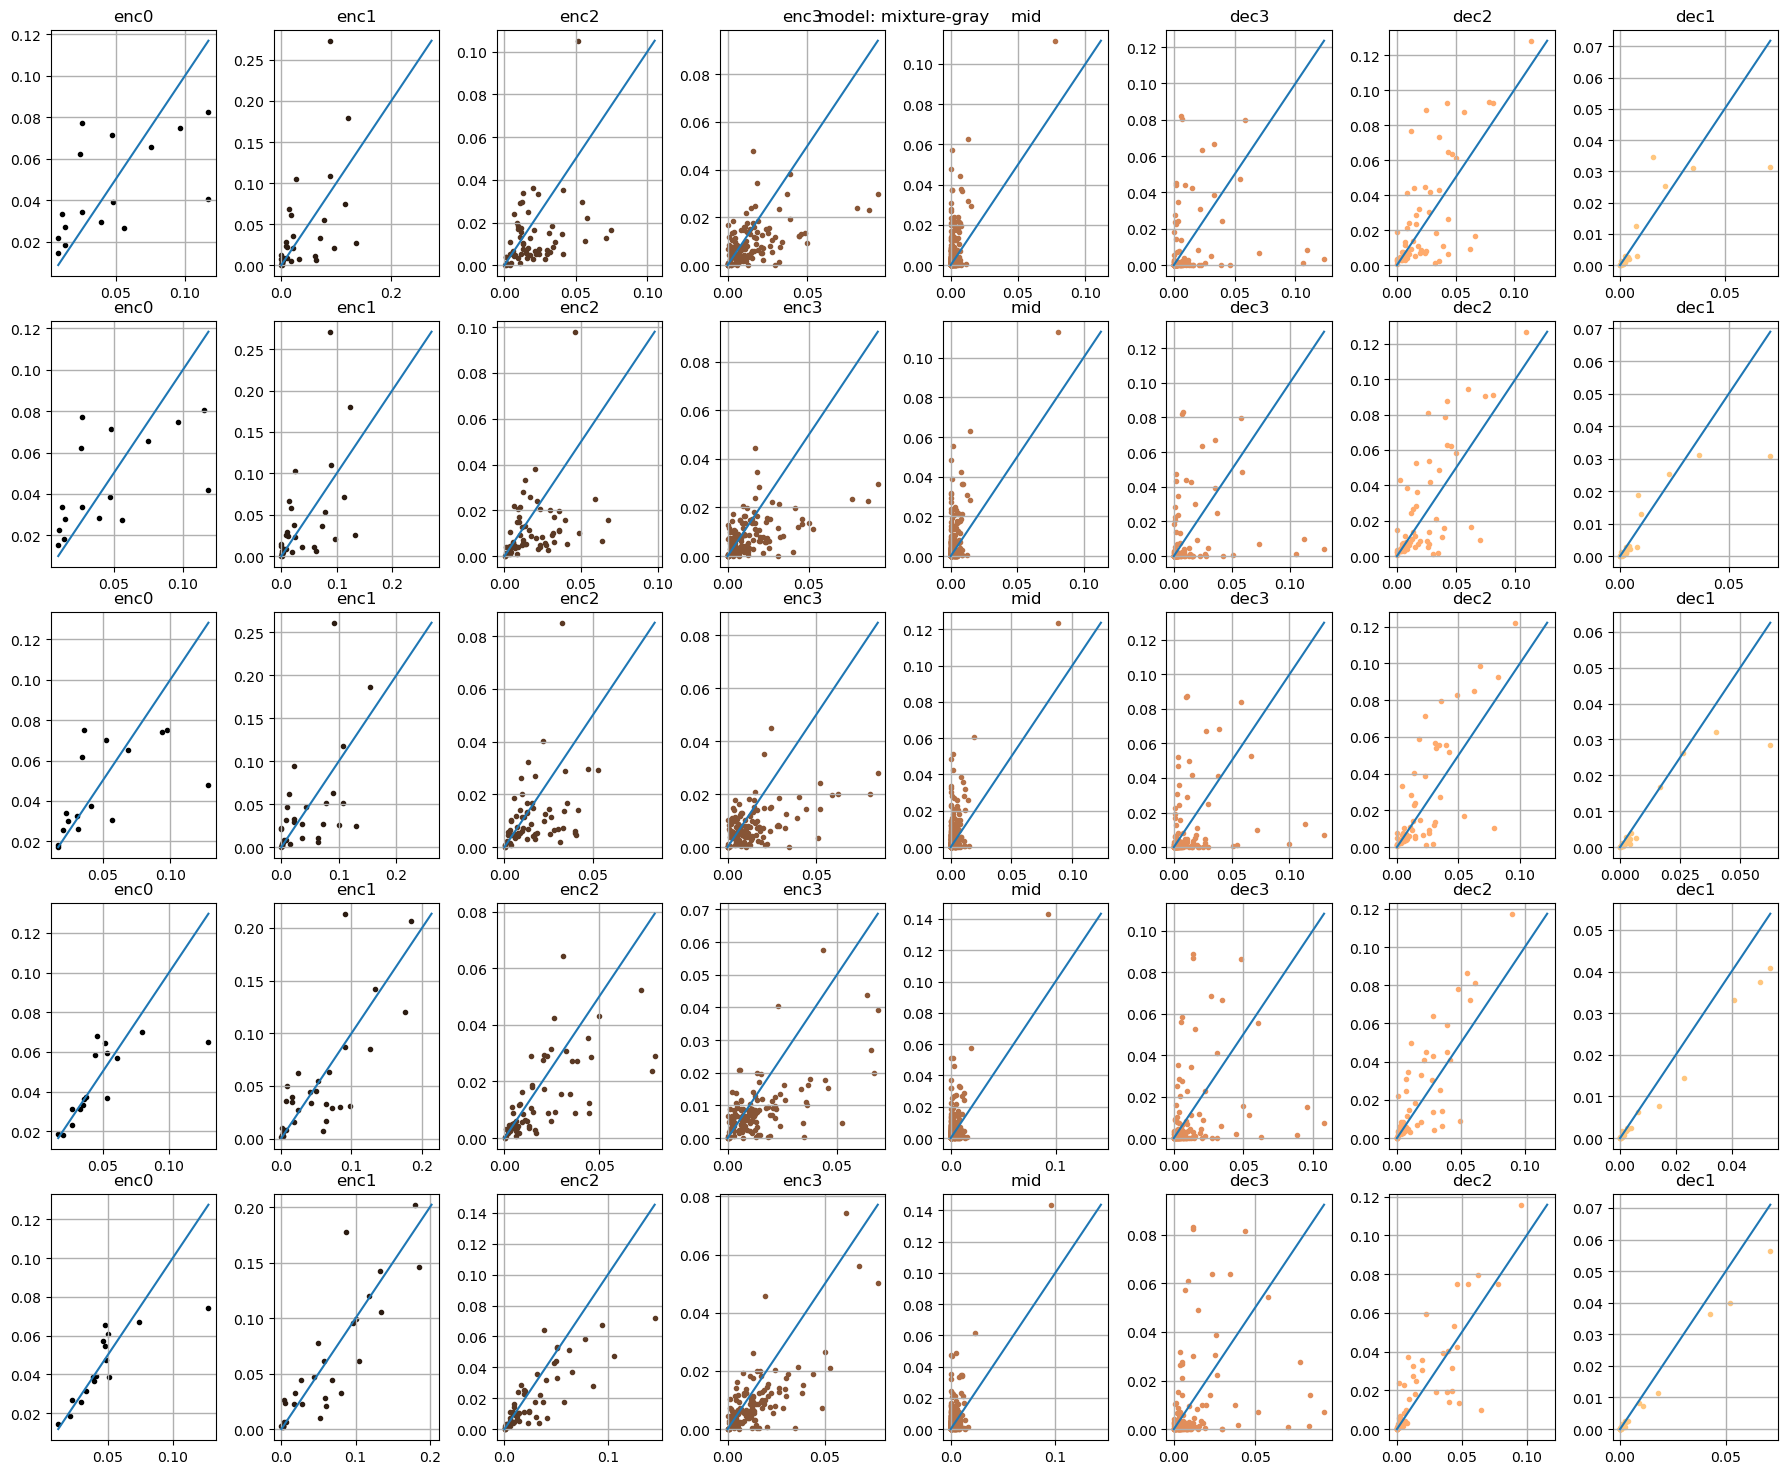

In [114]:
### compare two classes against each other ####
c1 = np.random.randint(0, len(train_sets), 1).item()
c2 = np.random.randint(0, len(train_sets), 1).item()
group = 'mixture-gray'

if 'color'  in group.split('-'):  
    show_im_set(torch.vstack((train_sets[c1][0:1], train_sets[c2][0:1] ) ),  n_columns=10, vmin=0, vmax = 1)
else: 
    show_im_set(torch.vstack((train_sets[c1][0:1].mean(dim = 1, keepdim = True), train_sets[c2][0:1].mean(dim = 1, keepdim = True) ) ),  n_columns=10, vmin=0, vmax = 1)
    



sigmas = [0,30,100,250,350]
f , axs = plt.subplots(len(sigmas),len(blocks), figsize=(18,3 * len(sigmas)), sharex =False, sharey=False)
f.suptitle('model: ' + group)
plt.tight_layout()
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]

for  j,sig in  zip(range(len(sigmas)),sigmas): 

    
    if 'gray' in group.split('-'):  
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
    else: 
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0]
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0]



    phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
    phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)
            


    for i in range( len(blocks) ): 
        axs[j,i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[j,i].set_title(blocks[i])
        axs[j,i].grid(  linewidth=1);
        axs[j,i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])
    


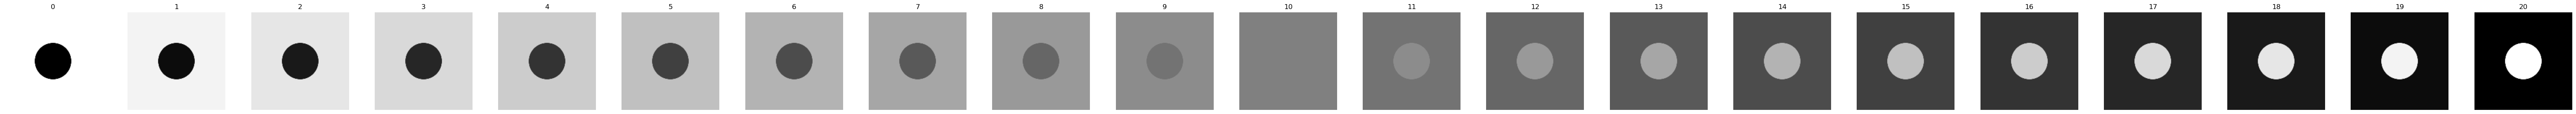

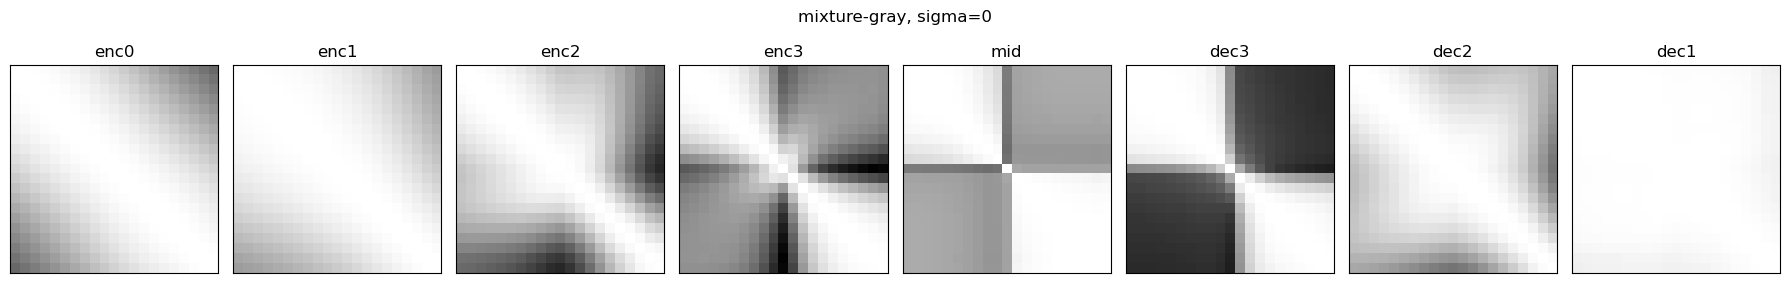

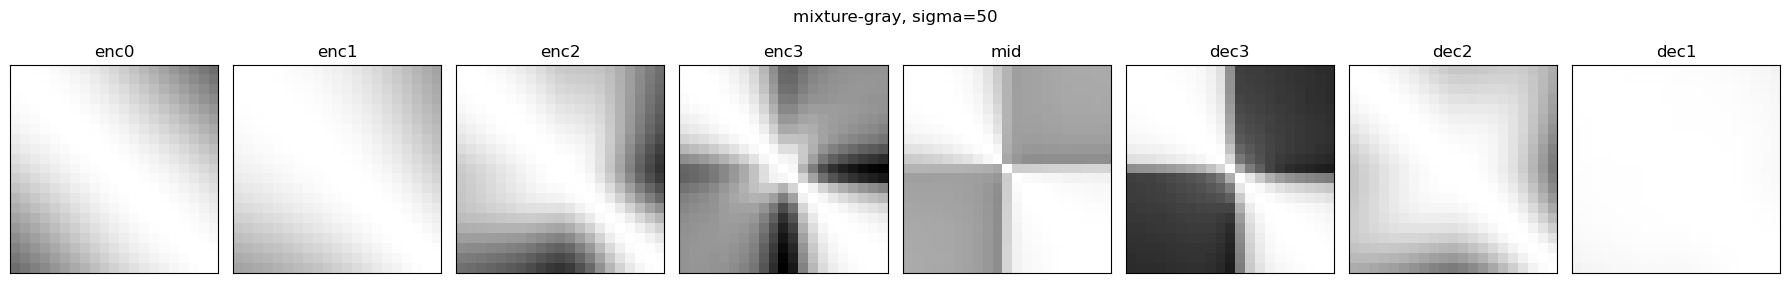

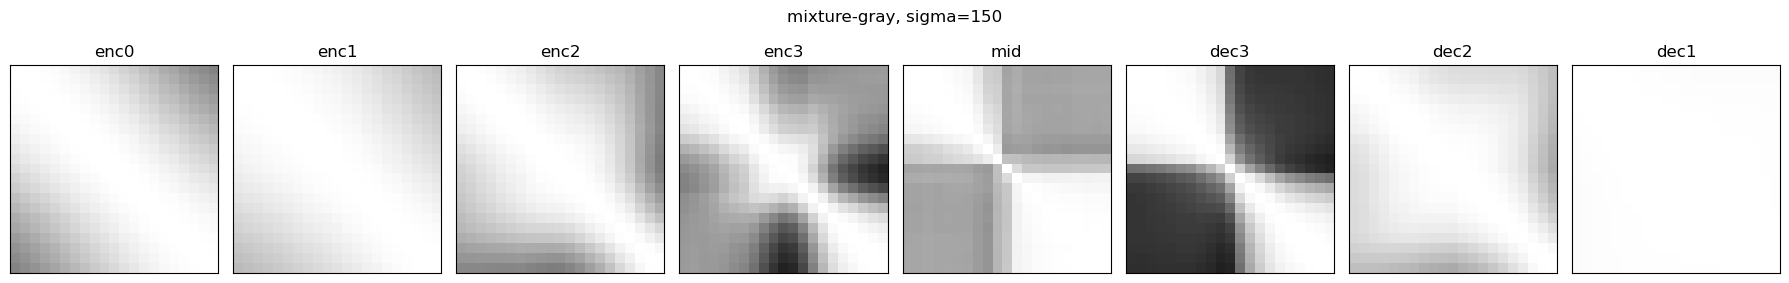

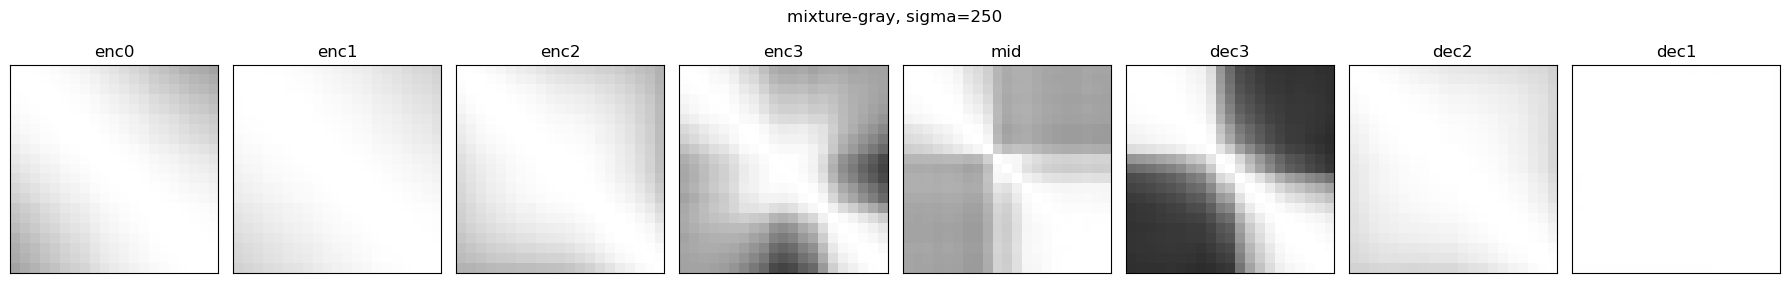

In [534]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = [0,-1]

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])
inp_ims = interpolated_conditioner('fg_bg_intensities', n= 21 ) 

if 'gray' in group.split('-'): 
    show_im_set(inp_ims.mean(dim = 1, keepdim = True),  n_columns=len(im_cond), vmin=0, vmax = 1)
else: 
    show_im_set(inp_ims,  n_columns=len(im_cond), vmin=0, vmax = 1)
    
# inp_ims = train['inp'][0:200]
# inp_ims = train_sets[1]


group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
sigmas= [0, 50,150,250]
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()



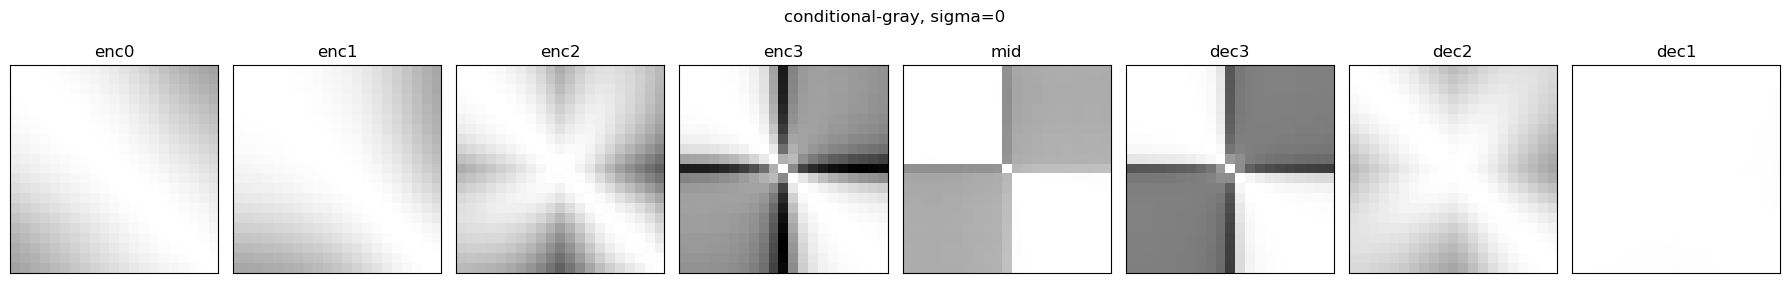

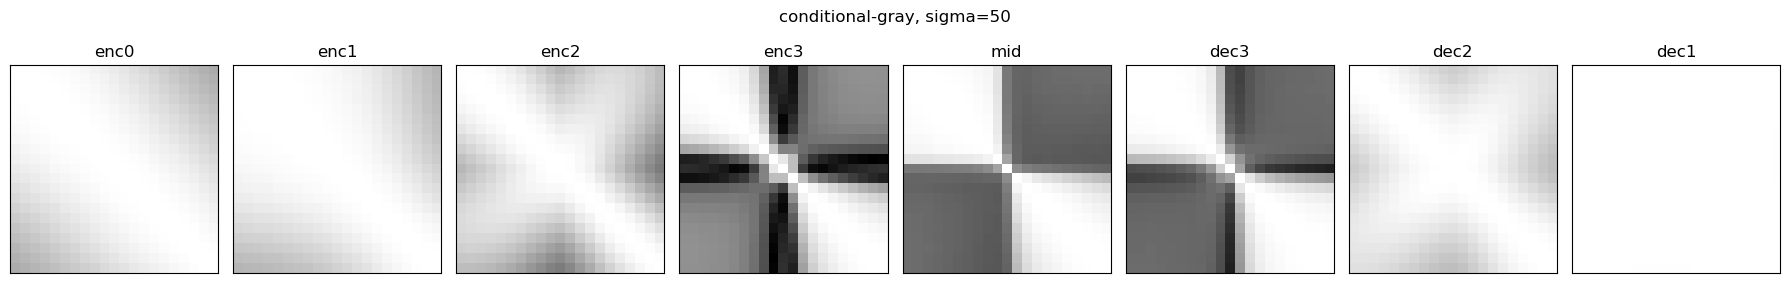

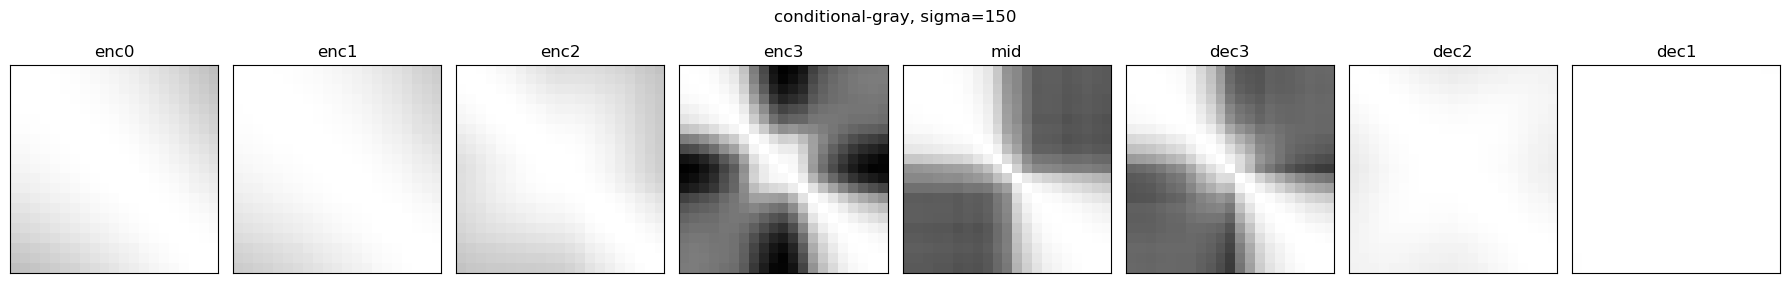

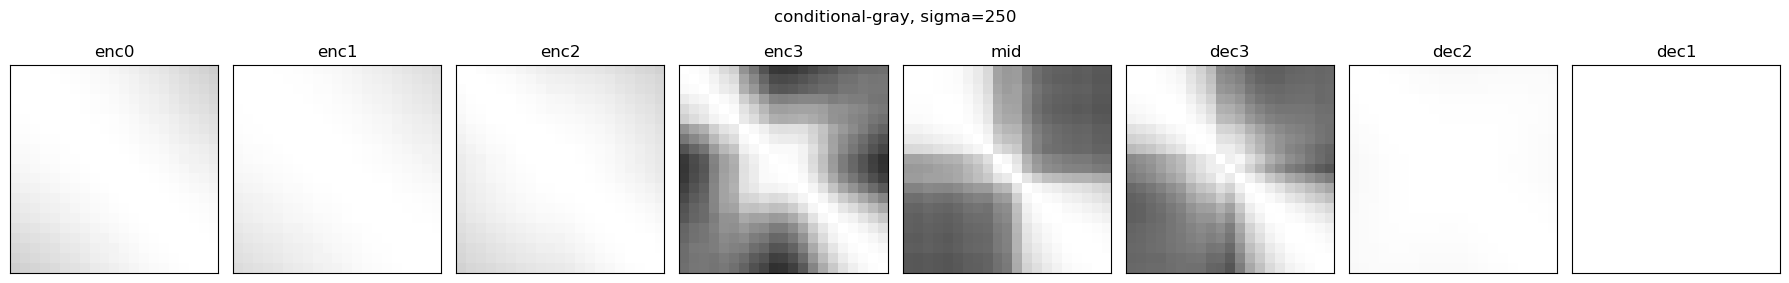

In [535]:
group = 'conditional-gray'
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc, phi_x = get_channel_means(denoisers[group], x1=inp_ims, 
                              x2=noisy_inp_ims,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_x[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()


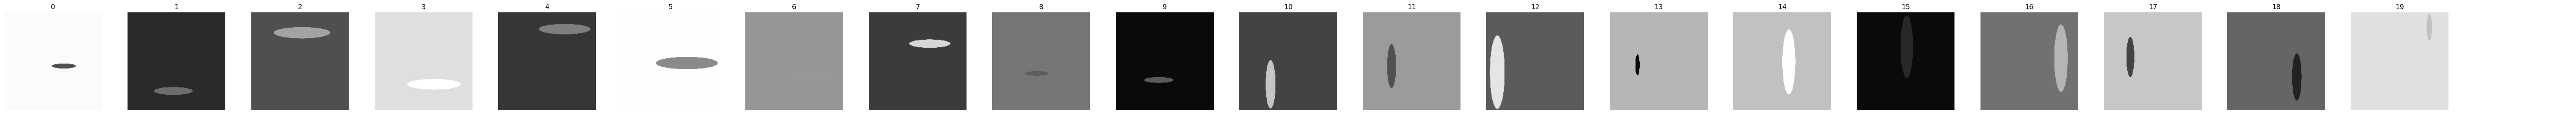

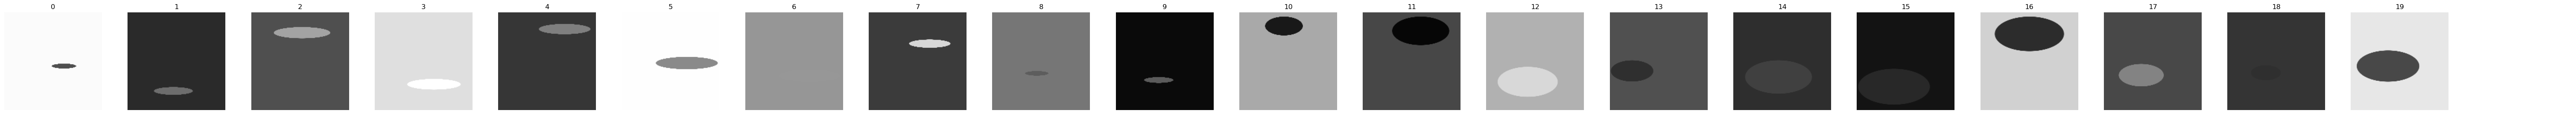

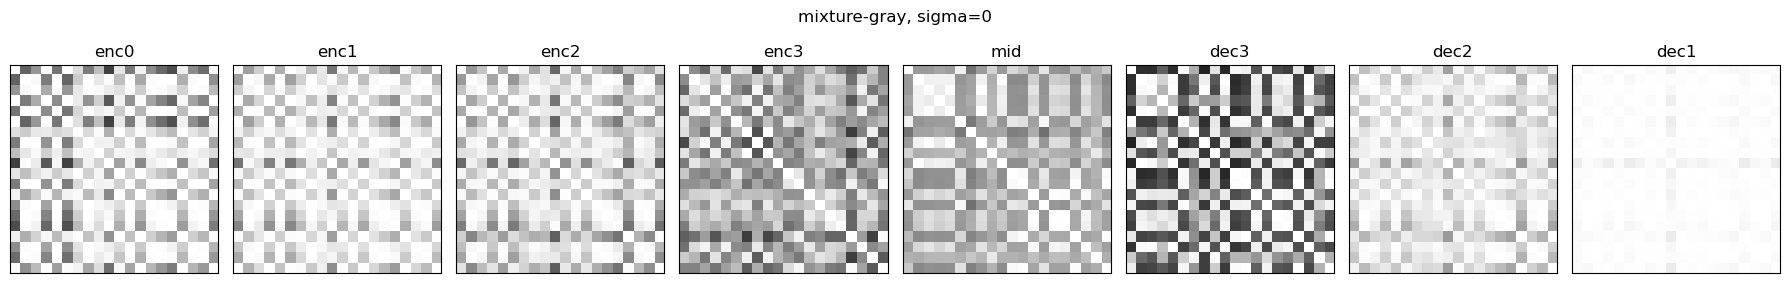

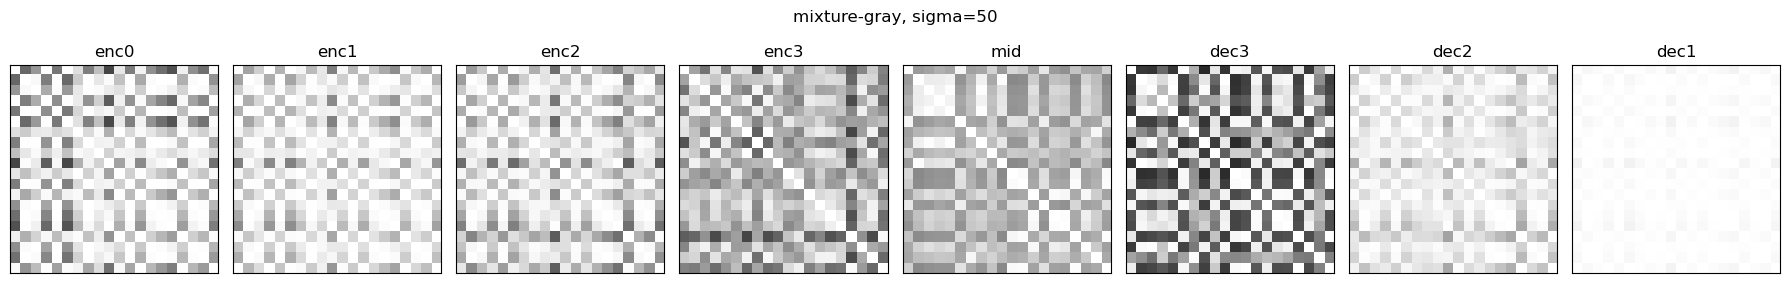

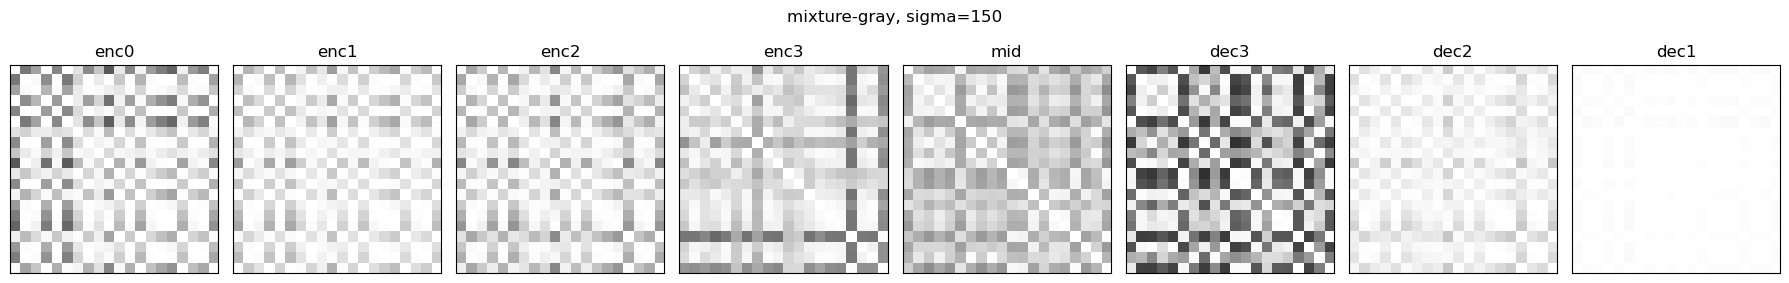

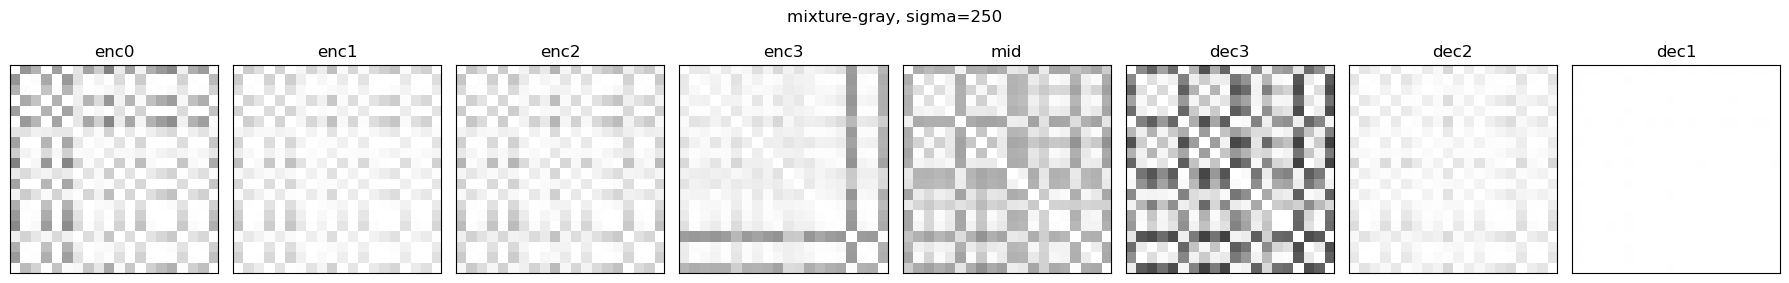

In [542]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = [0,1]

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])
if 'gray' in group.split('-'): 
    show_im_set(inp_ims.mean(dim = 1, keepdim = True),  n_columns=len(im_cond), vmin=0, vmax = 1)
else: 
    show_im_set(inp_ims,  n_columns=len(im_cond), vmin=0, vmax = 1)
 

group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
sigmas= [0, 50,150,250]
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()




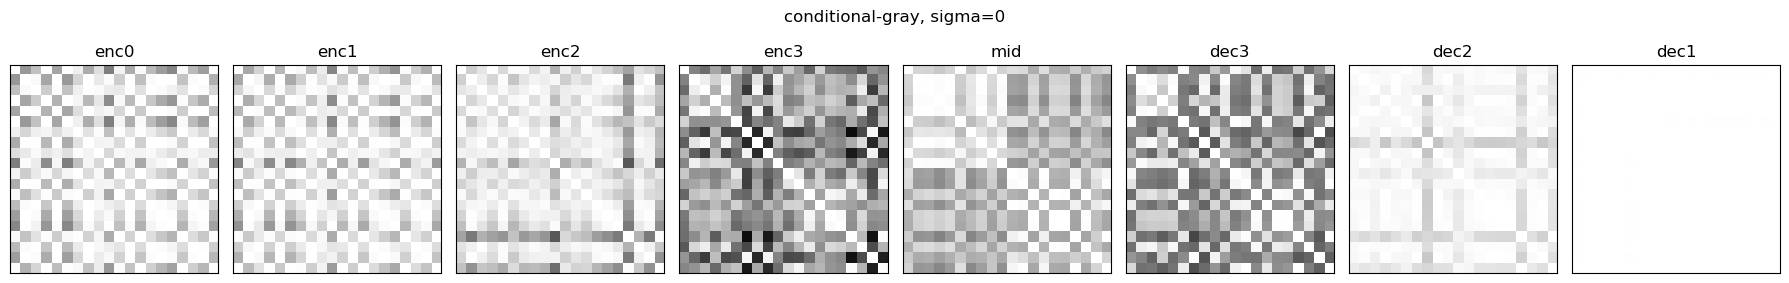

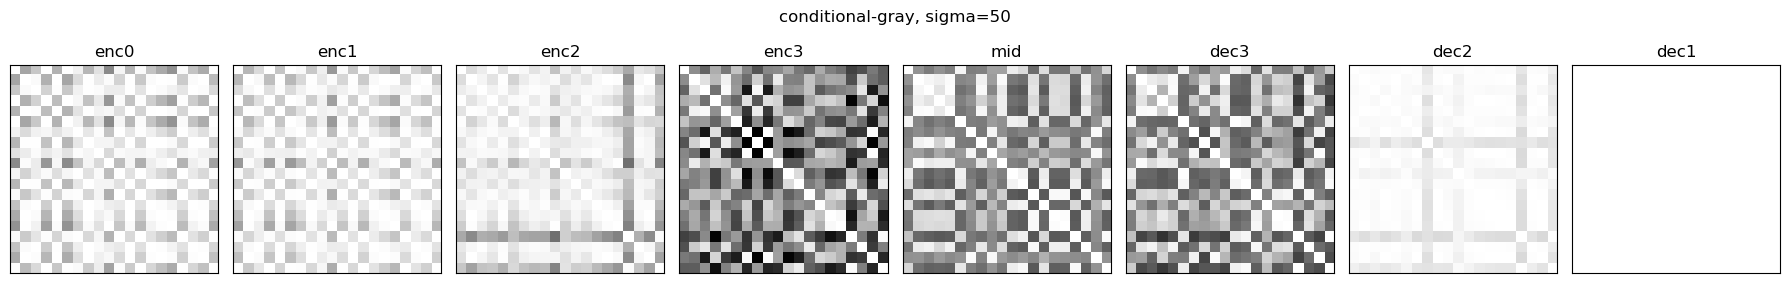

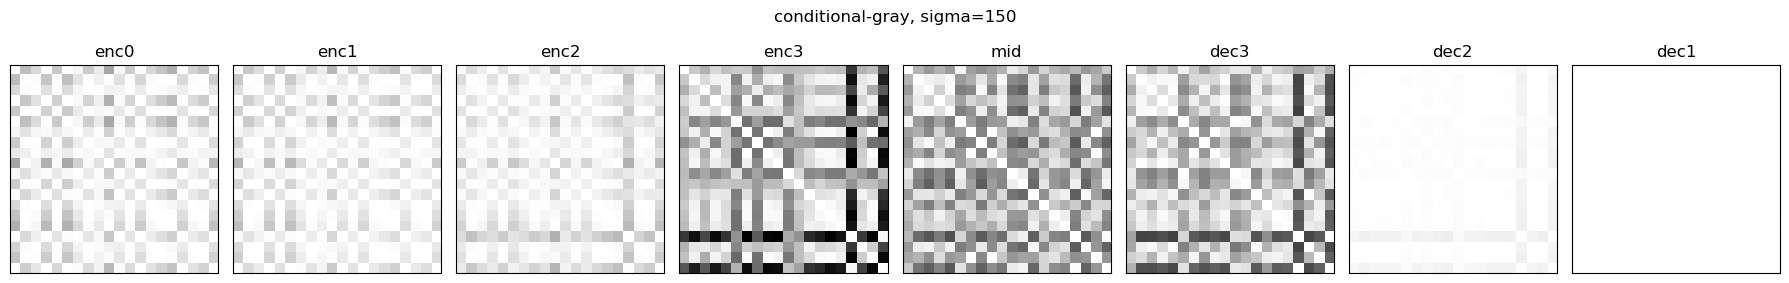

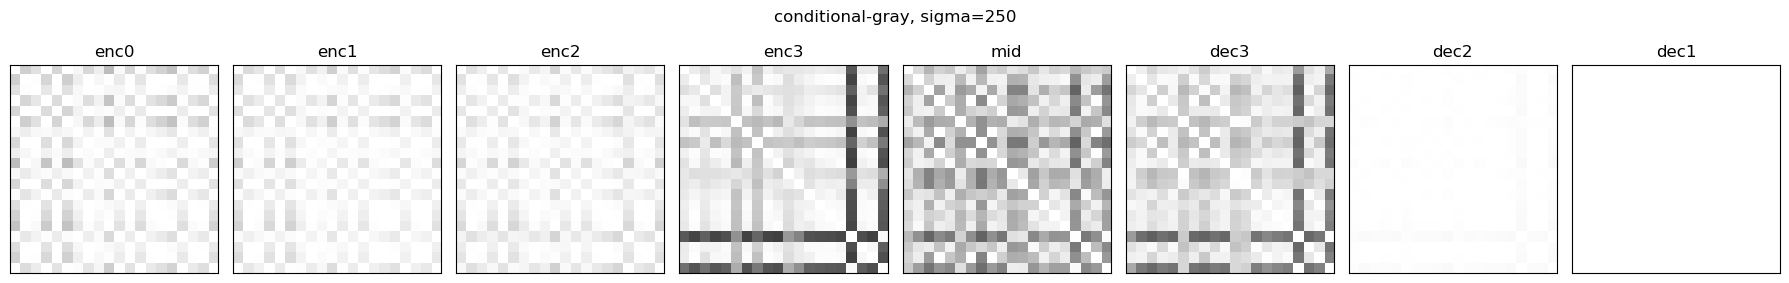

In [543]:
group = 'conditional-gray'
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc, phi_x = get_channel_means(denoisers[group], x1=inp_ims, 
                              x2=noisy_inp_ims,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_x[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()


### least correlated images as a function of noise level per block:

Most decorrelated images at different noise levelsaccoring to block:  mid


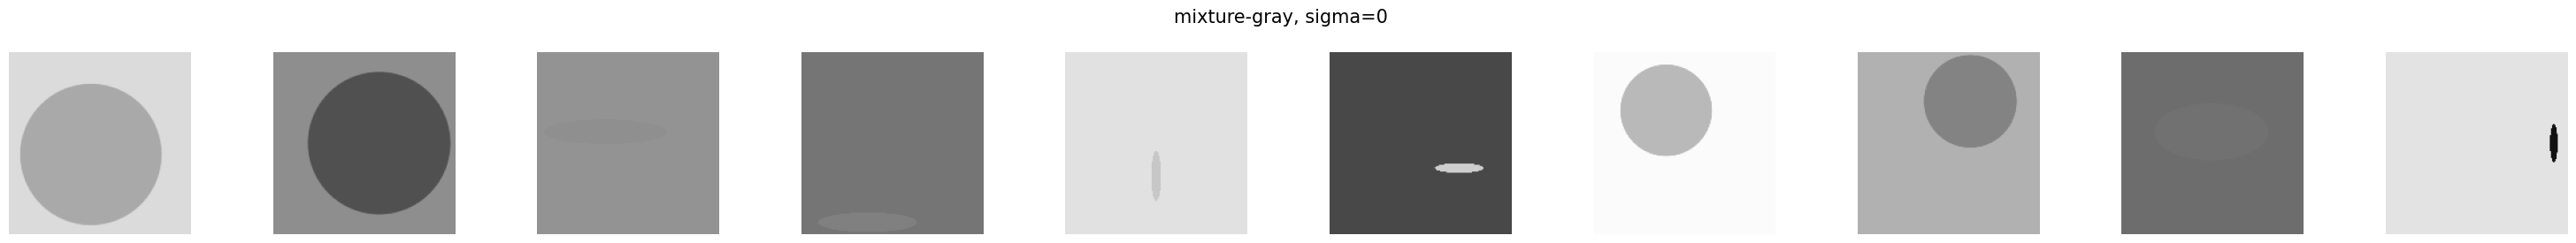

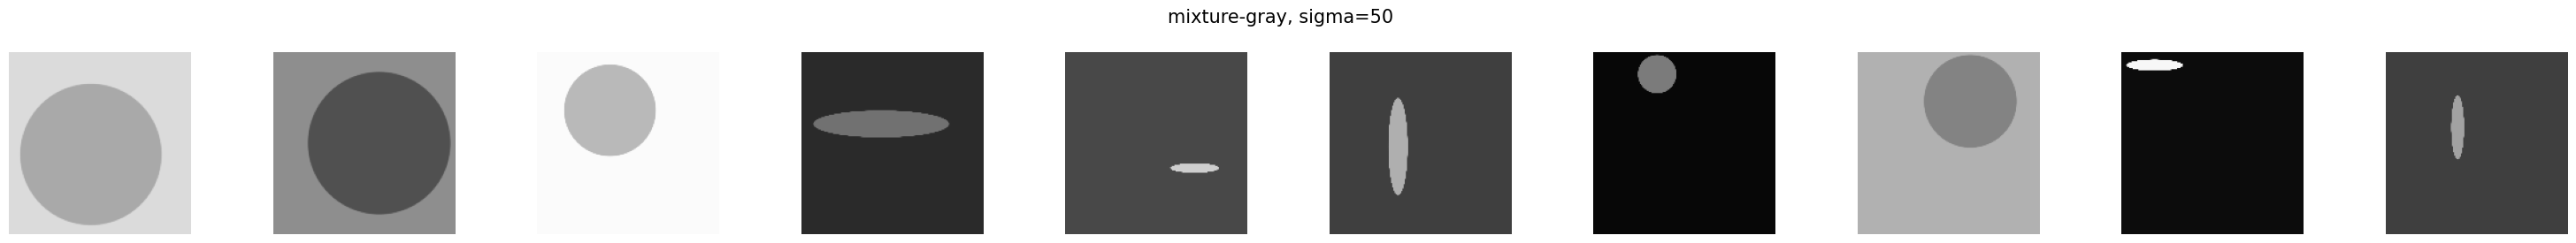

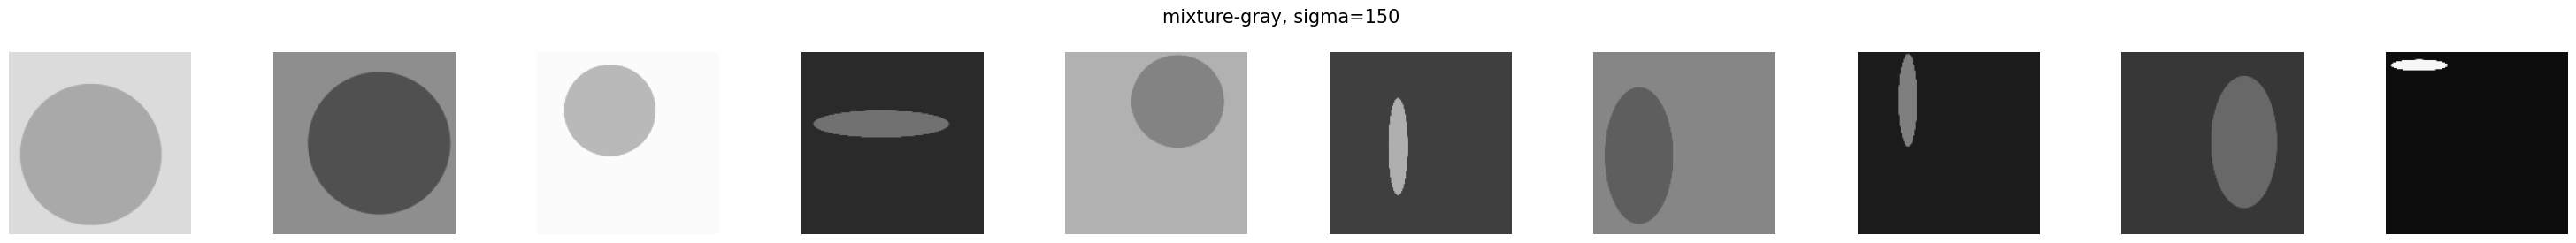

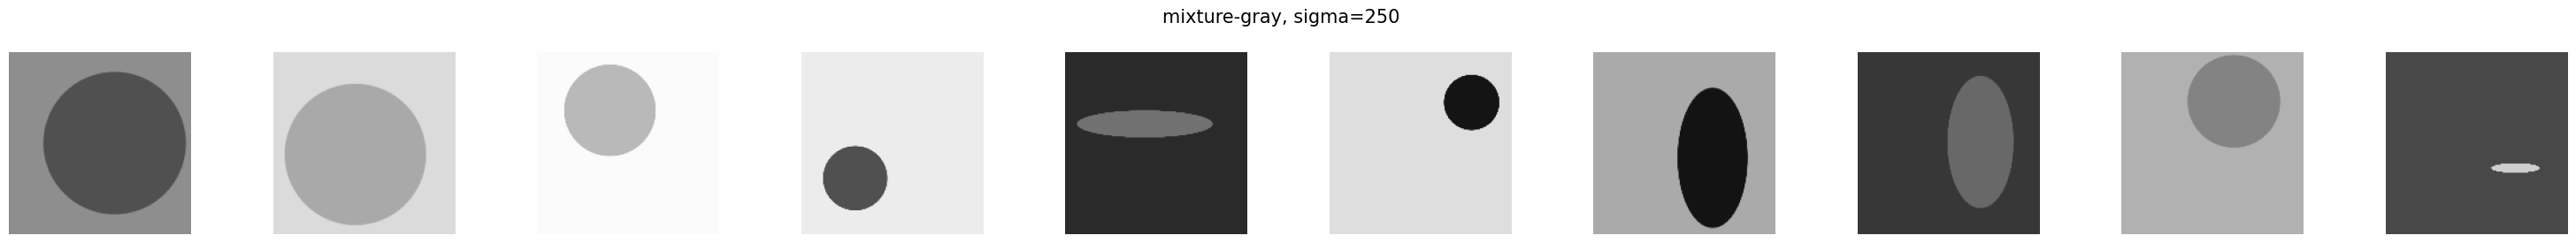

In [137]:
block = 4
###################
ids = range(len(train_sets))

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])

group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)

print('Most decorrelated images at different noise levelsaccoring to block: ' , blocks[block])
for sig in sigmas:
    phi_xc = get_channel_means(denoisers[group], 
                      add_noise_torch(inp_ims.to(device), sig, device=device)[0],
                      average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()          
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, 
                sub_labels= ['']* inp_ims.shape[0] , 
                label= group + ', sigma='+ str(sig), 
                vmin=0,  vmax = 1) 


Most decorrelated images at different noise levels accoring to block:  mid


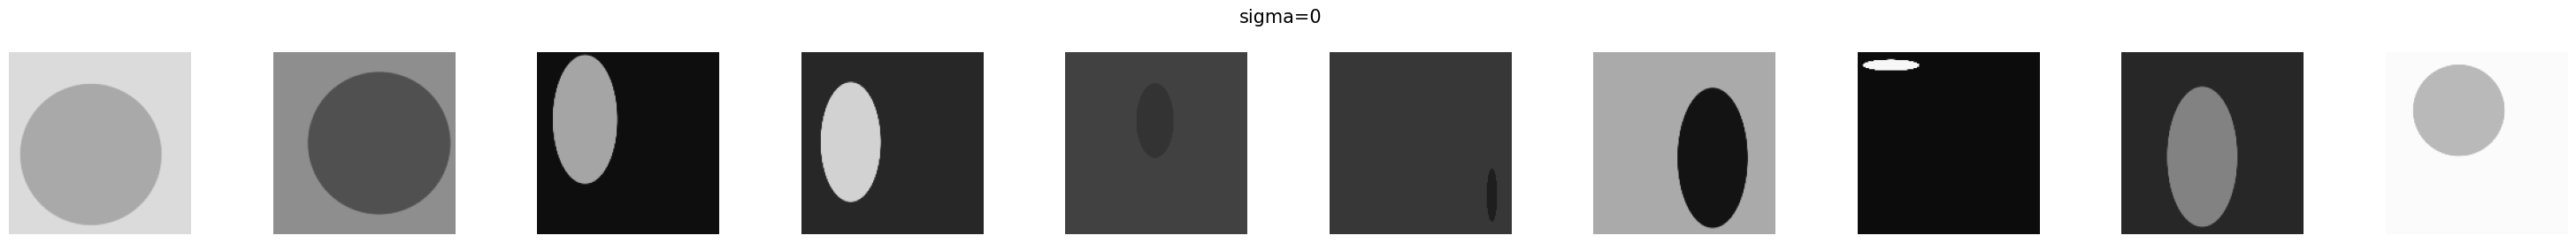

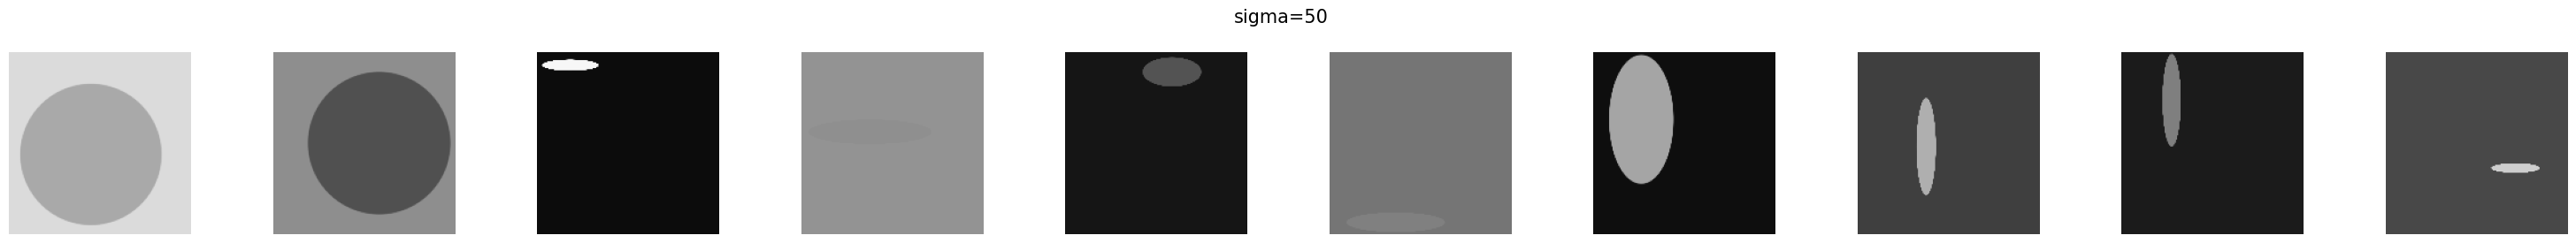

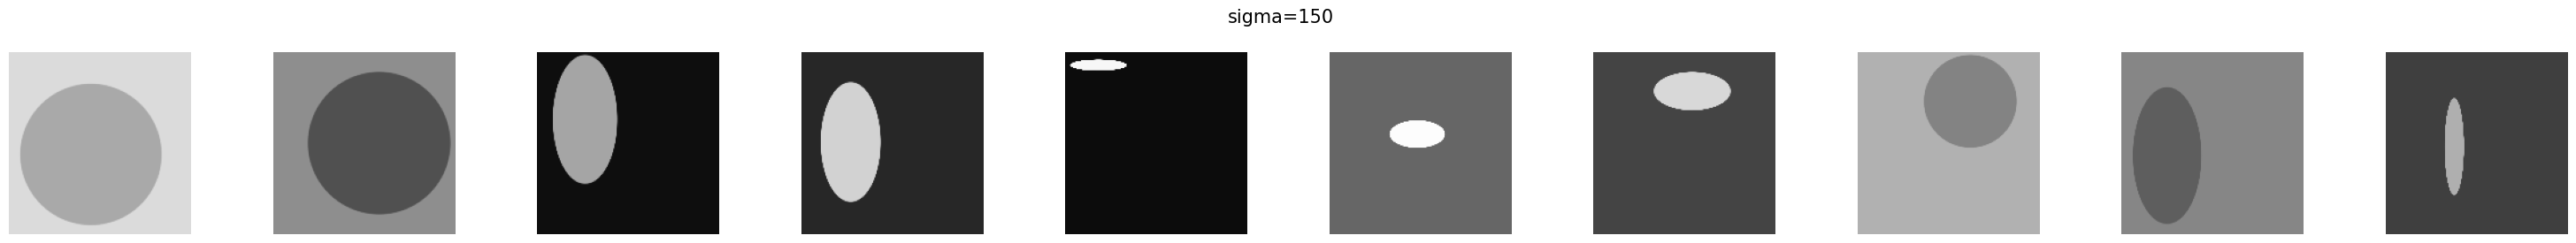

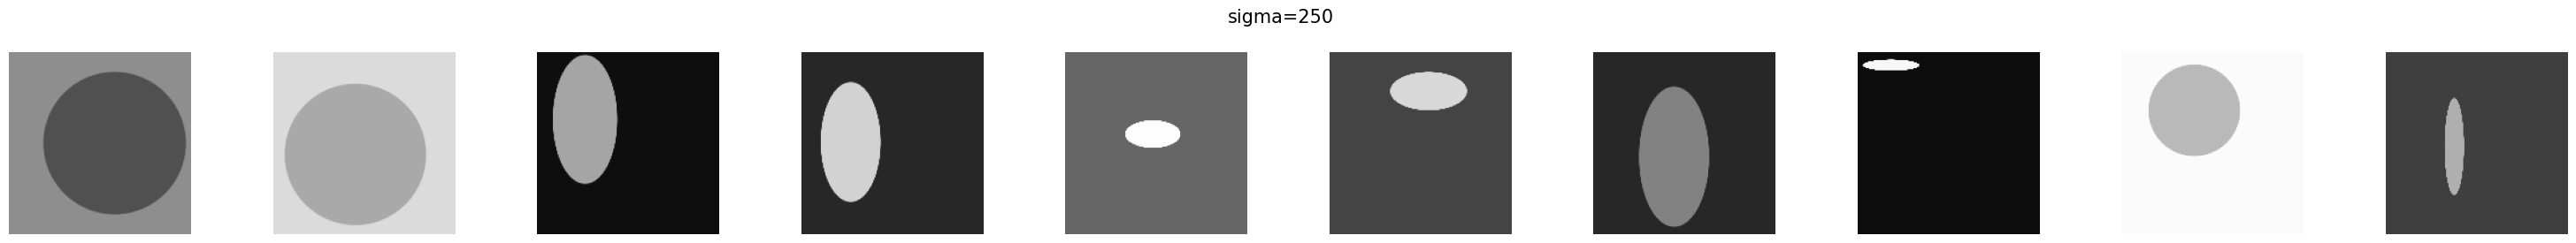

In [139]:
group = 'conditional-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
block = 4

print('Most decorrelated images at different noise levels accoring to block: ' , blocks[block])
for sig in sigmas:
    phi_xc,phi_x = get_channel_means(denoisers[group], x1= inp_ims,
                      x2=add_noise_torch(inp_ims.to(device), sig, device=device)[0],                      
                      average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_x[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] , 
                label='sigma='+ str(sig), vmin=0,  vmax = 1)


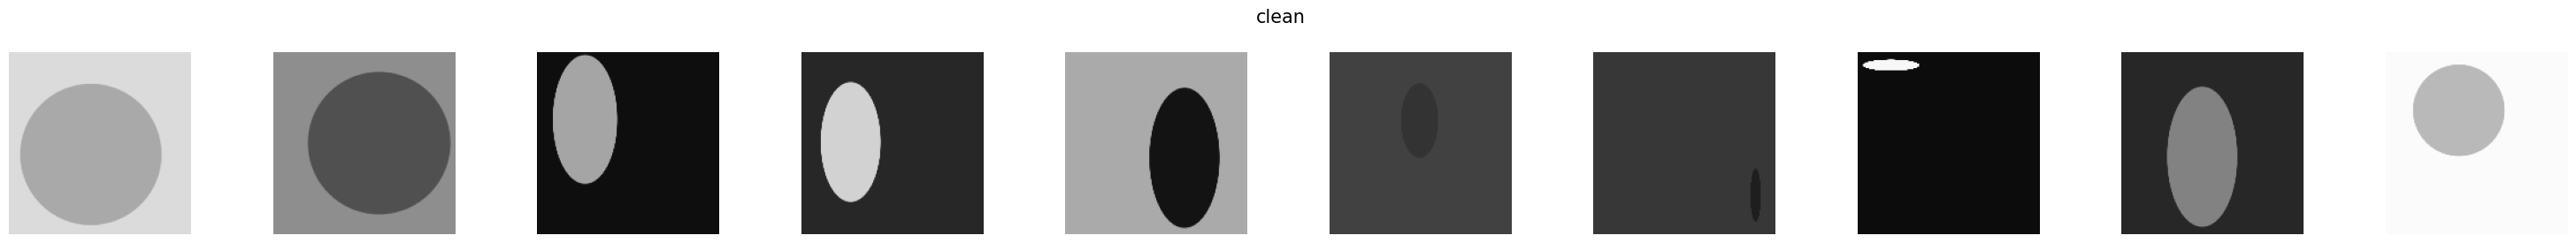

In [140]:
cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
idx = cov.sum(dim = 0).sort()[1]
show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] , label='clean',vmin=0,  vmax = 1) 

Most decorrelated images across different blocks at noise level:  250


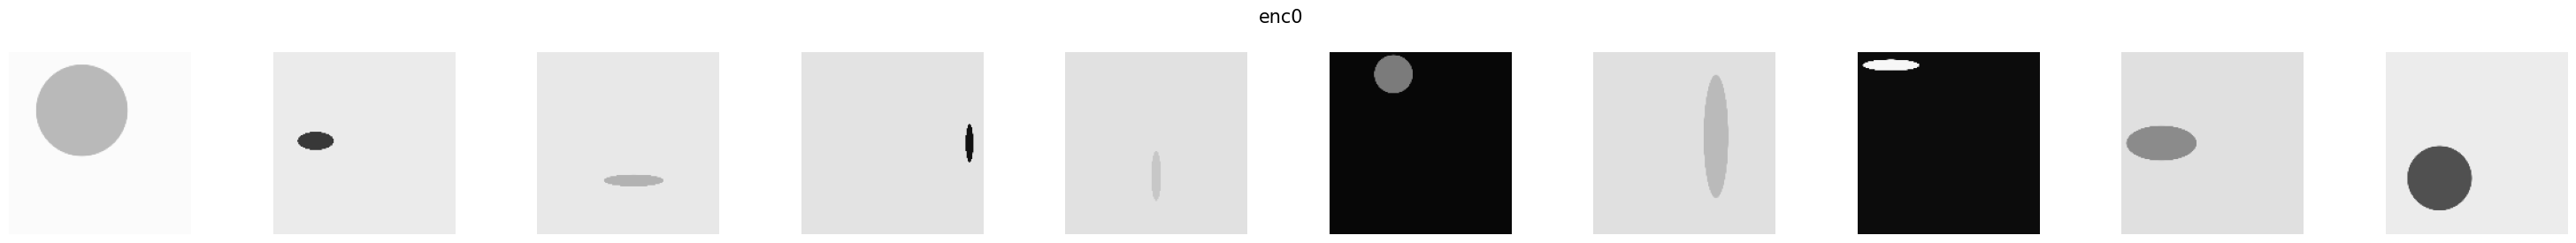

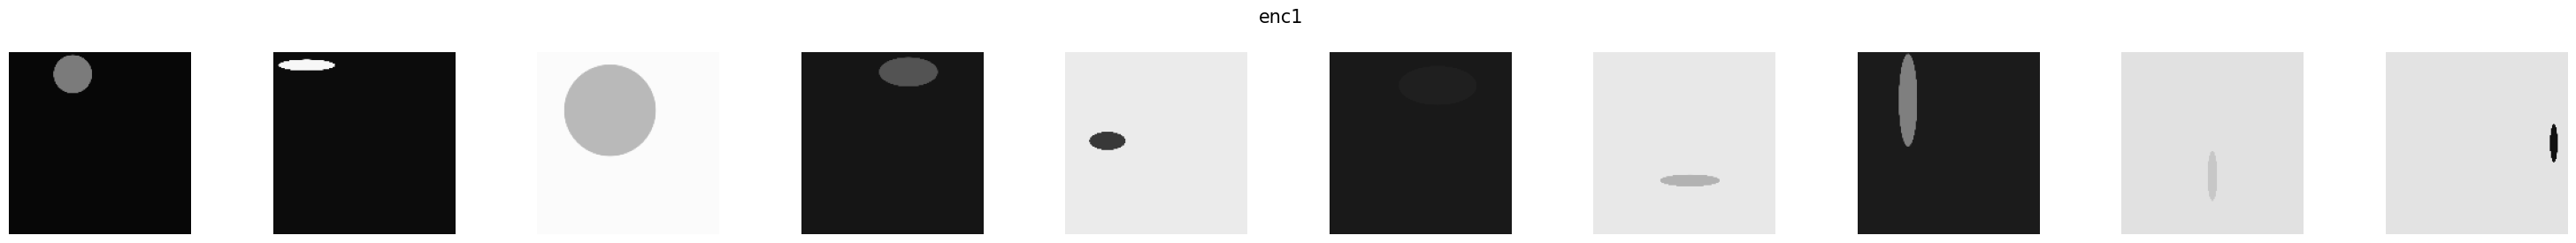

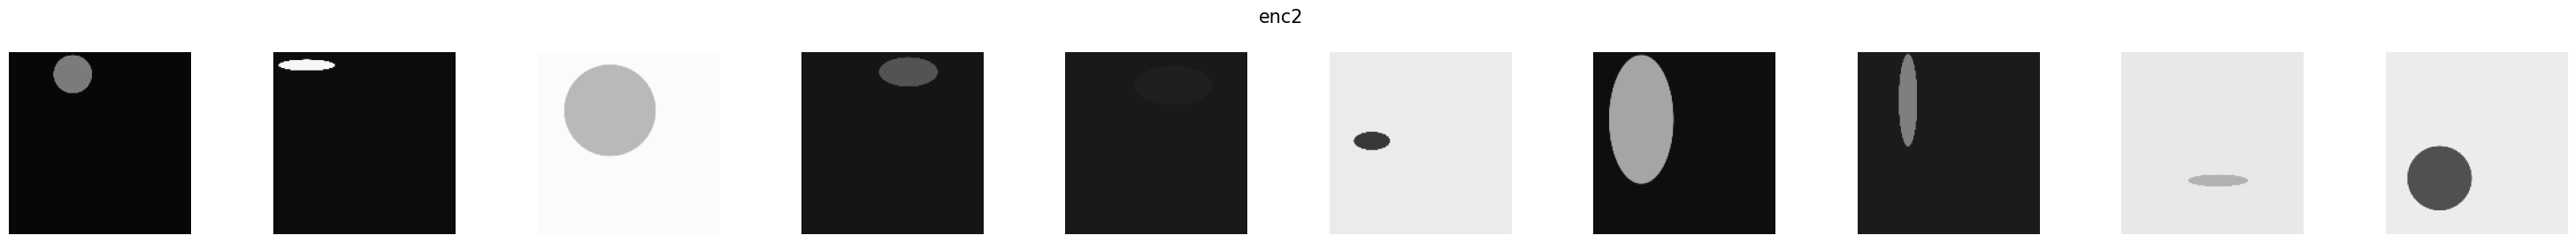

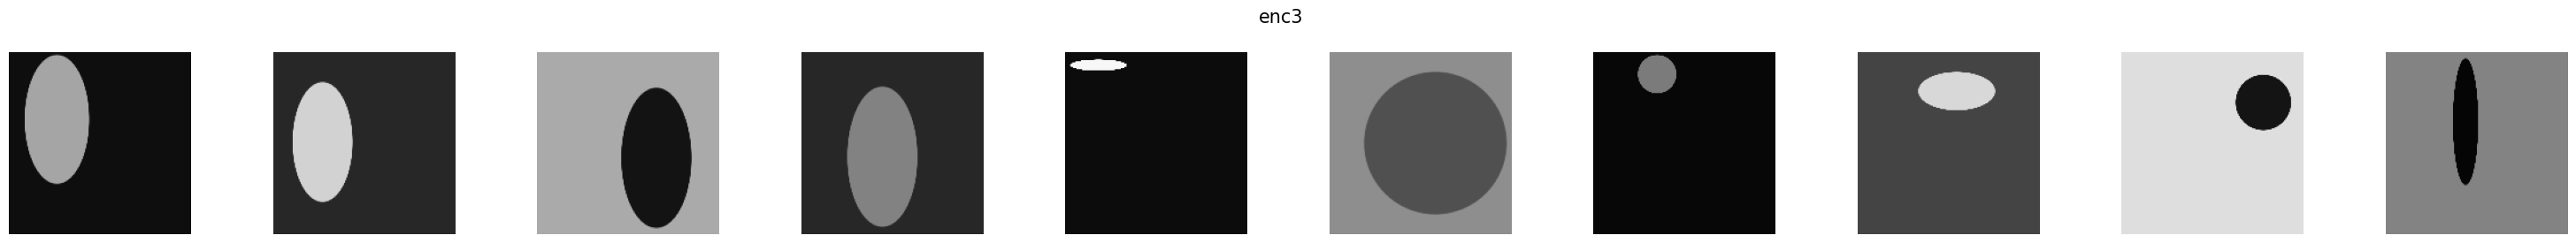

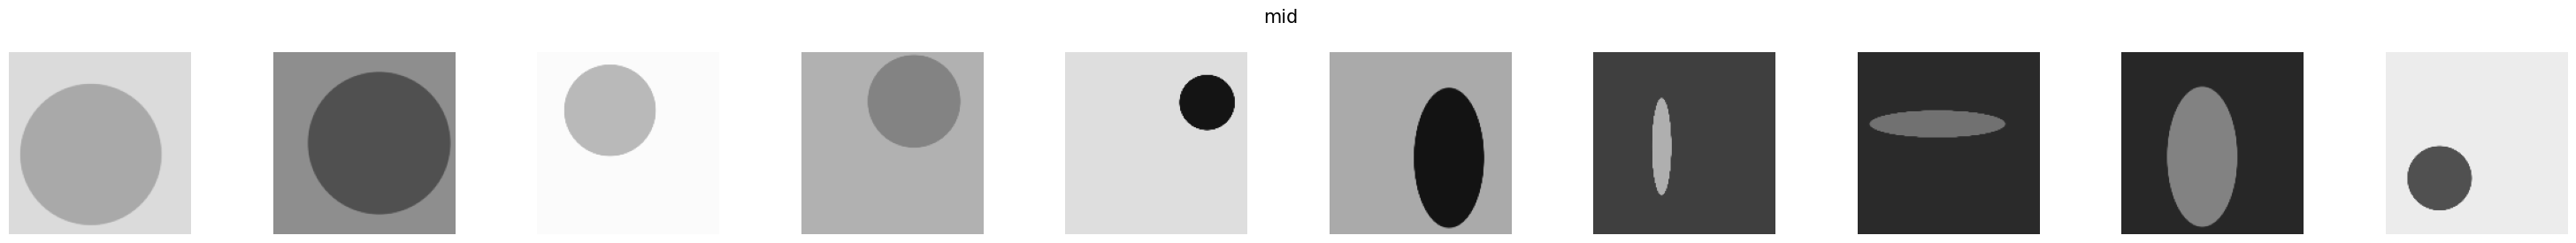

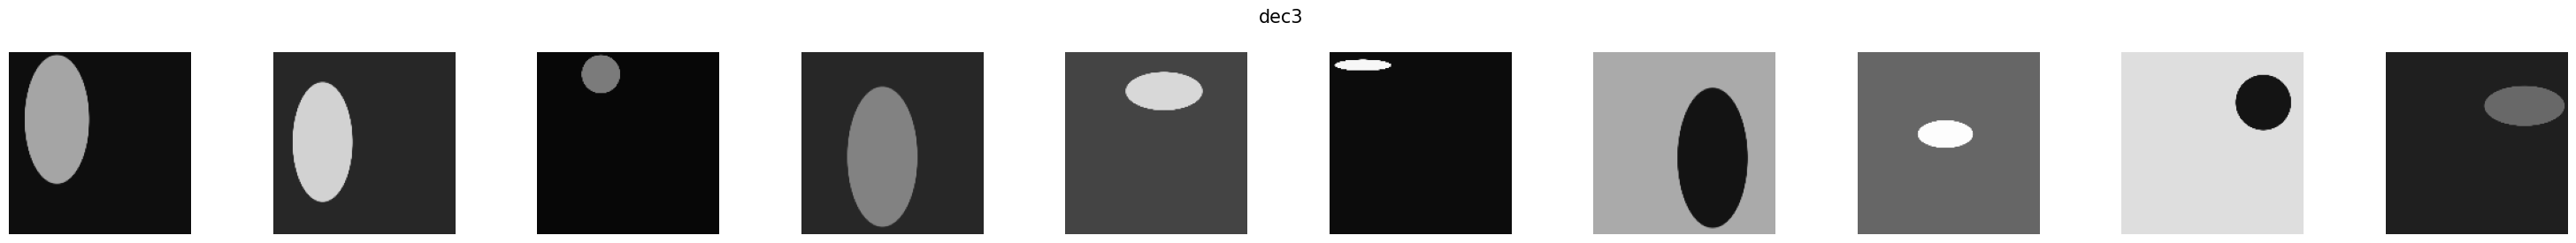

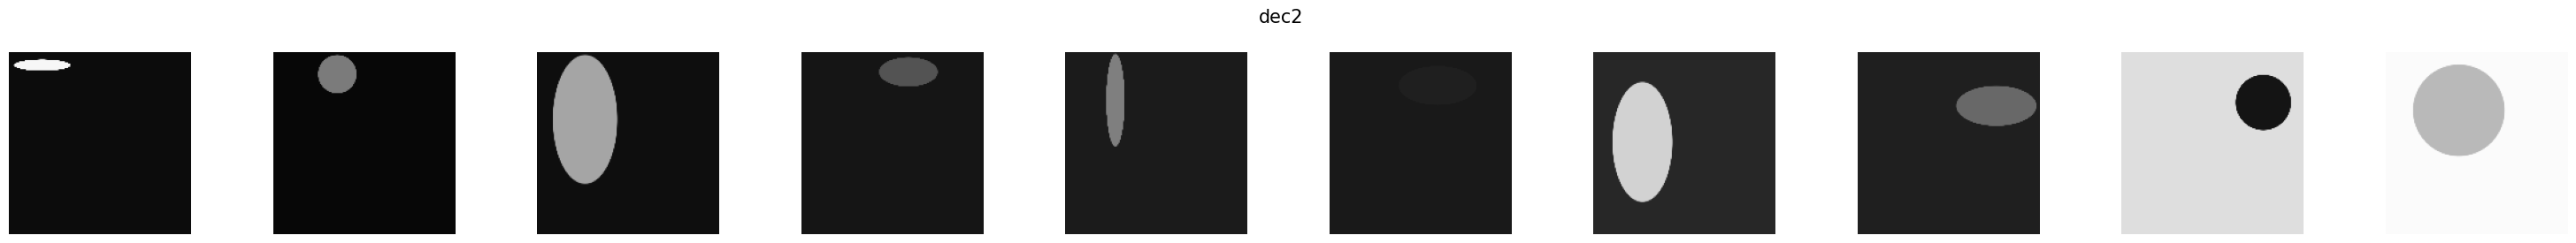

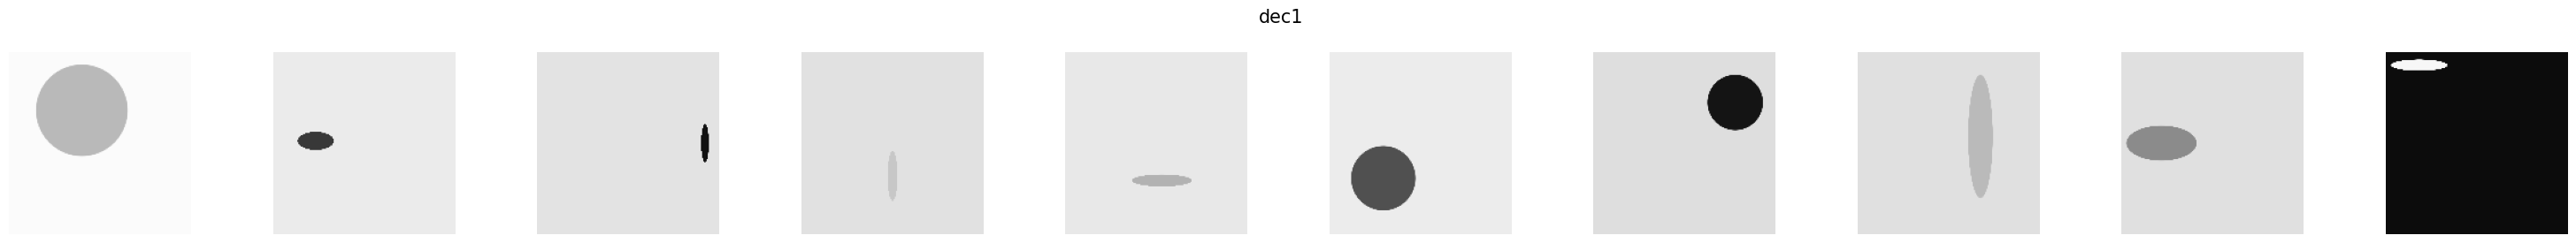

In [142]:
sig = 250
group = 'mixture-gray'
phi_xc = get_channel_means(denoisers[group], 
                      add_noise_torch(inp_ims.to(device), sig, device=device)[0],
                      average_phi=False,with_params=True, return_activations=False)


print('Most decorrelated images across different blocks at noise level: ' , sig)

for block in range(len(blocks)):
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0], 
                label=blocks[block],vmin=0,  vmax = 1 ) 

Most decorrelated images across different blocks for sigma 250


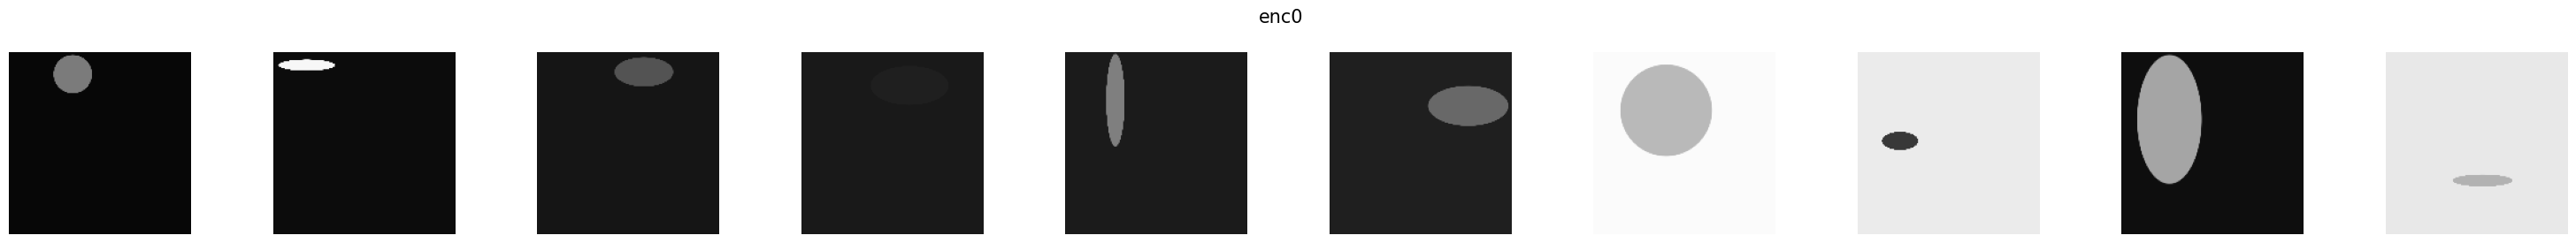

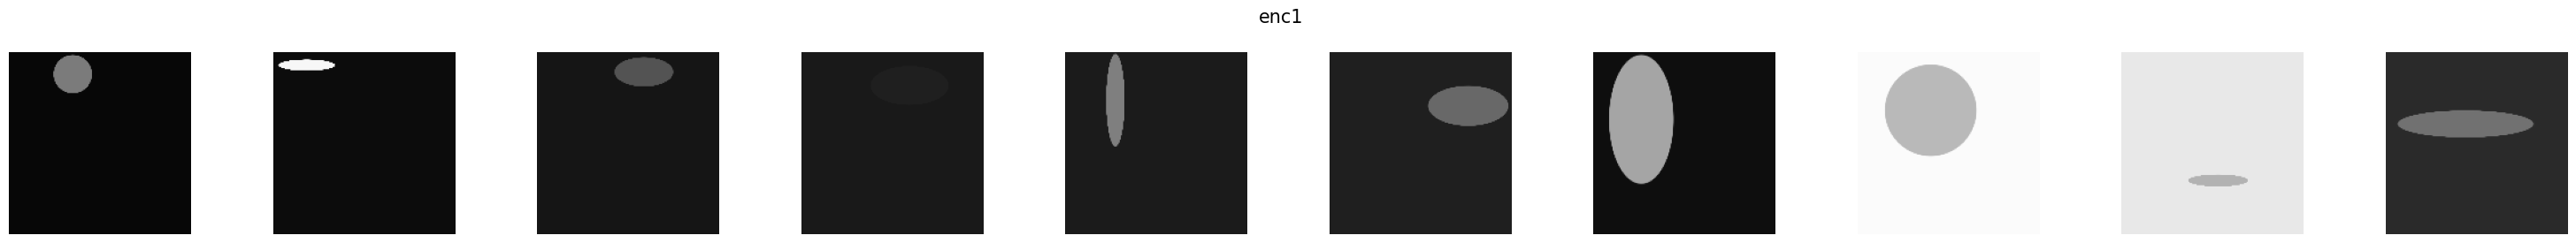

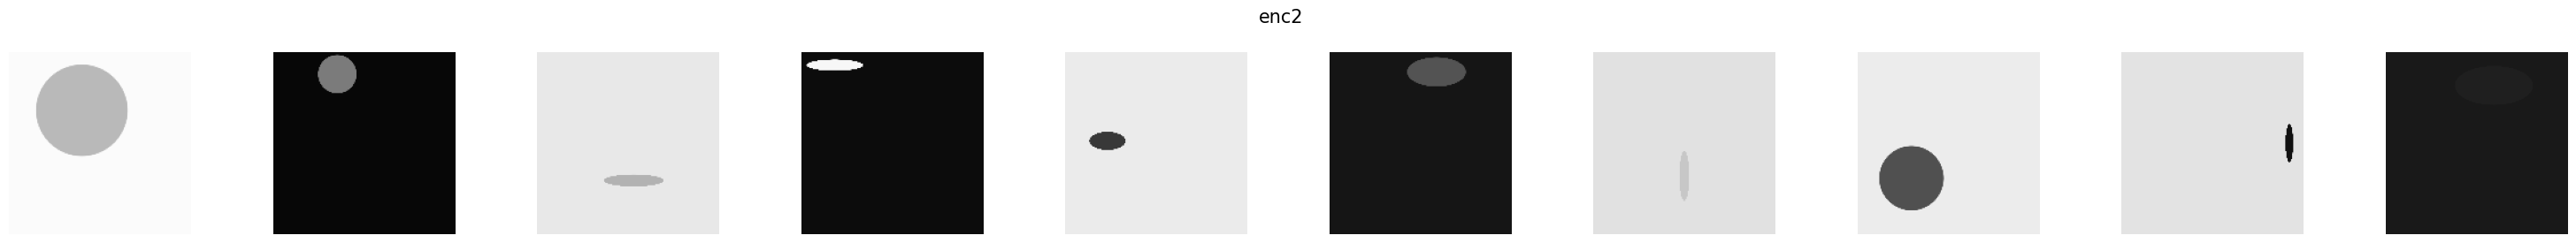

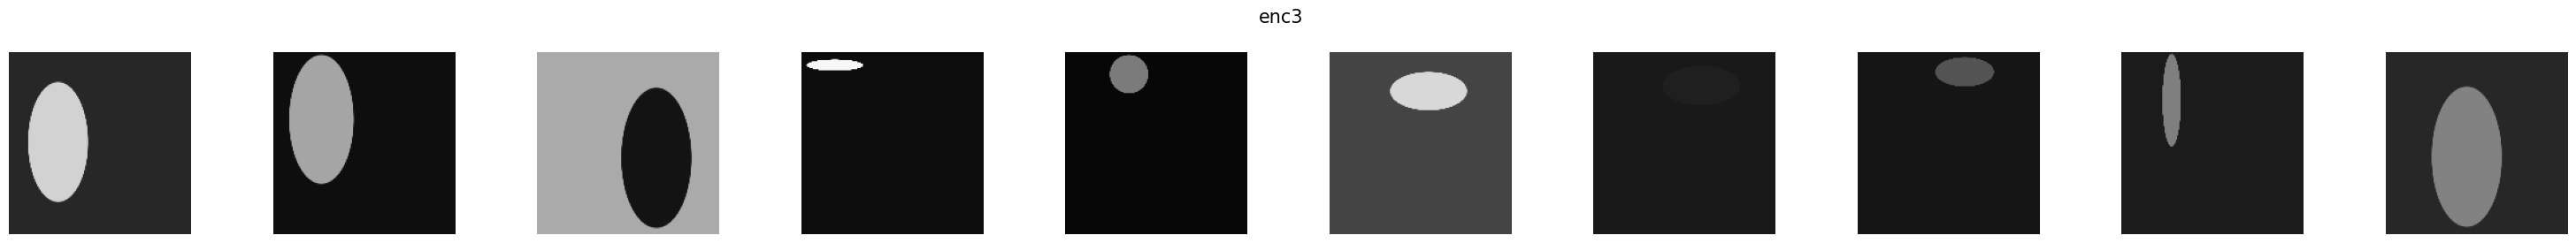

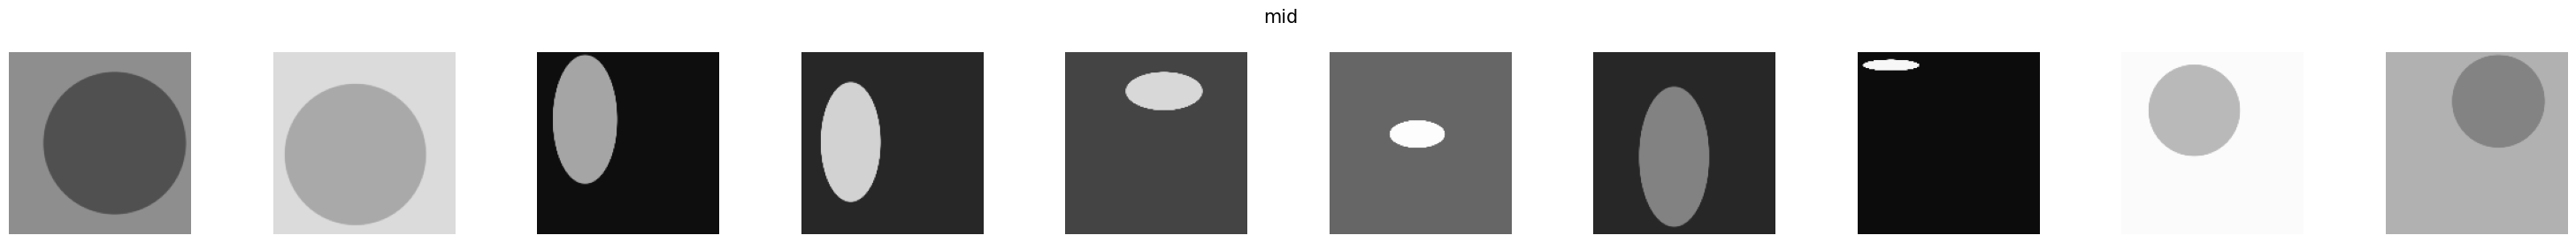

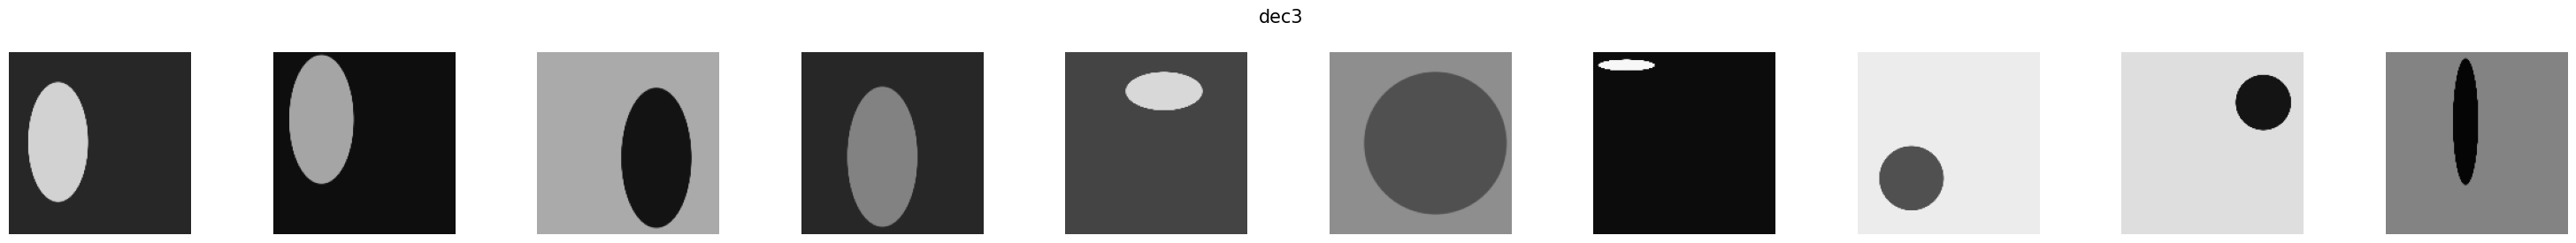

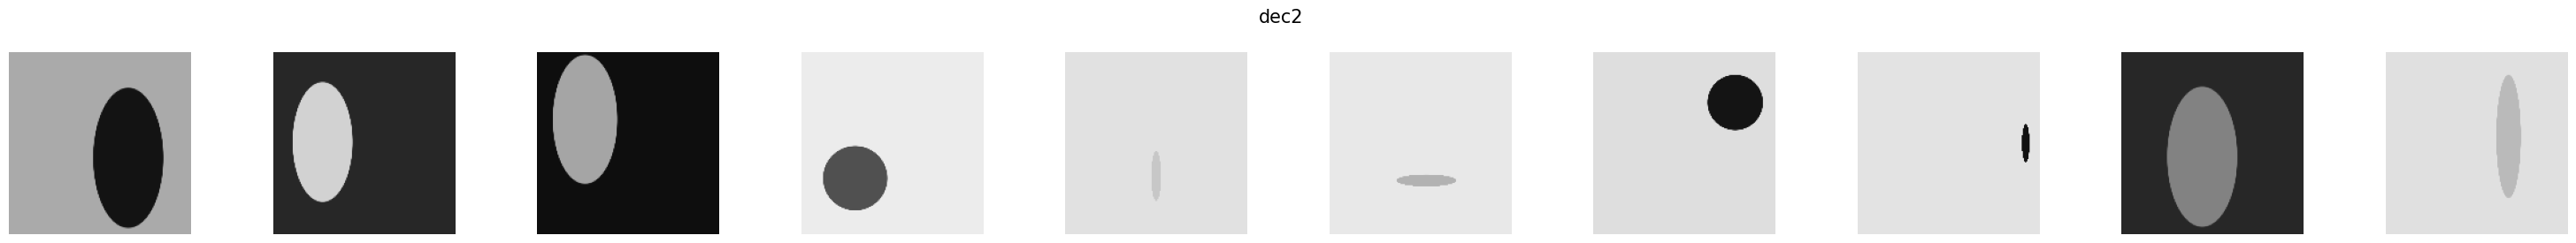

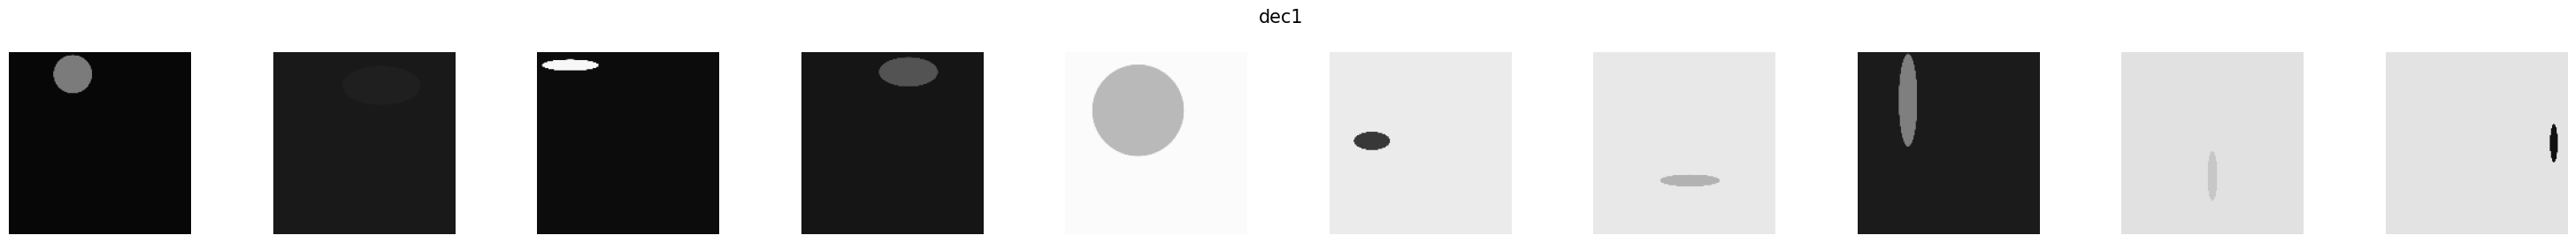

In [144]:
group = 'conditional-gray'
sig=250
phi_xc,phi_x = get_channel_means(denoisers[group], x1= inp_ims,
                      x2=add_noise_torch(inp_ims.to(device), sig, device=device)[0],                      
                      average_phi=False,with_params=True, return_activations=False)

print('Most decorrelated images across different blocks for sigma' , sig)
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_x[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] ,
                label=blocks[block], vmin=0,  vmax = 1) 

Most decorrelated images across different blocks for clean image


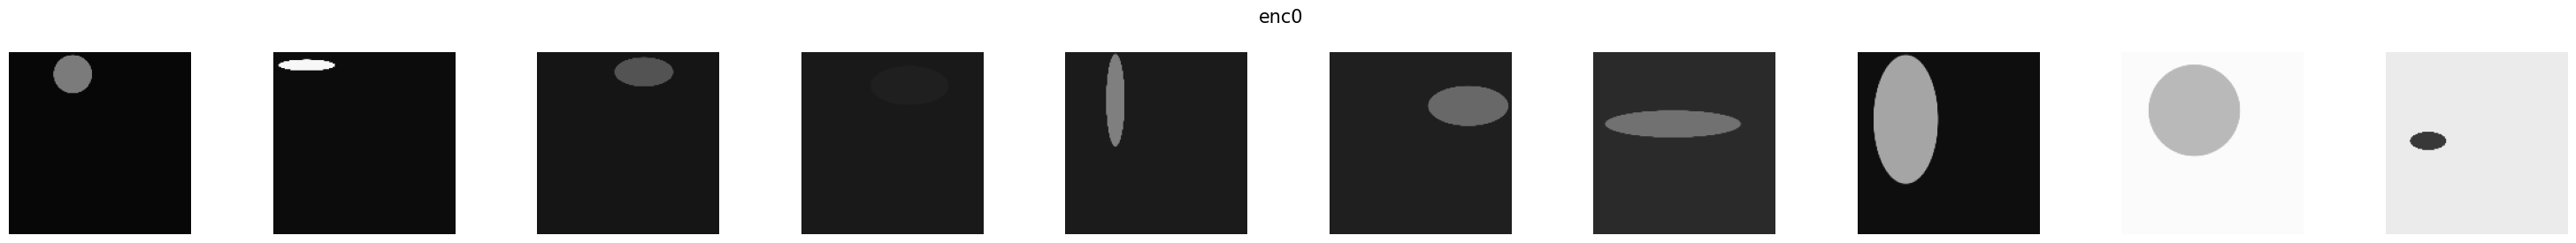

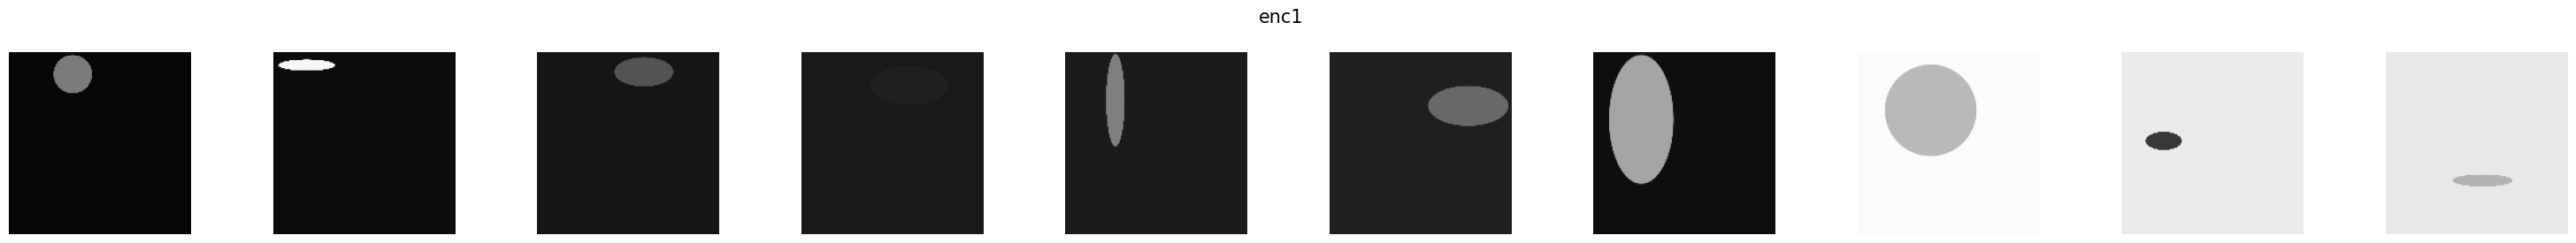

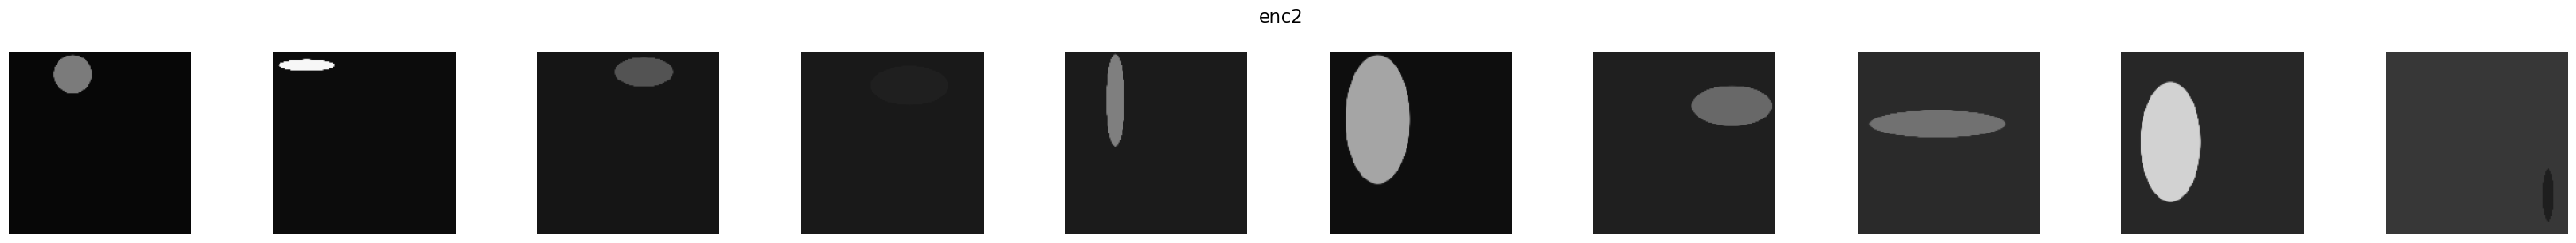

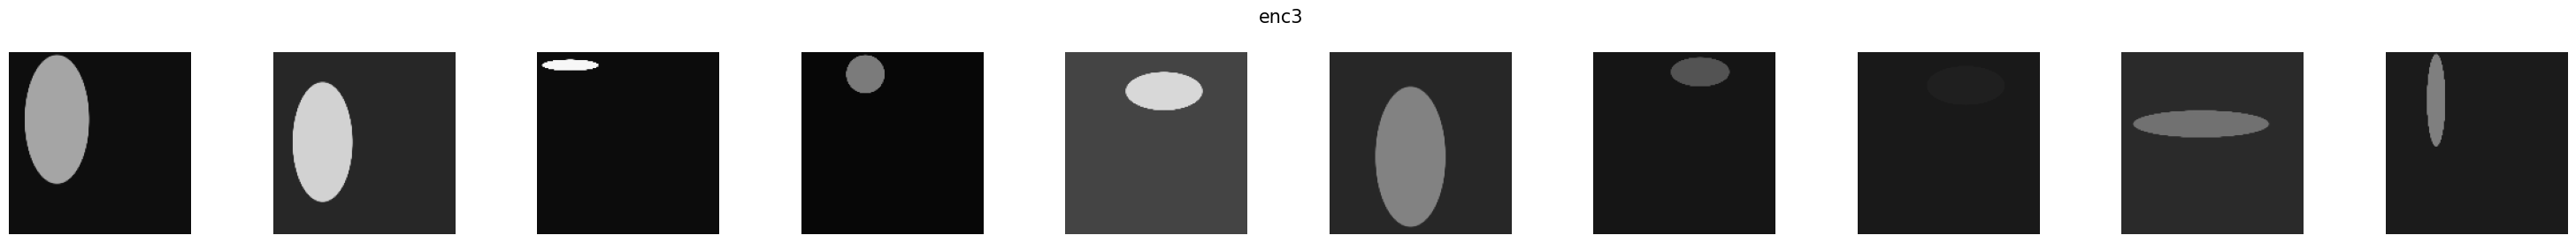

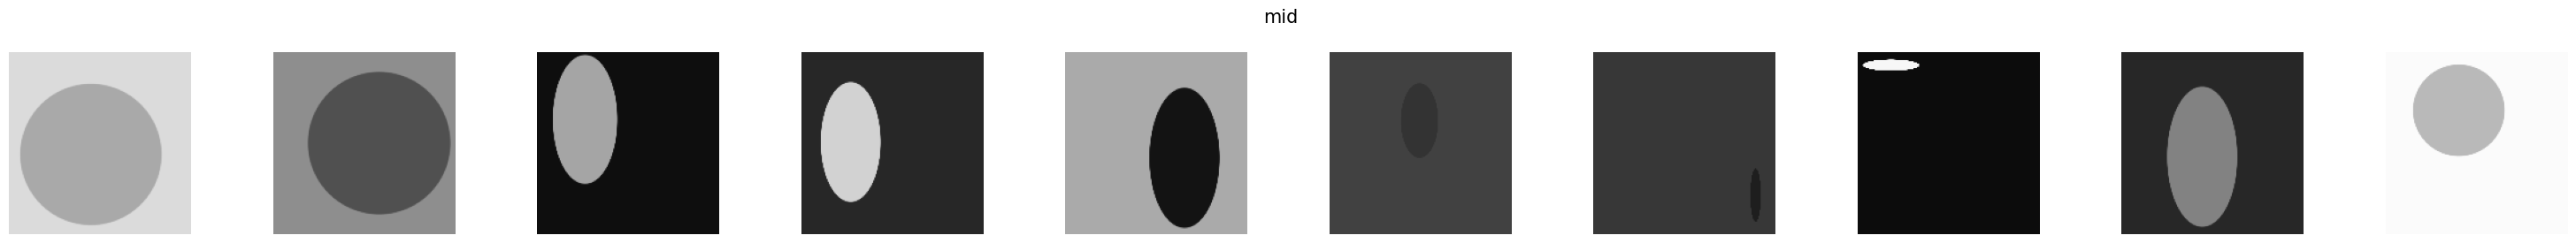

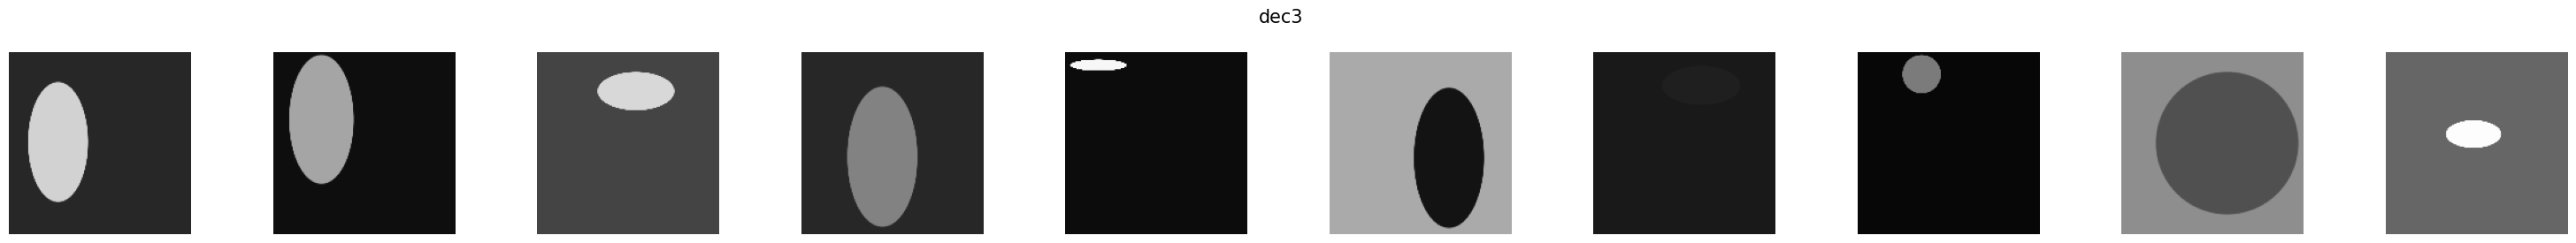

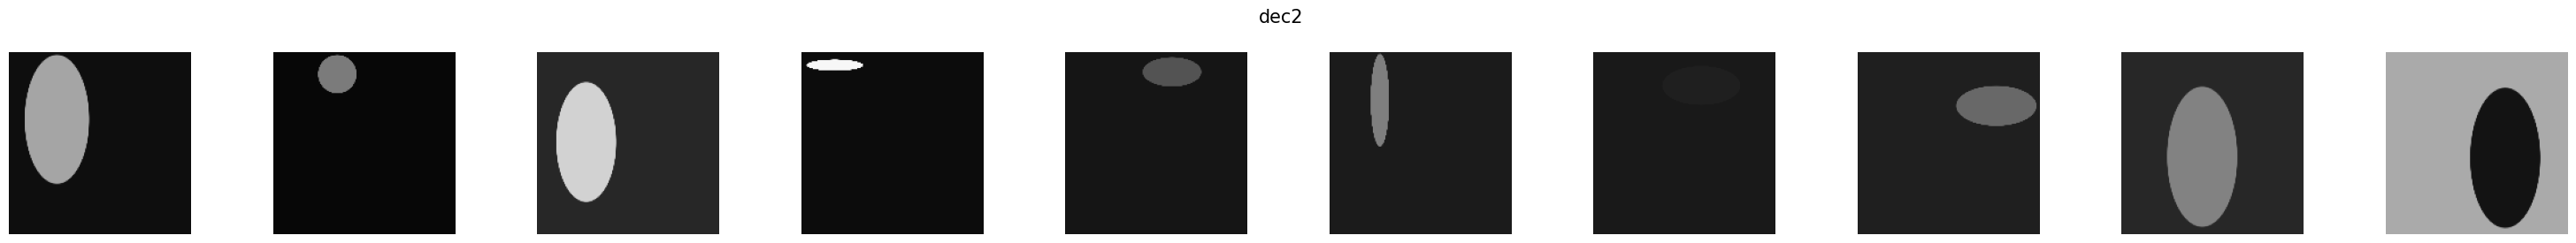

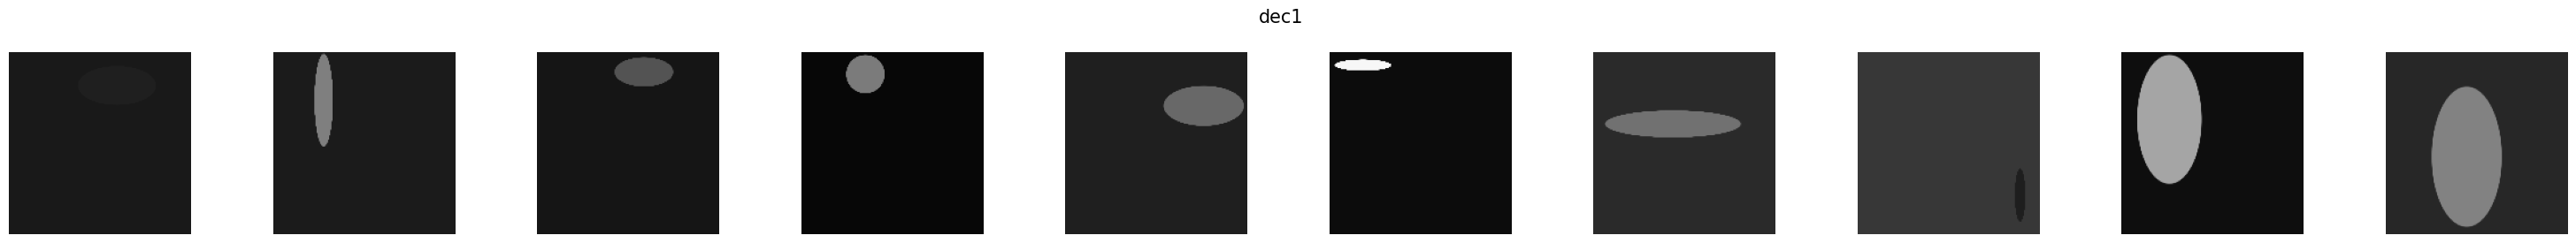

In [145]:
print('Most decorrelated images across different blocks for clean image')
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] ,
                label=blocks[block],vmin=0,  vmax = 1) 